In [1]:
import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 10,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_1024_512_256_128_0001_CCE_10_1_1_0_1_0_e_e_0_1_1_connectivity_data_norm_b25_roi_t1_native_k5_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1919620, 198)
(1919620, 8)
validation
(288502, 198)
(288502, 8)
test
(221128, 198)
(221128, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 198)]             0         


 dense (Dense)               (None, 1024)              203776    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 893832 (3.41 MB)


Trainable params: 893832 (3.41 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/20 [>.............................] - ETA: 1:51 - loss: 2.4440 - STD: 0.1173 - MAE: 0.2174

 2/20 [==>...........................] - ETA: 1s - loss: 2.3315 - STD: 0.0904 - MAE: 0.2178  

 3/20 [===>..........................] - ETA: 1s - loss: 2.2631 - STD: 0.0730 - MAE: 0.2180

 4/20 [=====>........................] - ETA: 11s - loss: 2.2532 - STD: 0.0615 - MAE: 0.2182

 5/20 [======>.......................] - ETA: 8s - loss: 2.2179 - STD: 0.0548 - MAE: 0.2183 

 6/20 [========>.....................] - ETA: 6s - loss: 2.1988 - STD: 0.0509 - MAE: 0.2184

 7/20 [=========>....................] - ETA: 5s - loss: 2.1874 - STD: 0.0486 - MAE: 0.2185

 8/20 [===========>..................] - ETA: 4s - loss: 2.1797 - STD: 0.0470 - MAE: 0.2186

 9/20 [============>.................] - ETA: 3s - loss: 2.1732 - STD: 0.0456 - MAE: 0.2186

10/20 [==============>...............] - ETA: 3s - loss: 2.1671 - STD: 0.0441 - MAE: 0.2187

11/20 [===============>..............] - ETA: 2s - loss: 2.1611 - STD: 0.0425 - MAE: 0.2187

12/20 [=================>............] - ETA: 2s - loss: 2.1553 - STD: 0.0407 - MAE: 0.2187

13/20 [==================>...........] - ETA: 1s - loss: 2.1499 - STD: 0.0389 - MAE: 0.2187

14/20 [====================>.........] - ETA: 1s - loss: 2.1451 - STD: 0.0372 - MAE: 0.2187

15/20 [=====================>........] - ETA: 1s - loss: 2.1408 - STD: 0.0358 - MAE: 0.2187

16/20 [=======================>......] - ETA: 0s - loss: 2.1371 - STD: 0.0346 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.1339 - STD: 0.0337 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.1311 - STD: 0.0331 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.1287 - STD: 0.0325 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.1266 - STD: 0.0321 - MAE: 0.2187

20/20 [==============================] - 12s 331ms/step - loss: 2.1266 - STD: 0.0321 - MAE: 0.2187 - val_loss: 2.0837 - val_STD: 0.0232 - val_MAE: 0.2183


Epoch 2/10000


 1/20 [>.............................] - ETA: 4s - loss: 2.0872 - STD: 0.0232 - MAE: 0.2185

 2/20 [==>...........................] - ETA: 2s - loss: 2.0875 - STD: 0.0227 - MAE: 0.2185

 3/20 [===>..........................] - ETA: 1s - loss: 2.0869 - STD: 0.0220 - MAE: 0.2185

 4/20 [=====>........................] - ETA: 1s - loss: 2.0864 - STD: 0.0212 - MAE: 0.2185

 5/20 [======>.......................] - ETA: 1s - loss: 2.0858 - STD: 0.0202 - MAE: 0.2185

 6/20 [========>.....................] - ETA: 1s - loss: 2.0852 - STD: 0.0192 - MAE: 0.2185

 7/20 [=========>....................] - ETA: 1s - loss: 2.0846 - STD: 0.0181 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 1s - loss: 2.0839 - STD: 0.0170 - MAE: 0.2186

 9/20 [============>.................] - ETA: 1s - loss: 2.0834 - STD: 0.0158 - MAE: 0.2186

10/20 [==============>...............] - ETA: 1s - loss: 2.0830 - STD: 0.0147 - MAE: 0.2186

11/20 [===============>..............] - ETA: 0s - loss: 2.0826 - STD: 0.0137 - MAE: 0.2186

13/20 [==================>...........] - ETA: 0s - loss: 2.0824 - STD: 0.0125 - MAE: 0.2186

14/20 [====================>.........] - ETA: 0s - loss: 2.0823 - STD: 0.0121 - MAE: 0.2186

15/20 [=====================>........] - ETA: 0s - loss: 2.0822 - STD: 0.0118 - MAE: 0.2186

16/20 [=======================>......] - ETA: 0s - loss: 2.0821 - STD: 0.0116 - MAE: 0.2187

17/20 [========================>.....] - ETA: 0s - loss: 2.0819 - STD: 0.0114 - MAE: 0.2187

18/20 [==========================>...] - ETA: 0s - loss: 2.0818 - STD: 0.0112 - MAE: 0.2187

19/20 [===========================>..] - ETA: 0s - loss: 2.0816 - STD: 0.0110 - MAE: 0.2187

20/20 [==============================] - ETA: 0s - loss: 2.0815 - STD: 0.0109 - MAE: 0.2187

20/20 [==============================] - 3s 139ms/step - loss: 2.0815 - STD: 0.0109 - MAE: 0.2187 - val_loss: 2.0767 - val_STD: 0.0078 - val_MAE: 0.2186


Epoch 3/10000


 1/20 [>.............................] - ETA: 4s - loss: 2.0780 - STD: 0.0078 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 2s - loss: 2.0779 - STD: 0.0079 - MAE: 0.2186

 3/20 [===>..........................] - ETA: 1s - loss: 2.0779 - STD: 0.0081 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 1s - loss: 2.0780 - STD: 0.0083 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 1s - loss: 2.0780 - STD: 0.0085 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 1s - loss: 2.0782 - STD: 0.0088 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 1s - loss: 2.0783 - STD: 0.0089 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 1s - loss: 2.0783 - STD: 0.0090 - MAE: 0.2186

 9/20 [============>.................] - ETA: 1s - loss: 2.0783 - STD: 0.0091 - MAE: 0.2186

10/20 [==============>...............] - ETA: 1s - loss: 2.0783 - STD: 0.0091 - MAE: 0.2186

11/20 [===============>..............] - ETA: 1s - loss: 2.0782 - STD: 0.0090 - MAE: 0.2186

12/20 [=================>............] - ETA: 0s - loss: 2.0782 - STD: 0.0089 - MAE: 0.2186

13/20 [==================>...........] - ETA: 0s - loss: 2.0782 - STD: 0.0088 - MAE: 0.2186

14/20 [====================>.........] - ETA: 0s - loss: 2.0782 - STD: 0.0087 - MAE: 0.2186

15/20 [=====================>........] - ETA: 0s - loss: 2.0781 - STD: 0.0086 - MAE: 0.2186

16/20 [=======================>......] - ETA: 0s - loss: 2.0781 - STD: 0.0084 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0781 - STD: 0.0081 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0781 - STD: 0.0080 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0781 - STD: 0.0078 - MAE: 0.2186

20/20 [==============================] - 3s 129ms/step - loss: 2.0781 - STD: 0.0078 - MAE: 0.2186 - val_loss: 2.0769 - val_STD: 0.0050 - val_MAE: 0.2186


Epoch 4/10000


 1/20 [>.............................] - ETA: 5s - loss: 2.0779 - STD: 0.0050 - MAE: 0.2187

 2/20 [==>...........................] - ETA: 2s - loss: 2.0777 - STD: 0.0050 - MAE: 0.2187

 3/20 [===>..........................] - ETA: 2s - loss: 2.0777 - STD: 0.0051 - MAE: 0.2187

 4/20 [=====>........................] - ETA: 2s - loss: 2.0777 - STD: 0.0053 - MAE: 0.2187

 5/20 [======>.......................] - ETA: 1s - loss: 2.0778 - STD: 0.0055 - MAE: 0.2187

 6/20 [========>.....................] - ETA: 1s - loss: 2.0778 - STD: 0.0057 - MAE: 0.2187

 7/20 [=========>....................] - ETA: 1s - loss: 2.0777 - STD: 0.0059 - MAE: 0.2187

 8/20 [===========>..................] - ETA: 1s - loss: 2.0777 - STD: 0.0061 - MAE: 0.2187

 9/20 [============>.................] - ETA: 1s - loss: 2.0777 - STD: 0.0062 - MAE: 0.2187

10/20 [==============>...............] - ETA: 1s - loss: 2.0776 - STD: 0.0063 - MAE: 0.2187

11/20 [===============>..............] - ETA: 1s - loss: 2.0776 - STD: 0.0064 - MAE: 0.2187

12/20 [=================>............] - ETA: 0s - loss: 2.0776 - STD: 0.0065 - MAE: 0.2186

13/20 [==================>...........] - ETA: 0s - loss: 2.0776 - STD: 0.0065 - MAE: 0.2186

14/20 [====================>.........] - ETA: 0s - loss: 2.0775 - STD: 0.0066 - MAE: 0.2186

15/20 [=====================>........] - ETA: 0s - loss: 2.0775 - STD: 0.0067 - MAE: 0.2186

16/20 [=======================>......] - ETA: 0s - loss: 2.0775 - STD: 0.0067 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.0774 - STD: 0.0067 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186

20/20 [==============================] - 3s 131ms/step - loss: 2.0774 - STD: 0.0068 - MAE: 0.2186 - val_loss: 2.0756 - val_STD: 0.0063 - val_MAE: 0.2186


Epoch 5/10000


 1/20 [>.............................] - ETA: 1s - loss: 2.0766 - STD: 0.0062 - MAE: 0.2186

 2/20 [==>...........................] - ETA: 4s - loss: 2.0767 - STD: 0.0061 - MAE: 0.2186

 3/20 [===>..........................] - ETA: 3s - loss: 2.0766 - STD: 0.0060 - MAE: 0.2186

 4/20 [=====>........................] - ETA: 3s - loss: 2.0765 - STD: 0.0060 - MAE: 0.2186

 5/20 [======>.......................] - ETA: 2s - loss: 2.0765 - STD: 0.0060 - MAE: 0.2186

 6/20 [========>.....................] - ETA: 2s - loss: 2.0764 - STD: 0.0060 - MAE: 0.2186

 7/20 [=========>....................] - ETA: 2s - loss: 2.0764 - STD: 0.0061 - MAE: 0.2186

 8/20 [===========>..................] - ETA: 1s - loss: 2.0763 - STD: 0.0062 - MAE: 0.2186

 9/20 [============>.................] - ETA: 1s - loss: 2.0762 - STD: 0.0063 - MAE: 0.2186

10/20 [==============>...............] - ETA: 1s - loss: 2.0762 - STD: 0.0064 - MAE: 0.2186

11/20 [===============>..............] - ETA: 1s - loss: 2.0761 - STD: 0.0065 - MAE: 0.2186

12/20 [=================>............] - ETA: 1s - loss: 2.0760 - STD: 0.0065 - MAE: 0.2186

13/20 [==================>...........] - ETA: 1s - loss: 2.0759 - STD: 0.0066 - MAE: 0.2186

14/20 [====================>.........] - ETA: 0s - loss: 2.0758 - STD: 0.0066 - MAE: 0.2186

15/20 [=====================>........] - ETA: 0s - loss: 2.0757 - STD: 0.0066 - MAE: 0.2186

16/20 [=======================>......] - ETA: 0s - loss: 2.0755 - STD: 0.0066 - MAE: 0.2186

17/20 [========================>.....] - ETA: 0s - loss: 2.0754 - STD: 0.0066 - MAE: 0.2186

18/20 [==========================>...] - ETA: 0s - loss: 2.0753 - STD: 0.0066 - MAE: 0.2186

19/20 [===========================>..] - ETA: 0s - loss: 2.0751 - STD: 0.0066 - MAE: 0.2186

20/20 [==============================] - ETA: 0s - loss: 2.0749 - STD: 0.0066 - MAE: 0.2186

20/20 [==============================] - 3s 167ms/step - loss: 2.0749 - STD: 0.0066 - MAE: 0.2186 - val_loss: 2.0704 - val_STD: 0.0075 - val_MAE: 0.2184


Epoch 6/10000


 1/20 [>.............................] - ETA: 5s - loss: 2.0710 - STD: 0.0074 - MAE: 0.2184

 2/20 [==>...........................] - ETA: 2s - loss: 2.0705 - STD: 0.0075 - MAE: 0.2184

 3/20 [===>..........................] - ETA: 2s - loss: 2.0699 - STD: 0.0076 - MAE: 0.2184

 4/20 [=====>........................] - ETA: 2s - loss: 2.0696 - STD: 0.0077 - MAE: 0.2184

 5/20 [======>.......................] - ETA: 2s - loss: 2.0691 - STD: 0.0078 - MAE: 0.2184

 6/20 [========>.....................] - ETA: 1s - loss: 2.0685 - STD: 0.0079 - MAE: 0.2183

 7/20 [=========>....................] - ETA: 1s - loss: 2.0679 - STD: 0.0080 - MAE: 0.2183

 8/20 [===========>..................] - ETA: 1s - loss: 2.0673 - STD: 0.0081 - MAE: 0.2183

 9/20 [============>.................] - ETA: 1s - loss: 2.0665 - STD: 0.0082 - MAE: 0.2183

10/20 [==============>...............] - ETA: 1s - loss: 2.0657 - STD: 0.0083 - MAE: 0.2183

11/20 [===============>..............] - ETA: 1s - loss: 2.0648 - STD: 0.0085 - MAE: 0.2182

12/20 [=================>............] - ETA: 1s - loss: 2.0639 - STD: 0.0086 - MAE: 0.2182

14/20 [====================>.........] - ETA: 0s - loss: 2.0624 - STD: 0.0091 - MAE: 0.2181

15/20 [=====================>........] - ETA: 0s - loss: 2.0610 - STD: 0.0094 - MAE: 0.2181

16/20 [=======================>......] - ETA: 0s - loss: 2.0596 - STD: 0.0098 - MAE: 0.2180

17/20 [========================>.....] - ETA: 0s - loss: 2.0580 - STD: 0.0102 - MAE: 0.2180

18/20 [==========================>...] - ETA: 0s - loss: 2.0563 - STD: 0.0106 - MAE: 0.2179

19/20 [===========================>..] - ETA: 0s - loss: 2.0545 - STD: 0.0111 - MAE: 0.2178

20/20 [==============================] - ETA: 0s - loss: 2.0525 - STD: 0.0116 - MAE: 0.2178

20/20 [==============================] - 3s 146ms/step - loss: 2.0525 - STD: 0.0116 - MAE: 0.2178 - val_loss: 2.0210 - val_STD: 0.0248 - val_MAE: 0.2163


Epoch 7/10000


 1/20 [>.............................] - ETA: 5s - loss: 2.0111 - STD: 0.0243 - MAE: 0.2160

 2/20 [==>...........................] - ETA: 2s - loss: 2.0079 - STD: 0.0255 - MAE: 0.2159

 3/20 [===>..........................] - ETA: 2s - loss: 2.0049 - STD: 0.0268 - MAE: 0.2157

 4/20 [=====>........................] - ETA: 1s - loss: 2.0017 - STD: 0.0281 - MAE: 0.2156

 5/20 [======>.......................] - ETA: 1s - loss: 1.9986 - STD: 0.0295 - MAE: 0.2154

 6/20 [========>.....................] - ETA: 1s - loss: 1.9952 - STD: 0.0310 - MAE: 0.2152

 7/20 [=========>....................] - ETA: 1s - loss: 1.9922 - STD: 0.0325 - MAE: 0.2150

 8/20 [===========>..................] - ETA: 1s - loss: 1.9894 - STD: 0.0340 - MAE: 0.2148

 9/20 [============>.................] - ETA: 1s - loss: 1.9865 - STD: 0.0356 - MAE: 0.2146

10/20 [==============>...............] - ETA: 1s - loss: 1.9839 - STD: 0.0371 - MAE: 0.2144

11/20 [===============>..............] - ETA: 1s - loss: 1.9815 - STD: 0.0386 - MAE: 0.2142

12/20 [=================>............] - ETA: 0s - loss: 1.9792 - STD: 0.0400 - MAE: 0.2140

13/20 [==================>...........] - ETA: 0s - loss: 1.9771 - STD: 0.0414 - MAE: 0.2138

14/20 [====================>.........] - ETA: 0s - loss: 1.9751 - STD: 0.0427 - MAE: 0.2136

15/20 [=====================>........] - ETA: 0s - loss: 1.9734 - STD: 0.0439 - MAE: 0.2135

16/20 [=======================>......] - ETA: 0s - loss: 1.9718 - STD: 0.0452 - MAE: 0.2133

17/20 [========================>.....] - ETA: 0s - loss: 1.9704 - STD: 0.0463 - MAE: 0.2132

18/20 [==========================>...] - ETA: 0s - loss: 1.9691 - STD: 0.0473 - MAE: 0.2130

20/20 [==============================] - ETA: 0s - loss: 1.9674 - STD: 0.0492 - MAE: 0.2127

20/20 [==============================] - 3s 152ms/step - loss: 1.9674 - STD: 0.0492 - MAE: 0.2127 - val_loss: 1.9715 - val_STD: 0.0654 - val_MAE: 0.2112


Epoch 8/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.9404 - STD: 0.0646 - MAE: 0.2104

 2/20 [==>...........................] - ETA: 1s - loss: 1.9406 - STD: 0.0647 - MAE: 0.2104

 3/20 [===>..........................] - ETA: 1s - loss: 1.9400 - STD: 0.0645 - MAE: 0.2104

 4/20 [=====>........................] - ETA: 1s - loss: 1.9387 - STD: 0.0642 - MAE: 0.2104

 5/20 [======>.......................] - ETA: 1s - loss: 1.9386 - STD: 0.0640 - MAE: 0.2105

 6/20 [========>.....................] - ETA: 1s - loss: 1.9380 - STD: 0.0639 - MAE: 0.2104

 7/20 [=========>....................] - ETA: 1s - loss: 1.9378 - STD: 0.0638 - MAE: 0.2104

 8/20 [===========>..................] - ETA: 1s - loss: 1.9376 - STD: 0.0637 - MAE: 0.2104

 9/20 [============>.................] - ETA: 1s - loss: 1.9367 - STD: 0.0636 - MAE: 0.2104

10/20 [==============>...............] - ETA: 1s - loss: 1.9358 - STD: 0.0636 - MAE: 0.2104

11/20 [===============>..............] - ETA: 1s - loss: 1.9352 - STD: 0.0636 - MAE: 0.2104

12/20 [=================>............] - ETA: 1s - loss: 1.9347 - STD: 0.0636 - MAE: 0.2104

13/20 [==================>...........] - ETA: 0s - loss: 1.9339 - STD: 0.0637 - MAE: 0.2103

14/20 [====================>.........] - ETA: 0s - loss: 1.9332 - STD: 0.0638 - MAE: 0.2103

15/20 [=====================>........] - ETA: 0s - loss: 1.9324 - STD: 0.0640 - MAE: 0.2102

16/20 [=======================>......] - ETA: 0s - loss: 1.9317 - STD: 0.0641 - MAE: 0.2102

17/20 [========================>.....] - ETA: 0s - loss: 1.9307 - STD: 0.0642 - MAE: 0.2102

18/20 [==========================>...] - ETA: 0s - loss: 1.9298 - STD: 0.0643 - MAE: 0.2101

19/20 [===========================>..] - ETA: 0s - loss: 1.9290 - STD: 0.0644 - MAE: 0.2101

20/20 [==============================] - 3s 148ms/step - loss: 1.9289 - STD: 0.0645 - MAE: 0.2100 - val_loss: 1.9375 - val_STD: 0.0671 - val_MAE: 0.2099


Epoch 9/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.9094 - STD: 0.0661 - MAE: 0.2092

 2/20 [==>...........................] - ETA: 2s - loss: 1.9086 - STD: 0.0662 - MAE: 0.2092

 3/20 [===>..........................] - ETA: 2s - loss: 1.9088 - STD: 0.0662 - MAE: 0.2092

 4/20 [=====>........................] - ETA: 2s - loss: 1.9076 - STD: 0.0663 - MAE: 0.2091

 5/20 [======>.......................] - ETA: 2s - loss: 1.9065 - STD: 0.0665 - MAE: 0.2090

 6/20 [========>.....................] - ETA: 1s - loss: 1.9050 - STD: 0.0666 - MAE: 0.2090

 7/20 [=========>....................] - ETA: 1s - loss: 1.9040 - STD: 0.0667 - MAE: 0.2089

 9/20 [============>.................] - ETA: 1s - loss: 1.9025 - STD: 0.0671 - MAE: 0.2088

10/20 [==============>...............] - ETA: 1s - loss: 1.9011 - STD: 0.0674 - MAE: 0.2087

11/20 [===============>..............] - ETA: 1s - loss: 1.8997 - STD: 0.0676 - MAE: 0.2086

12/20 [=================>............] - ETA: 1s - loss: 1.8982 - STD: 0.0679 - MAE: 0.2085

13/20 [==================>...........] - ETA: 0s - loss: 1.8967 - STD: 0.0682 - MAE: 0.2084

14/20 [====================>.........] - ETA: 0s - loss: 1.8955 - STD: 0.0685 - MAE: 0.2084

15/20 [=====================>........] - ETA: 0s - loss: 1.8945 - STD: 0.0688 - MAE: 0.2083

16/20 [=======================>......] - ETA: 0s - loss: 1.8934 - STD: 0.0690 - MAE: 0.2082

17/20 [========================>.....] - ETA: 0s - loss: 1.8924 - STD: 0.0693 - MAE: 0.2081

18/20 [==========================>...] - ETA: 0s - loss: 1.8914 - STD: 0.0695 - MAE: 0.2081

19/20 [===========================>..] - ETA: 0s - loss: 1.8902 - STD: 0.0698 - MAE: 0.2080

20/20 [==============================] - ETA: 0s - loss: 1.8893 - STD: 0.0701 - MAE: 0.2079

20/20 [==============================] - 3s 145ms/step - loss: 1.8893 - STD: 0.0701 - MAE: 0.2079 - val_loss: 1.8962 - val_STD: 0.0771 - val_MAE: 0.2069


Epoch 10/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.8727 - STD: 0.0757 - MAE: 0.2064

 2/20 [==>...........................] - ETA: 2s - loss: 1.8699 - STD: 0.0763 - MAE: 0.2063

 4/20 [=====>........................] - ETA: 1s - loss: 1.8688 - STD: 0.0768 - MAE: 0.2062

 5/20 [======>.......................] - ETA: 1s - loss: 1.8675 - STD: 0.0771 - MAE: 0.2061

 6/20 [========>.....................] - ETA: 1s - loss: 1.8668 - STD: 0.0774 - MAE: 0.2060

 7/20 [=========>....................] - ETA: 1s - loss: 1.8656 - STD: 0.0776 - MAE: 0.2060

 8/20 [===========>..................] - ETA: 1s - loss: 1.8646 - STD: 0.0778 - MAE: 0.2059

 9/20 [============>.................] - ETA: 1s - loss: 1.8639 - STD: 0.0780 - MAE: 0.2058

10/20 [==============>...............] - ETA: 1s - loss: 1.8629 - STD: 0.0782 - MAE: 0.2058

11/20 [===============>..............] - ETA: 1s - loss: 1.8622 - STD: 0.0783 - MAE: 0.2057

12/20 [=================>............] - ETA: 1s - loss: 1.8612 - STD: 0.0786 - MAE: 0.2057

13/20 [==================>...........] - ETA: 0s - loss: 1.8605 - STD: 0.0788 - MAE: 0.2056

14/20 [====================>.........] - ETA: 0s - loss: 1.8598 - STD: 0.0789 - MAE: 0.2056

15/20 [=====================>........] - ETA: 0s - loss: 1.8590 - STD: 0.0791 - MAE: 0.2055

16/20 [=======================>......] - ETA: 0s - loss: 1.8584 - STD: 0.0792 - MAE: 0.2055

17/20 [========================>.....] - ETA: 0s - loss: 1.8576 - STD: 0.0793 - MAE: 0.2054

18/20 [==========================>...] - ETA: 0s - loss: 1.8571 - STD: 0.0794 - MAE: 0.2054

19/20 [===========================>..] - ETA: 0s - loss: 1.8565 - STD: 0.0795 - MAE: 0.2054

20/20 [==============================] - ETA: 0s - loss: 1.8557 - STD: 0.0796 - MAE: 0.2053

20/20 [==============================] - 3s 163ms/step - loss: 1.8557 - STD: 0.0796 - MAE: 0.2053 - val_loss: 1.8800 - val_STD: 0.0839 - val_MAE: 0.2052


Epoch 11/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.8440 - STD: 0.0821 - MAE: 0.2045

 2/20 [==>...........................] - ETA: 3s - loss: 1.8422 - STD: 0.0820 - MAE: 0.2045

 3/20 [===>..........................] - ETA: 2s - loss: 1.8407 - STD: 0.0819 - MAE: 0.2045

 4/20 [=====>........................] - ETA: 2s - loss: 1.8397 - STD: 0.0819 - MAE: 0.2044

 5/20 [======>.......................] - ETA: 2s - loss: 1.8388 - STD: 0.0820 - MAE: 0.2044

 6/20 [========>.....................] - ETA: 1s - loss: 1.8380 - STD: 0.0821 - MAE: 0.2044

 7/20 [=========>....................] - ETA: 1s - loss: 1.8369 - STD: 0.0823 - MAE: 0.2043

 8/20 [===========>..................] - ETA: 1s - loss: 1.8367 - STD: 0.0825 - MAE: 0.2043

 9/20 [============>.................] - ETA: 1s - loss: 1.8356 - STD: 0.0827 - MAE: 0.2042

10/20 [==============>...............] - ETA: 1s - loss: 1.8350 - STD: 0.0829 - MAE: 0.2041

11/20 [===============>..............] - ETA: 1s - loss: 1.8338 - STD: 0.0831 - MAE: 0.2041

12/20 [=================>............] - ETA: 1s - loss: 1.8326 - STD: 0.0832 - MAE: 0.2040

13/20 [==================>...........] - ETA: 0s - loss: 1.8317 - STD: 0.0834 - MAE: 0.2040

15/20 [=====================>........] - ETA: 0s - loss: 1.8308 - STD: 0.0838 - MAE: 0.2038

16/20 [=======================>......] - ETA: 0s - loss: 1.8299 - STD: 0.0840 - MAE: 0.2038

17/20 [========================>.....] - ETA: 0s - loss: 1.8290 - STD: 0.0842 - MAE: 0.2037

18/20 [==========================>...] - ETA: 0s - loss: 1.8283 - STD: 0.0844 - MAE: 0.2037

19/20 [===========================>..] - ETA: 0s - loss: 1.8276 - STD: 0.0846 - MAE: 0.2036

20/20 [==============================] - ETA: 0s - loss: 1.8269 - STD: 0.0847 - MAE: 0.2036

20/20 [==============================] - 3s 165ms/step - loss: 1.8269 - STD: 0.0847 - MAE: 0.2036 - val_loss: 1.8546 - val_STD: 0.0909 - val_MAE: 0.2032


Epoch 12/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.8116 - STD: 0.0884 - MAE: 0.2025

 2/20 [==>...........................] - ETA: 2s - loss: 1.8125 - STD: 0.0886 - MAE: 0.2024

 3/20 [===>..........................] - ETA: 2s - loss: 1.8109 - STD: 0.0886 - MAE: 0.2024

 4/20 [=====>........................] - ETA: 2s - loss: 1.8097 - STD: 0.0889 - MAE: 0.2023

 5/20 [======>.......................] - ETA: 1s - loss: 1.8096 - STD: 0.0889 - MAE: 0.2023

 6/20 [========>.....................] - ETA: 1s - loss: 1.8093 - STD: 0.0889 - MAE: 0.2023

 7/20 [=========>....................] - ETA: 1s - loss: 1.8091 - STD: 0.0892 - MAE: 0.2022

 8/20 [===========>..................] - ETA: 1s - loss: 1.8085 - STD: 0.0892 - MAE: 0.2022

10/20 [==============>...............] - ETA: 1s - loss: 1.8077 - STD: 0.0895 - MAE: 0.2021

11/20 [===============>..............] - ETA: 1s - loss: 1.8070 - STD: 0.0896 - MAE: 0.2020

12/20 [=================>............] - ETA: 0s - loss: 1.8066 - STD: 0.0896 - MAE: 0.2020

13/20 [==================>...........] - ETA: 0s - loss: 1.8059 - STD: 0.0897 - MAE: 0.2020

14/20 [====================>.........] - ETA: 0s - loss: 1.8053 - STD: 0.0899 - MAE: 0.2019

15/20 [=====================>........] - ETA: 0s - loss: 1.8050 - STD: 0.0899 - MAE: 0.2019

16/20 [=======================>......] - ETA: 0s - loss: 1.8042 - STD: 0.0900 - MAE: 0.2019

17/20 [========================>.....] - ETA: 0s - loss: 1.8038 - STD: 0.0901 - MAE: 0.2018

18/20 [==========================>...] - ETA: 0s - loss: 1.8033 - STD: 0.0902 - MAE: 0.2018

19/20 [===========================>..] - ETA: 0s - loss: 1.8030 - STD: 0.0902 - MAE: 0.2018

20/20 [==============================] - ETA: 0s - loss: 1.8025 - STD: 0.0904 - MAE: 0.2017

20/20 [==============================] - 3s 150ms/step - loss: 1.8025 - STD: 0.0904 - MAE: 0.2017 - val_loss: 1.8410 - val_STD: 0.0947 - val_MAE: 0.2019


Epoch 13/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7903 - STD: 0.0919 - MAE: 0.2010

 2/20 [==>...........................] - ETA: 2s - loss: 1.7918 - STD: 0.0916 - MAE: 0.2011

 4/20 [=====>........................] - ETA: 1s - loss: 1.7914 - STD: 0.0919 - MAE: 0.2010

 5/20 [======>.......................] - ETA: 1s - loss: 1.7908 - STD: 0.0919 - MAE: 0.2010

 6/20 [========>.....................] - ETA: 1s - loss: 1.7904 - STD: 0.0919 - MAE: 0.2010

 7/20 [=========>....................] - ETA: 1s - loss: 1.7902 - STD: 0.0921 - MAE: 0.2009

 8/20 [===========>..................] - ETA: 1s - loss: 1.7900 - STD: 0.0921 - MAE: 0.2009

 9/20 [============>.................] - ETA: 1s - loss: 1.7890 - STD: 0.0922 - MAE: 0.2009

10/20 [==============>...............] - ETA: 1s - loss: 1.7885 - STD: 0.0924 - MAE: 0.2008

11/20 [===============>..............] - ETA: 1s - loss: 1.7880 - STD: 0.0925 - MAE: 0.2008

12/20 [=================>............] - ETA: 1s - loss: 1.7879 - STD: 0.0927 - MAE: 0.2007

13/20 [==================>...........] - ETA: 0s - loss: 1.7873 - STD: 0.0928 - MAE: 0.2007

14/20 [====================>.........] - ETA: 0s - loss: 1.7870 - STD: 0.0929 - MAE: 0.2006

15/20 [=====================>........] - ETA: 0s - loss: 1.7867 - STD: 0.0929 - MAE: 0.2006

16/20 [=======================>......] - ETA: 0s - loss: 1.7862 - STD: 0.0930 - MAE: 0.2006

17/20 [========================>.....] - ETA: 0s - loss: 1.7859 - STD: 0.0931 - MAE: 0.2006

18/20 [==========================>...] - ETA: 0s - loss: 1.7855 - STD: 0.0931 - MAE: 0.2006

19/20 [===========================>..] - ETA: 0s - loss: 1.7847 - STD: 0.0932 - MAE: 0.2005

20/20 [==============================] - ETA: 0s - loss: 1.7844 - STD: 0.0933 - MAE: 0.2005

20/20 [==============================] - 3s 165ms/step - loss: 1.7844 - STD: 0.0933 - MAE: 0.2005 - val_loss: 1.8349 - val_STD: 0.0984 - val_MAE: 0.2011


Epoch 14/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7759 - STD: 0.0950 - MAE: 0.1998

 2/20 [==>...........................] - ETA: 2s - loss: 1.7752 - STD: 0.0950 - MAE: 0.1998

 3/20 [===>..........................] - ETA: 2s - loss: 1.7747 - STD: 0.0954 - MAE: 0.1997

 4/20 [=====>........................] - ETA: 2s - loss: 1.7755 - STD: 0.0952 - MAE: 0.1997

 5/20 [======>.......................] - ETA: 1s - loss: 1.7746 - STD: 0.0953 - MAE: 0.1997

 6/20 [========>.....................] - ETA: 1s - loss: 1.7741 - STD: 0.0955 - MAE: 0.1996

 7/20 [=========>....................] - ETA: 1s - loss: 1.7739 - STD: 0.0953 - MAE: 0.1997

 8/20 [===========>..................] - ETA: 1s - loss: 1.7739 - STD: 0.0955 - MAE: 0.1996

 9/20 [============>.................] - ETA: 1s - loss: 1.7737 - STD: 0.0955 - MAE: 0.1996

10/20 [==============>...............] - ETA: 1s - loss: 1.7743 - STD: 0.0958 - MAE: 0.1996

11/20 [===============>..............] - ETA: 1s - loss: 1.7755 - STD: 0.0958 - MAE: 0.1996

12/20 [=================>............] - ETA: 0s - loss: 1.7757 - STD: 0.0960 - MAE: 0.1996

13/20 [==================>...........] - ETA: 0s - loss: 1.7752 - STD: 0.0960 - MAE: 0.1996

14/20 [====================>.........] - ETA: 0s - loss: 1.7748 - STD: 0.0960 - MAE: 0.1996

16/20 [=======================>......] - ETA: 0s - loss: 1.7747 - STD: 0.0960 - MAE: 0.1996

17/20 [========================>.....] - ETA: 0s - loss: 1.7745 - STD: 0.0962 - MAE: 0.1995

18/20 [==========================>...] - ETA: 0s - loss: 1.7742 - STD: 0.0963 - MAE: 0.1995

19/20 [===========================>..] - ETA: 0s - loss: 1.7739 - STD: 0.0962 - MAE: 0.1995

20/20 [==============================] - ETA: 0s - loss: 1.7734 - STD: 0.0963 - MAE: 0.1995

20/20 [==============================] - 3s 146ms/step - loss: 1.7734 - STD: 0.0963 - MAE: 0.1995 - val_loss: 1.8386 - val_STD: 0.1035 - val_MAE: 0.2002


Epoch 15/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7710 - STD: 0.0993 - MAE: 0.1988

 2/20 [==>...........................] - ETA: 2s - loss: 1.7671 - STD: 0.0976 - MAE: 0.1989

 3/20 [===>..........................] - ETA: 1s - loss: 1.7669 - STD: 0.0976 - MAE: 0.1989

 4/20 [=====>........................] - ETA: 1s - loss: 1.7659 - STD: 0.0982 - MAE: 0.1988

 5/20 [======>.......................] - ETA: 1s - loss: 1.7653 - STD: 0.0979 - MAE: 0.1988

 6/20 [========>.....................] - ETA: 1s - loss: 1.7641 - STD: 0.0979 - MAE: 0.1988

 7/20 [=========>....................] - ETA: 1s - loss: 1.7645 - STD: 0.0982 - MAE: 0.1988

 8/20 [===========>..................] - ETA: 1s - loss: 1.7636 - STD: 0.0982 - MAE: 0.1987

 9/20 [============>.................] - ETA: 1s - loss: 1.7634 - STD: 0.0982 - MAE: 0.1987

10/20 [==============>...............] - ETA: 1s - loss: 1.7634 - STD: 0.0983 - MAE: 0.1987

11/20 [===============>..............] - ETA: 1s - loss: 1.7633 - STD: 0.0982 - MAE: 0.1987

12/20 [=================>............] - ETA: 0s - loss: 1.7628 - STD: 0.0982 - MAE: 0.1987

14/20 [====================>.........] - ETA: 0s - loss: 1.7624 - STD: 0.0983 - MAE: 0.1987

15/20 [=====================>........] - ETA: 0s - loss: 1.7621 - STD: 0.0983 - MAE: 0.1987

16/20 [=======================>......] - ETA: 0s - loss: 1.7617 - STD: 0.0983 - MAE: 0.1986

17/20 [========================>.....] - ETA: 0s - loss: 1.7613 - STD: 0.0984 - MAE: 0.1986

18/20 [==========================>...] - ETA: 0s - loss: 1.7609 - STD: 0.0984 - MAE: 0.1986

19/20 [===========================>..] - ETA: 0s - loss: 1.7606 - STD: 0.0984 - MAE: 0.1986

20/20 [==============================] - ETA: 0s - loss: 1.7603 - STD: 0.0985 - MAE: 0.1985

20/20 [==============================] - 3s 137ms/step - loss: 1.7603 - STD: 0.0985 - MAE: 0.1985 - val_loss: 1.8361 - val_STD: 0.1034 - val_MAE: 0.2001


Epoch 16/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7531 - STD: 0.0994 - MAE: 0.1981

 2/20 [==>...........................] - ETA: 2s - loss: 1.7523 - STD: 0.1004 - MAE: 0.1979

 3/20 [===>..........................] - ETA: 2s - loss: 1.7534 - STD: 0.1002 - MAE: 0.1979

 4/20 [=====>........................] - ETA: 2s - loss: 1.7535 - STD: 0.0998 - MAE: 0.1980

 5/20 [======>.......................] - ETA: 2s - loss: 1.7536 - STD: 0.1003 - MAE: 0.1979

 6/20 [========>.....................] - ETA: 2s - loss: 1.7528 - STD: 0.1001 - MAE: 0.1979

 7/20 [=========>....................] - ETA: 2s - loss: 1.7530 - STD: 0.1001 - MAE: 0.1979

 8/20 [===========>..................] - ETA: 1s - loss: 1.7531 - STD: 0.1004 - MAE: 0.1979

 9/20 [============>.................] - ETA: 1s - loss: 1.7530 - STD: 0.1003 - MAE: 0.1979

10/20 [==============>...............] - ETA: 1s - loss: 1.7526 - STD: 0.1003 - MAE: 0.1979

11/20 [===============>..............] - ETA: 1s - loss: 1.7526 - STD: 0.1004 - MAE: 0.1979

13/20 [==================>...........] - ETA: 0s - loss: 1.7525 - STD: 0.1003 - MAE: 0.1979

14/20 [====================>.........] - ETA: 0s - loss: 1.7522 - STD: 0.1005 - MAE: 0.1978

15/20 [=====================>........] - ETA: 0s - loss: 1.7517 - STD: 0.1005 - MAE: 0.1978

16/20 [=======================>......] - ETA: 0s - loss: 1.7512 - STD: 0.1005 - MAE: 0.1978

17/20 [========================>.....] - ETA: 0s - loss: 1.7509 - STD: 0.1006 - MAE: 0.1978

18/20 [==========================>...] - ETA: 0s - loss: 1.7508 - STD: 0.1006 - MAE: 0.1978

19/20 [===========================>..] - ETA: 0s - loss: 1.7505 - STD: 0.1006 - MAE: 0.1977

20/20 [==============================] - ETA: 0s - loss: 1.7500 - STD: 0.1007 - MAE: 0.1977

20/20 [==============================] - 3s 154ms/step - loss: 1.7500 - STD: 0.1007 - MAE: 0.1977 - val_loss: 1.8425 - val_STD: 0.1053 - val_MAE: 0.1999


Epoch 17/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.7428 - STD: 0.1009 - MAE: 0.1974

 2/20 [==>...........................] - ETA: 1s - loss: 1.7440 - STD: 0.1009 - MAE: 0.1974

 3/20 [===>..........................] - ETA: 1s - loss: 1.7433 - STD: 0.1015 - MAE: 0.1973

 4/20 [=====>........................] - ETA: 1s - loss: 1.7425 - STD: 0.1013 - MAE: 0.1973

 5/20 [======>.......................] - ETA: 1s - loss: 1.7416 - STD: 0.1013 - MAE: 0.1973

 6/20 [========>.....................] - ETA: 1s - loss: 1.7413 - STD: 0.1015 - MAE: 0.1972

 7/20 [=========>....................] - ETA: 1s - loss: 1.7411 - STD: 0.1016 - MAE: 0.1972

 8/20 [===========>..................] - ETA: 1s - loss: 1.7409 - STD: 0.1017 - MAE: 0.1971

 9/20 [============>.................] - ETA: 1s - loss: 1.7411 - STD: 0.1020 - MAE: 0.1971

10/20 [==============>...............] - ETA: 1s - loss: 1.7412 - STD: 0.1020 - MAE: 0.1971

11/20 [===============>..............] - ETA: 1s - loss: 1.7414 - STD: 0.1022 - MAE: 0.1970

12/20 [=================>............] - ETA: 0s - loss: 1.7413 - STD: 0.1021 - MAE: 0.1970

13/20 [==================>...........] - ETA: 0s - loss: 1.7409 - STD: 0.1021 - MAE: 0.1970

15/20 [=====================>........] - ETA: 0s - loss: 1.7411 - STD: 0.1024 - MAE: 0.1970

16/20 [=======================>......] - ETA: 0s - loss: 1.7411 - STD: 0.1024 - MAE: 0.1970

17/20 [========================>.....] - ETA: 0s - loss: 1.7409 - STD: 0.1024 - MAE: 0.1970

18/20 [==========================>...] - ETA: 0s - loss: 1.7406 - STD: 0.1024 - MAE: 0.1970

19/20 [===========================>..] - ETA: 0s - loss: 1.7403 - STD: 0.1024 - MAE: 0.1969

20/20 [==============================] - ETA: 0s - loss: 1.7404 - STD: 0.1024 - MAE: 0.1969

20/20 [==============================] - 3s 157ms/step - loss: 1.7404 - STD: 0.1024 - MAE: 0.1969 - val_loss: 1.8304 - val_STD: 0.1078 - val_MAE: 0.1990


Epoch 18/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.7337 - STD: 0.1038 - MAE: 0.1963

 2/20 [==>...........................] - ETA: 3s - loss: 1.7278 - STD: 0.1037 - MAE: 0.1962

 3/20 [===>..........................] - ETA: 2s - loss: 1.7294 - STD: 0.1038 - MAE: 0.1962

 4/20 [=====>........................] - ETA: 2s - loss: 1.7296 - STD: 0.1037 - MAE: 0.1963

 5/20 [======>.......................] - ETA: 2s - loss: 1.7295 - STD: 0.1038 - MAE: 0.1962

 6/20 [========>.....................] - ETA: 2s - loss: 1.7288 - STD: 0.1039 - MAE: 0.1962

 7/20 [=========>....................] - ETA: 1s - loss: 1.7295 - STD: 0.1040 - MAE: 0.1962

 8/20 [===========>..................] - ETA: 1s - loss: 1.7295 - STD: 0.1041 - MAE: 0.1962

 9/20 [============>.................] - ETA: 1s - loss: 1.7298 - STD: 0.1041 - MAE: 0.1961

10/20 [==============>...............] - ETA: 1s - loss: 1.7300 - STD: 0.1041 - MAE: 0.1962

11/20 [===============>..............] - ETA: 1s - loss: 1.7293 - STD: 0.1041 - MAE: 0.1961

12/20 [=================>............] - ETA: 1s - loss: 1.7291 - STD: 0.1042 - MAE: 0.1961

13/20 [==================>...........] - ETA: 1s - loss: 1.7287 - STD: 0.1042 - MAE: 0.1961

14/20 [====================>.........] - ETA: 0s - loss: 1.7286 - STD: 0.1043 - MAE: 0.1961

15/20 [=====================>........] - ETA: 0s - loss: 1.7286 - STD: 0.1043 - MAE: 0.1961

16/20 [=======================>......] - ETA: 0s - loss: 1.7284 - STD: 0.1043 - MAE: 0.1961

17/20 [========================>.....] - ETA: 0s - loss: 1.7281 - STD: 0.1042 - MAE: 0.1961

18/20 [==========================>...] - ETA: 0s - loss: 1.7277 - STD: 0.1043 - MAE: 0.1960

19/20 [===========================>..] - ETA: 0s - loss: 1.7275 - STD: 0.1044 - MAE: 0.1960

20/20 [==============================] - ETA: 0s - loss: 1.7269 - STD: 0.1044 - MAE: 0.1960

20/20 [==============================] - 3s 160ms/step - loss: 1.7269 - STD: 0.1044 - MAE: 0.1960 - val_loss: 1.8321 - val_STD: 0.1101 - val_MAE: 0.1984


Epoch 19/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.7150 - STD: 0.1062 - MAE: 0.1951

 2/20 [==>...........................] - ETA: 3s - loss: 1.7202 - STD: 0.1055 - MAE: 0.1953

 3/20 [===>..........................] - ETA: 3s - loss: 1.7190 - STD: 0.1057 - MAE: 0.1953

 4/20 [=====>........................] - ETA: 2s - loss: 1.7189 - STD: 0.1058 - MAE: 0.1953

 5/20 [======>.......................] - ETA: 2s - loss: 1.7195 - STD: 0.1061 - MAE: 0.1953

 6/20 [========>.....................] - ETA: 2s - loss: 1.7193 - STD: 0.1059 - MAE: 0.1953

 7/20 [=========>....................] - ETA: 2s - loss: 1.7189 - STD: 0.1062 - MAE: 0.1952

 8/20 [===========>..................] - ETA: 1s - loss: 1.7206 - STD: 0.1060 - MAE: 0.1953

 9/20 [============>.................] - ETA: 1s - loss: 1.7225 - STD: 0.1066 - MAE: 0.1953

10/20 [==============>...............] - ETA: 1s - loss: 1.7252 - STD: 0.1066 - MAE: 0.1954

11/20 [===============>..............] - ETA: 1s - loss: 1.7253 - STD: 0.1068 - MAE: 0.1953

12/20 [=================>............] - ETA: 1s - loss: 1.7242 - STD: 0.1068 - MAE: 0.1953

13/20 [==================>...........] - ETA: 1s - loss: 1.7243 - STD: 0.1067 - MAE: 0.1953

14/20 [====================>.........] - ETA: 0s - loss: 1.7244 - STD: 0.1070 - MAE: 0.1953

15/20 [=====================>........] - ETA: 0s - loss: 1.7236 - STD: 0.1069 - MAE: 0.1953

16/20 [=======================>......] - ETA: 0s - loss: 1.7233 - STD: 0.1069 - MAE: 0.1952

17/20 [========================>.....] - ETA: 0s - loss: 1.7231 - STD: 0.1071 - MAE: 0.1952

18/20 [==========================>...] - ETA: 0s - loss: 1.7227 - STD: 0.1070 - MAE: 0.1952

19/20 [===========================>..] - ETA: 0s - loss: 1.7224 - STD: 0.1070 - MAE: 0.1952

20/20 [==============================] - ETA: 0s - loss: 1.7219 - STD: 0.1071 - MAE: 0.1952

20/20 [==============================] - 3s 173ms/step - loss: 1.7219 - STD: 0.1071 - MAE: 0.1952 - val_loss: 1.8277 - val_STD: 0.1107 - val_MAE: 0.1980


Epoch 20/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.7102 - STD: 0.1064 - MAE: 0.1948

 2/20 [==>...........................] - ETA: 1s - loss: 1.7107 - STD: 0.1065 - MAE: 0.1949

 3/20 [===>..........................] - ETA: 1s - loss: 1.7114 - STD: 0.1071 - MAE: 0.1948

 4/20 [=====>........................] - ETA: 1s - loss: 1.7103 - STD: 0.1070 - MAE: 0.1947

 5/20 [======>.......................] - ETA: 1s - loss: 1.7095 - STD: 0.1068 - MAE: 0.1947

 6/20 [========>.....................] - ETA: 1s - loss: 1.7097 - STD: 0.1071 - MAE: 0.1947

 7/20 [=========>....................] - ETA: 1s - loss: 1.7092 - STD: 0.1073 - MAE: 0.1946

 8/20 [===========>..................] - ETA: 1s - loss: 1.7089 - STD: 0.1074 - MAE: 0.1946

 9/20 [============>.................] - ETA: 1s - loss: 1.7092 - STD: 0.1076 - MAE: 0.1945

10/20 [==============>...............] - ETA: 1s - loss: 1.7085 - STD: 0.1077 - MAE: 0.1945

11/20 [===============>..............] - ETA: 1s - loss: 1.7081 - STD: 0.1076 - MAE: 0.1945

12/20 [=================>............] - ETA: 0s - loss: 1.7081 - STD: 0.1078 - MAE: 0.1945

13/20 [==================>...........] - ETA: 0s - loss: 1.7080 - STD: 0.1077 - MAE: 0.1945

14/20 [====================>.........] - ETA: 0s - loss: 1.7078 - STD: 0.1078 - MAE: 0.1944

15/20 [=====================>........] - ETA: 0s - loss: 1.7075 - STD: 0.1079 - MAE: 0.1944

16/20 [=======================>......] - ETA: 0s - loss: 1.7071 - STD: 0.1079 - MAE: 0.1944

17/20 [========================>.....] - ETA: 0s - loss: 1.7069 - STD: 0.1080 - MAE: 0.1944

18/20 [==========================>...] - ETA: 0s - loss: 1.7066 - STD: 0.1081 - MAE: 0.1943

19/20 [===========================>..] - ETA: 0s - loss: 1.7062 - STD: 0.1081 - MAE: 0.1943

20/20 [==============================] - 3s 133ms/step - loss: 1.7060 - STD: 0.1082 - MAE: 0.1942 - val_loss: 1.8220 - val_STD: 0.1129 - val_MAE: 0.1973


Epoch 21/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.7025 - STD: 0.1090 - MAE: 0.1939

 2/20 [==>...........................] - ETA: 2s - loss: 1.7014 - STD: 0.1088 - MAE: 0.1940

 3/20 [===>..........................] - ETA: 2s - loss: 1.7008 - STD: 0.1091 - MAE: 0.1939

 4/20 [=====>........................] - ETA: 1s - loss: 1.7007 - STD: 0.1091 - MAE: 0.1939

 5/20 [======>.......................] - ETA: 1s - loss: 1.7000 - STD: 0.1094 - MAE: 0.1938

 6/20 [========>.....................] - ETA: 1s - loss: 1.6993 - STD: 0.1096 - MAE: 0.1937

 7/20 [=========>....................] - ETA: 1s - loss: 1.6987 - STD: 0.1098 - MAE: 0.1936

 8/20 [===========>..................] - ETA: 1s - loss: 1.6982 - STD: 0.1099 - MAE: 0.1936

 9/20 [============>.................] - ETA: 1s - loss: 1.6984 - STD: 0.1099 - MAE: 0.1936

10/20 [==============>...............] - ETA: 1s - loss: 1.6981 - STD: 0.1102 - MAE: 0.1935

11/20 [===============>..............] - ETA: 1s - loss: 1.6983 - STD: 0.1102 - MAE: 0.1935

12/20 [=================>............] - ETA: 0s - loss: 1.6981 - STD: 0.1103 - MAE: 0.1935

13/20 [==================>...........] - ETA: 0s - loss: 1.6982 - STD: 0.1104 - MAE: 0.1935

14/20 [====================>.........] - ETA: 0s - loss: 1.6983 - STD: 0.1102 - MAE: 0.1935

16/20 [=======================>......] - ETA: 0s - loss: 1.6982 - STD: 0.1105 - MAE: 0.1934

17/20 [========================>.....] - ETA: 0s - loss: 1.6980 - STD: 0.1106 - MAE: 0.1934

18/20 [==========================>...] - ETA: 0s - loss: 1.6978 - STD: 0.1107 - MAE: 0.1934

19/20 [===========================>..] - ETA: 0s - loss: 1.6974 - STD: 0.1106 - MAE: 0.1934

20/20 [==============================] - ETA: 0s - loss: 1.6970 - STD: 0.1106 - MAE: 0.1934

20/20 [==============================] - 3s 143ms/step - loss: 1.6970 - STD: 0.1106 - MAE: 0.1934 - val_loss: 1.8269 - val_STD: 0.1169 - val_MAE: 0.1966


Epoch 22/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6915 - STD: 0.1127 - MAE: 0.1927

 2/20 [==>...........................] - ETA: 1s - loss: 1.6915 - STD: 0.1118 - MAE: 0.1929

 3/20 [===>..........................] - ETA: 1s - loss: 1.6913 - STD: 0.1117 - MAE: 0.1929

 4/20 [=====>........................] - ETA: 1s - loss: 1.6911 - STD: 0.1118 - MAE: 0.1929

 5/20 [======>.......................] - ETA: 1s - loss: 1.6905 - STD: 0.1115 - MAE: 0.1929

 6/20 [========>.....................] - ETA: 1s - loss: 1.6901 - STD: 0.1115 - MAE: 0.1929

 7/20 [=========>....................] - ETA: 1s - loss: 1.6899 - STD: 0.1116 - MAE: 0.1929

 8/20 [===========>..................] - ETA: 1s - loss: 1.6896 - STD: 0.1117 - MAE: 0.1928

 9/20 [============>.................] - ETA: 1s - loss: 1.6893 - STD: 0.1119 - MAE: 0.1928

11/20 [===============>..............] - ETA: 0s - loss: 1.6890 - STD: 0.1120 - MAE: 0.1927

12/20 [=================>............] - ETA: 0s - loss: 1.6887 - STD: 0.1121 - MAE: 0.1927

13/20 [==================>...........] - ETA: 0s - loss: 1.6883 - STD: 0.1121 - MAE: 0.1927

14/20 [====================>.........] - ETA: 0s - loss: 1.6878 - STD: 0.1120 - MAE: 0.1927

15/20 [=====================>........] - ETA: 0s - loss: 1.6877 - STD: 0.1122 - MAE: 0.1926

16/20 [=======================>......] - ETA: 0s - loss: 1.6876 - STD: 0.1122 - MAE: 0.1926

17/20 [========================>.....] - ETA: 0s - loss: 1.6882 - STD: 0.1124 - MAE: 0.1926

18/20 [==========================>...] - ETA: 0s - loss: 1.6897 - STD: 0.1125 - MAE: 0.1927

19/20 [===========================>..] - ETA: 0s - loss: 1.6901 - STD: 0.1127 - MAE: 0.1926

20/20 [==============================] - ETA: 0s - loss: 1.6898 - STD: 0.1126 - MAE: 0.1927

20/20 [==============================] - 3s 147ms/step - loss: 1.6898 - STD: 0.1126 - MAE: 0.1927 - val_loss: 1.8186 - val_STD: 0.1181 - val_MAE: 0.1960


Epoch 23/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6869 - STD: 0.1143 - MAE: 0.1921

 2/20 [==>...........................] - ETA: 2s - loss: 1.6858 - STD: 0.1136 - MAE: 0.1923

 3/20 [===>..........................] - ETA: 2s - loss: 1.6848 - STD: 0.1126 - MAE: 0.1924

 4/20 [=====>........................] - ETA: 2s - loss: 1.6860 - STD: 0.1135 - MAE: 0.1923

 5/20 [======>.......................] - ETA: 2s - loss: 1.6850 - STD: 0.1131 - MAE: 0.1923

 6/20 [========>.....................] - ETA: 1s - loss: 1.6849 - STD: 0.1128 - MAE: 0.1924

 7/20 [=========>....................] - ETA: 1s - loss: 1.6854 - STD: 0.1132 - MAE: 0.1923

 8/20 [===========>..................] - ETA: 1s - loss: 1.6850 - STD: 0.1130 - MAE: 0.1923

 9/20 [============>.................] - ETA: 1s - loss: 1.6845 - STD: 0.1130 - MAE: 0.1923

10/20 [==============>...............] - ETA: 1s - loss: 1.6843 - STD: 0.1132 - MAE: 0.1923

11/20 [===============>..............] - ETA: 1s - loss: 1.6841 - STD: 0.1131 - MAE: 0.1923

12/20 [=================>............] - ETA: 1s - loss: 1.6841 - STD: 0.1131 - MAE: 0.1923

13/20 [==================>...........] - ETA: 0s - loss: 1.6843 - STD: 0.1131 - MAE: 0.1923

14/20 [====================>.........] - ETA: 0s - loss: 1.6839 - STD: 0.1133 - MAE: 0.1922

15/20 [=====================>........] - ETA: 0s - loss: 1.6835 - STD: 0.1132 - MAE: 0.1922

16/20 [=======================>......] - ETA: 0s - loss: 1.6829 - STD: 0.1132 - MAE: 0.1922

17/20 [========================>.....] - ETA: 0s - loss: 1.6827 - STD: 0.1134 - MAE: 0.1922

18/20 [==========================>...] - ETA: 0s - loss: 1.6826 - STD: 0.1134 - MAE: 0.1922

20/20 [==============================] - ETA: 0s - loss: 1.6823 - STD: 0.1136 - MAE: 0.1921

20/20 [==============================] - 3s 148ms/step - loss: 1.6823 - STD: 0.1136 - MAE: 0.1921 - val_loss: 1.8115 - val_STD: 0.1170 - val_MAE: 0.1958


Epoch 24/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6726 - STD: 0.1137 - MAE: 0.1917

 2/20 [==>...........................] - ETA: 2s - loss: 1.6769 - STD: 0.1140 - MAE: 0.1918

 3/20 [===>..........................] - ETA: 2s - loss: 1.6780 - STD: 0.1140 - MAE: 0.1919

 4/20 [=====>........................] - ETA: 2s - loss: 1.6769 - STD: 0.1143 - MAE: 0.1917

 5/20 [======>.......................] - ETA: 2s - loss: 1.6770 - STD: 0.1142 - MAE: 0.1918

 6/20 [========>.....................] - ETA: 1s - loss: 1.6766 - STD: 0.1142 - MAE: 0.1918

 7/20 [=========>....................] - ETA: 1s - loss: 1.6765 - STD: 0.1145 - MAE: 0.1917

 8/20 [===========>..................] - ETA: 1s - loss: 1.6759 - STD: 0.1143 - MAE: 0.1917

 9/20 [============>.................] - ETA: 1s - loss: 1.6753 - STD: 0.1145 - MAE: 0.1916

10/20 [==============>...............] - ETA: 1s - loss: 1.6747 - STD: 0.1146 - MAE: 0.1916

11/20 [===============>..............] - ETA: 1s - loss: 1.6750 - STD: 0.1145 - MAE: 0.1916

12/20 [=================>............] - ETA: 1s - loss: 1.6750 - STD: 0.1147 - MAE: 0.1916

13/20 [==================>...........] - ETA: 0s - loss: 1.6753 - STD: 0.1146 - MAE: 0.1916

14/20 [====================>.........] - ETA: 0s - loss: 1.6754 - STD: 0.1147 - MAE: 0.1916

15/20 [=====================>........] - ETA: 0s - loss: 1.6749 - STD: 0.1147 - MAE: 0.1916

16/20 [=======================>......] - ETA: 0s - loss: 1.6746 - STD: 0.1147 - MAE: 0.1915

17/20 [========================>.....] - ETA: 0s - loss: 1.6743 - STD: 0.1148 - MAE: 0.1915

18/20 [==========================>...] - ETA: 0s - loss: 1.6738 - STD: 0.1148 - MAE: 0.1915

20/20 [==============================] - ETA: 0s - loss: 1.6733 - STD: 0.1149 - MAE: 0.1914

20/20 [==============================] - 3s 145ms/step - loss: 1.6733 - STD: 0.1149 - MAE: 0.1914 - val_loss: 1.8135 - val_STD: 0.1185 - val_MAE: 0.1955


Epoch 25/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6710 - STD: 0.1154 - MAE: 0.1912

 3/20 [===>..........................] - ETA: 1s - loss: 1.6686 - STD: 0.1152 - MAE: 0.1911

 4/20 [=====>........................] - ETA: 1s - loss: 1.6684 - STD: 0.1156 - MAE: 0.1911

 5/20 [======>.......................] - ETA: 1s - loss: 1.6694 - STD: 0.1154 - MAE: 0.1911

 6/20 [========>.....................] - ETA: 1s - loss: 1.6680 - STD: 0.1155 - MAE: 0.1911

 7/20 [=========>....................] - ETA: 1s - loss: 1.6679 - STD: 0.1158 - MAE: 0.1910

 8/20 [===========>..................] - ETA: 1s - loss: 1.6676 - STD: 0.1158 - MAE: 0.1910

 9/20 [============>.................] - ETA: 1s - loss: 1.6680 - STD: 0.1161 - MAE: 0.1909

10/20 [==============>...............] - ETA: 1s - loss: 1.6689 - STD: 0.1159 - MAE: 0.1910

11/20 [===============>..............] - ETA: 1s - loss: 1.6690 - STD: 0.1161 - MAE: 0.1910

12/20 [=================>............] - ETA: 1s - loss: 1.6691 - STD: 0.1160 - MAE: 0.1910

13/20 [==================>...........] - ETA: 0s - loss: 1.6691 - STD: 0.1161 - MAE: 0.1910

14/20 [====================>.........] - ETA: 0s - loss: 1.6687 - STD: 0.1161 - MAE: 0.1910

15/20 [=====================>........] - ETA: 0s - loss: 1.6682 - STD: 0.1161 - MAE: 0.1909

16/20 [=======================>......] - ETA: 0s - loss: 1.6680 - STD: 0.1162 - MAE: 0.1909

17/20 [========================>.....] - ETA: 0s - loss: 1.6680 - STD: 0.1162 - MAE: 0.1909

18/20 [==========================>...] - ETA: 0s - loss: 1.6679 - STD: 0.1163 - MAE: 0.1909

19/20 [===========================>..] - ETA: 0s - loss: 1.6680 - STD: 0.1162 - MAE: 0.1909

20/20 [==============================] - ETA: 0s - loss: 1.6678 - STD: 0.1162 - MAE: 0.1909

20/20 [==============================] - 3s 150ms/step - loss: 1.6678 - STD: 0.1162 - MAE: 0.1909 - val_loss: 1.8072 - val_STD: 0.1189 - val_MAE: 0.1952


Epoch 26/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6607 - STD: 0.1157 - MAE: 0.1907

 2/20 [==>...........................] - ETA: 2s - loss: 1.6611 - STD: 0.1163 - MAE: 0.1906

 3/20 [===>..........................] - ETA: 2s - loss: 1.6622 - STD: 0.1162 - MAE: 0.1907

 4/20 [=====>........................] - ETA: 2s - loss: 1.6624 - STD: 0.1162 - MAE: 0.1907

 5/20 [======>.......................] - ETA: 2s - loss: 1.6624 - STD: 0.1167 - MAE: 0.1906

 6/20 [========>.....................] - ETA: 2s - loss: 1.6625 - STD: 0.1165 - MAE: 0.1906

 7/20 [=========>....................] - ETA: 1s - loss: 1.6628 - STD: 0.1167 - MAE: 0.1906

 8/20 [===========>..................] - ETA: 1s - loss: 1.6634 - STD: 0.1168 - MAE: 0.1906

 9/20 [============>.................] - ETA: 1s - loss: 1.6627 - STD: 0.1169 - MAE: 0.1906

10/20 [==============>...............] - ETA: 1s - loss: 1.6624 - STD: 0.1168 - MAE: 0.1906

11/20 [===============>..............] - ETA: 1s - loss: 1.6619 - STD: 0.1170 - MAE: 0.1905

12/20 [=================>............] - ETA: 1s - loss: 1.6616 - STD: 0.1170 - MAE: 0.1905

13/20 [==================>...........] - ETA: 0s - loss: 1.6613 - STD: 0.1169 - MAE: 0.1905

14/20 [====================>.........] - ETA: 0s - loss: 1.6612 - STD: 0.1171 - MAE: 0.1905

15/20 [=====================>........] - ETA: 0s - loss: 1.6612 - STD: 0.1170 - MAE: 0.1905

16/20 [=======================>......] - ETA: 0s - loss: 1.6614 - STD: 0.1172 - MAE: 0.1905

17/20 [========================>.....] - ETA: 0s - loss: 1.6615 - STD: 0.1172 - MAE: 0.1905

18/20 [==========================>...] - ETA: 0s - loss: 1.6616 - STD: 0.1173 - MAE: 0.1904

20/20 [==============================] - ETA: 0s - loss: 1.6615 - STD: 0.1172 - MAE: 0.1905

20/20 [==============================] - 3s 147ms/step - loss: 1.6615 - STD: 0.1172 - MAE: 0.1905 - val_loss: 1.8050 - val_STD: 0.1204 - val_MAE: 0.1948


Epoch 27/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6534 - STD: 0.1177 - MAE: 0.1900

 2/20 [==>...........................] - ETA: 1s - loss: 1.6576 - STD: 0.1173 - MAE: 0.1902

 3/20 [===>..........................] - ETA: 1s - loss: 1.6566 - STD: 0.1177 - MAE: 0.1901

 5/20 [======>.......................] - ETA: 1s - loss: 1.6586 - STD: 0.1181 - MAE: 0.1902

 6/20 [========>.....................] - ETA: 1s - loss: 1.6618 - STD: 0.1177 - MAE: 0.1904

 7/20 [=========>....................] - ETA: 1s - loss: 1.6639 - STD: 0.1184 - MAE: 0.1903

 8/20 [===========>..................] - ETA: 1s - loss: 1.6645 - STD: 0.1181 - MAE: 0.1904

 9/20 [============>.................] - ETA: 1s - loss: 1.6641 - STD: 0.1180 - MAE: 0.1904

10/20 [==============>...............] - ETA: 1s - loss: 1.6631 - STD: 0.1181 - MAE: 0.1903

11/20 [===============>..............] - ETA: 1s - loss: 1.6630 - STD: 0.1179 - MAE: 0.1904

12/20 [=================>............] - ETA: 0s - loss: 1.6630 - STD: 0.1180 - MAE: 0.1903

13/20 [==================>...........] - ETA: 0s - loss: 1.6625 - STD: 0.1180 - MAE: 0.1903

14/20 [====================>.........] - ETA: 0s - loss: 1.6617 - STD: 0.1179 - MAE: 0.1903

15/20 [=====================>........] - ETA: 0s - loss: 1.6615 - STD: 0.1180 - MAE: 0.1903

16/20 [=======================>......] - ETA: 0s - loss: 1.6616 - STD: 0.1179 - MAE: 0.1903

17/20 [========================>.....] - ETA: 0s - loss: 1.6614 - STD: 0.1180 - MAE: 0.1903

18/20 [==========================>...] - ETA: 0s - loss: 1.6608 - STD: 0.1180 - MAE: 0.1903

19/20 [===========================>..] - ETA: 0s - loss: 1.6608 - STD: 0.1180 - MAE: 0.1903

20/20 [==============================] - ETA: 0s - loss: 1.6603 - STD: 0.1181 - MAE: 0.1902

20/20 [==============================] - 3s 140ms/step - loss: 1.6603 - STD: 0.1181 - MAE: 0.1902 - val_loss: 1.8106 - val_STD: 0.1189 - val_MAE: 0.1952


Epoch 28/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6570 - STD: 0.1163 - MAE: 0.1904

 2/20 [==>...........................] - ETA: 2s - loss: 1.6554 - STD: 0.1179 - MAE: 0.1900

 3/20 [===>..........................] - ETA: 2s - loss: 1.6535 - STD: 0.1179 - MAE: 0.1899

 4/20 [=====>........................] - ETA: 1s - loss: 1.6531 - STD: 0.1176 - MAE: 0.1900

 5/20 [======>.......................] - ETA: 1s - loss: 1.6533 - STD: 0.1182 - MAE: 0.1899

 6/20 [========>.....................] - ETA: 1s - loss: 1.6528 - STD: 0.1181 - MAE: 0.1899

 8/20 [===========>..................] - ETA: 1s - loss: 1.6528 - STD: 0.1182 - MAE: 0.1899

 9/20 [============>.................] - ETA: 1s - loss: 1.6523 - STD: 0.1183 - MAE: 0.1898

10/20 [==============>...............] - ETA: 1s - loss: 1.6525 - STD: 0.1183 - MAE: 0.1898

11/20 [===============>..............] - ETA: 1s - loss: 1.6522 - STD: 0.1184 - MAE: 0.1898

12/20 [=================>............] - ETA: 0s - loss: 1.6521 - STD: 0.1184 - MAE: 0.1898

13/20 [==================>...........] - ETA: 0s - loss: 1.6521 - STD: 0.1184 - MAE: 0.1898

14/20 [====================>.........] - ETA: 0s - loss: 1.6519 - STD: 0.1184 - MAE: 0.1898

15/20 [=====================>........] - ETA: 0s - loss: 1.6516 - STD: 0.1184 - MAE: 0.1898

16/20 [=======================>......] - ETA: 0s - loss: 1.6514 - STD: 0.1184 - MAE: 0.1898

17/20 [========================>.....] - ETA: 0s - loss: 1.6513 - STD: 0.1185 - MAE: 0.1897

18/20 [==========================>...] - ETA: 0s - loss: 1.6514 - STD: 0.1186 - MAE: 0.1897

19/20 [===========================>..] - ETA: 0s - loss: 1.6512 - STD: 0.1186 - MAE: 0.1897

20/20 [==============================] - ETA: 0s - loss: 1.6509 - STD: 0.1186 - MAE: 0.1897

20/20 [==============================] - 3s 134ms/step - loss: 1.6509 - STD: 0.1186 - MAE: 0.1897 - val_loss: 1.7960 - val_STD: 0.1218 - val_MAE: 0.1942


Epoch 29/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6479 - STD: 0.1197 - MAE: 0.1893

 2/20 [==>...........................] - ETA: 2s - loss: 1.6474 - STD: 0.1189 - MAE: 0.1895

 3/20 [===>..........................] - ETA: 2s - loss: 1.6476 - STD: 0.1193 - MAE: 0.1894

 4/20 [=====>........................] - ETA: 2s - loss: 1.6471 - STD: 0.1191 - MAE: 0.1894

 5/20 [======>.......................] - ETA: 1s - loss: 1.6468 - STD: 0.1192 - MAE: 0.1894

 6/20 [========>.....................] - ETA: 1s - loss: 1.6468 - STD: 0.1192 - MAE: 0.1894

 8/20 [===========>..................] - ETA: 1s - loss: 1.6457 - STD: 0.1195 - MAE: 0.1893

 9/20 [============>.................] - ETA: 1s - loss: 1.6456 - STD: 0.1196 - MAE: 0.1893

10/20 [==============>...............] - ETA: 1s - loss: 1.6456 - STD: 0.1197 - MAE: 0.1892

11/20 [===============>..............] - ETA: 1s - loss: 1.6456 - STD: 0.1198 - MAE: 0.1892

12/20 [=================>............] - ETA: 0s - loss: 1.6457 - STD: 0.1197 - MAE: 0.1893

13/20 [==================>...........] - ETA: 0s - loss: 1.6459 - STD: 0.1196 - MAE: 0.1893

14/20 [====================>.........] - ETA: 0s - loss: 1.6455 - STD: 0.1196 - MAE: 0.1893

15/20 [=====================>........] - ETA: 0s - loss: 1.6454 - STD: 0.1197 - MAE: 0.1892

16/20 [=======================>......] - ETA: 0s - loss: 1.6455 - STD: 0.1198 - MAE: 0.1892

17/20 [========================>.....] - ETA: 0s - loss: 1.6458 - STD: 0.1199 - MAE: 0.1892

18/20 [==========================>...] - ETA: 0s - loss: 1.6457 - STD: 0.1199 - MAE: 0.1892

19/20 [===========================>..] - ETA: 0s - loss: 1.6457 - STD: 0.1199 - MAE: 0.1892

20/20 [==============================] - ETA: 0s - loss: 1.6459 - STD: 0.1199 - MAE: 0.1892

20/20 [==============================] - 3s 155ms/step - loss: 1.6459 - STD: 0.1199 - MAE: 0.1892 - val_loss: 1.7907 - val_STD: 0.1231 - val_MAE: 0.1938


Epoch 30/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6551 - STD: 0.1222 - MAE: 0.1890

 2/20 [==>...........................] - ETA: 2s - loss: 1.6589 - STD: 0.1195 - MAE: 0.1898

 3/20 [===>..........................] - ETA: 2s - loss: 1.6601 - STD: 0.1217 - MAE: 0.1893

 4/20 [=====>........................] - ETA: 2s - loss: 1.6587 - STD: 0.1208 - MAE: 0.1895

 5/20 [======>.......................] - ETA: 2s - loss: 1.6564 - STD: 0.1210 - MAE: 0.1894

 7/20 [=========>....................] - ETA: 1s - loss: 1.6552 - STD: 0.1206 - MAE: 0.1893

 8/20 [===========>..................] - ETA: 1s - loss: 1.6544 - STD: 0.1208 - MAE: 0.1893

 9/20 [============>.................] - ETA: 1s - loss: 1.6539 - STD: 0.1205 - MAE: 0.1894

10/20 [==============>...............] - ETA: 1s - loss: 1.6523 - STD: 0.1203 - MAE: 0.1893

11/20 [===============>..............] - ETA: 1s - loss: 1.6514 - STD: 0.1204 - MAE: 0.1893

12/20 [=================>............] - ETA: 0s - loss: 1.6508 - STD: 0.1203 - MAE: 0.1893

13/20 [==================>...........] - ETA: 0s - loss: 1.6503 - STD: 0.1204 - MAE: 0.1892

14/20 [====================>.........] - ETA: 0s - loss: 1.6496 - STD: 0.1203 - MAE: 0.1892

15/20 [=====================>........] - ETA: 0s - loss: 1.6495 - STD: 0.1202 - MAE: 0.1893

16/20 [=======================>......] - ETA: 0s - loss: 1.6491 - STD: 0.1203 - MAE: 0.1892

17/20 [========================>.....] - ETA: 0s - loss: 1.6488 - STD: 0.1201 - MAE: 0.1893

18/20 [==========================>...] - ETA: 0s - loss: 1.6483 - STD: 0.1202 - MAE: 0.1892

19/20 [===========================>..] - ETA: 0s - loss: 1.6479 - STD: 0.1202 - MAE: 0.1892

20/20 [==============================] - ETA: 0s - loss: 1.6473 - STD: 0.1202 - MAE: 0.1892

20/20 [==============================] - 3s 145ms/step - loss: 1.6473 - STD: 0.1202 - MAE: 0.1892 - val_loss: 1.7898 - val_STD: 0.1239 - val_MAE: 0.1936


Epoch 31/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6413 - STD: 0.1222 - MAE: 0.1885

 2/20 [==>...........................] - ETA: 1s - loss: 1.6419 - STD: 0.1205 - MAE: 0.1890

 3/20 [===>..........................] - ETA: 2s - loss: 1.6420 - STD: 0.1205 - MAE: 0.1890

 4/20 [=====>........................] - ETA: 2s - loss: 1.6412 - STD: 0.1209 - MAE: 0.1888

 5/20 [======>.......................] - ETA: 1s - loss: 1.6401 - STD: 0.1208 - MAE: 0.1888

 6/20 [========>.....................] - ETA: 1s - loss: 1.6403 - STD: 0.1209 - MAE: 0.1888

 7/20 [=========>....................] - ETA: 1s - loss: 1.6402 - STD: 0.1210 - MAE: 0.1888

 8/20 [===========>..................] - ETA: 1s - loss: 1.6395 - STD: 0.1208 - MAE: 0.1888

 9/20 [============>.................] - ETA: 1s - loss: 1.6386 - STD: 0.1208 - MAE: 0.1887

10/20 [==============>...............] - ETA: 1s - loss: 1.6384 - STD: 0.1209 - MAE: 0.1887

11/20 [===============>..............] - ETA: 1s - loss: 1.6381 - STD: 0.1209 - MAE: 0.1887

12/20 [=================>............] - ETA: 1s - loss: 1.6381 - STD: 0.1209 - MAE: 0.1887

14/20 [====================>.........] - ETA: 0s - loss: 1.6381 - STD: 0.1210 - MAE: 0.1886

15/20 [=====================>........] - ETA: 0s - loss: 1.6382 - STD: 0.1210 - MAE: 0.1886

16/20 [=======================>......] - ETA: 0s - loss: 1.6381 - STD: 0.1211 - MAE: 0.1886

17/20 [========================>.....] - ETA: 0s - loss: 1.6381 - STD: 0.1211 - MAE: 0.1886

18/20 [==========================>...] - ETA: 0s - loss: 1.6379 - STD: 0.1211 - MAE: 0.1886

19/20 [===========================>..] - ETA: 0s - loss: 1.6378 - STD: 0.1212 - MAE: 0.1886

20/20 [==============================] - ETA: 0s - loss: 1.6377 - STD: 0.1212 - MAE: 0.1886

20/20 [==============================] - 3s 146ms/step - loss: 1.6377 - STD: 0.1212 - MAE: 0.1886 - val_loss: 1.7909 - val_STD: 0.1239 - val_MAE: 0.1935


Epoch 32/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6310 - STD: 0.1220 - MAE: 0.1881

 2/20 [==>...........................] - ETA: 1s - loss: 1.6329 - STD: 0.1218 - MAE: 0.1882

 3/20 [===>..........................] - ETA: 1s - loss: 1.6352 - STD: 0.1217 - MAE: 0.1884

 4/20 [=====>........................] - ETA: 1s - loss: 1.6362 - STD: 0.1212 - MAE: 0.1885

 5/20 [======>.......................] - ETA: 1s - loss: 1.6378 - STD: 0.1218 - MAE: 0.1884

 6/20 [========>.....................] - ETA: 1s - loss: 1.6396 - STD: 0.1214 - MAE: 0.1886

 8/20 [===========>..................] - ETA: 1s - loss: 1.6405 - STD: 0.1218 - MAE: 0.1886

 9/20 [============>.................] - ETA: 1s - loss: 1.6402 - STD: 0.1219 - MAE: 0.1885

10/20 [==============>...............] - ETA: 1s - loss: 1.6400 - STD: 0.1217 - MAE: 0.1886

11/20 [===============>..............] - ETA: 1s - loss: 1.6393 - STD: 0.1216 - MAE: 0.1886

12/20 [=================>............] - ETA: 0s - loss: 1.6392 - STD: 0.1217 - MAE: 0.1886

13/20 [==================>...........] - ETA: 0s - loss: 1.6392 - STD: 0.1216 - MAE: 0.1886

14/20 [====================>.........] - ETA: 0s - loss: 1.6390 - STD: 0.1217 - MAE: 0.1885

15/20 [=====================>........] - ETA: 0s - loss: 1.6384 - STD: 0.1216 - MAE: 0.1885

16/20 [=======================>......] - ETA: 0s - loss: 1.6384 - STD: 0.1217 - MAE: 0.1885

17/20 [========================>.....] - ETA: 0s - loss: 1.6382 - STD: 0.1217 - MAE: 0.1885

18/20 [==========================>...] - ETA: 0s - loss: 1.6379 - STD: 0.1216 - MAE: 0.1885

19/20 [===========================>..] - ETA: 0s - loss: 1.6379 - STD: 0.1217 - MAE: 0.1885

20/20 [==============================] - ETA: 0s - loss: 1.6376 - STD: 0.1216 - MAE: 0.1885

20/20 [==============================] - 3s 142ms/step - loss: 1.6376 - STD: 0.1216 - MAE: 0.1885 - val_loss: 1.7857 - val_STD: 0.1232 - val_MAE: 0.1934


Epoch 33/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6306 - STD: 0.1217 - MAE: 0.1882

 2/20 [==>...........................] - ETA: 2s - loss: 1.6308 - STD: 0.1227 - MAE: 0.1879

 4/20 [=====>........................] - ETA: 1s - loss: 1.6290 - STD: 0.1223 - MAE: 0.1879

 5/20 [======>.......................] - ETA: 1s - loss: 1.6290 - STD: 0.1225 - MAE: 0.1879

 6/20 [========>.....................] - ETA: 1s - loss: 1.6295 - STD: 0.1222 - MAE: 0.1880

 7/20 [=========>....................] - ETA: 1s - loss: 1.6292 - STD: 0.1224 - MAE: 0.1879

 8/20 [===========>..................] - ETA: 1s - loss: 1.6293 - STD: 0.1224 - MAE: 0.1879

 9/20 [============>.................] - ETA: 1s - loss: 1.6298 - STD: 0.1223 - MAE: 0.1880

10/20 [==============>...............] - ETA: 1s - loss: 1.6293 - STD: 0.1223 - MAE: 0.1879

11/20 [===============>..............] - ETA: 0s - loss: 1.6294 - STD: 0.1224 - MAE: 0.1879

12/20 [=================>............] - ETA: 0s - loss: 1.6293 - STD: 0.1223 - MAE: 0.1879

13/20 [==================>...........] - ETA: 0s - loss: 1.6294 - STD: 0.1223 - MAE: 0.1879

14/20 [====================>.........] - ETA: 0s - loss: 1.6291 - STD: 0.1224 - MAE: 0.1879

15/20 [=====================>........] - ETA: 0s - loss: 1.6289 - STD: 0.1223 - MAE: 0.1879

16/20 [=======================>......] - ETA: 0s - loss: 1.6291 - STD: 0.1224 - MAE: 0.1879

17/20 [========================>.....] - ETA: 0s - loss: 1.6290 - STD: 0.1224 - MAE: 0.1879

18/20 [==========================>...] - ETA: 0s - loss: 1.6289 - STD: 0.1224 - MAE: 0.1879

19/20 [===========================>..] - ETA: 0s - loss: 1.6289 - STD: 0.1224 - MAE: 0.1879

20/20 [==============================] - ETA: 0s - loss: 1.6289 - STD: 0.1224 - MAE: 0.1879

20/20 [==============================] - 3s 130ms/step - loss: 1.6289 - STD: 0.1224 - MAE: 0.1879 - val_loss: 1.7826 - val_STD: 0.1249 - val_MAE: 0.1929


Epoch 34/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6291 - STD: 0.1237 - MAE: 0.1876

 2/20 [==>...........................] - ETA: 2s - loss: 1.6268 - STD: 0.1233 - MAE: 0.1876

 3/20 [===>..........................] - ETA: 2s - loss: 1.6260 - STD: 0.1234 - MAE: 0.1876

 4/20 [=====>........................] - ETA: 2s - loss: 1.6254 - STD: 0.1232 - MAE: 0.1876

 6/20 [========>.....................] - ETA: 1s - loss: 1.6255 - STD: 0.1232 - MAE: 0.1876

 7/20 [=========>....................] - ETA: 1s - loss: 1.6254 - STD: 0.1232 - MAE: 0.1876

 8/20 [===========>..................] - ETA: 1s - loss: 1.6256 - STD: 0.1232 - MAE: 0.1876

 9/20 [============>.................] - ETA: 1s - loss: 1.6258 - STD: 0.1232 - MAE: 0.1876

10/20 [==============>...............] - ETA: 1s - loss: 1.6259 - STD: 0.1231 - MAE: 0.1877

11/20 [===============>..............] - ETA: 0s - loss: 1.6261 - STD: 0.1231 - MAE: 0.1876

12/20 [=================>............] - ETA: 0s - loss: 1.6269 - STD: 0.1230 - MAE: 0.1877

13/20 [==================>...........] - ETA: 0s - loss: 1.6272 - STD: 0.1233 - MAE: 0.1877

14/20 [====================>.........] - ETA: 0s - loss: 1.6281 - STD: 0.1231 - MAE: 0.1877

15/20 [=====================>........] - ETA: 0s - loss: 1.6286 - STD: 0.1233 - MAE: 0.1877

16/20 [=======================>......] - ETA: 0s - loss: 1.6285 - STD: 0.1231 - MAE: 0.1877

17/20 [========================>.....] - ETA: 0s - loss: 1.6282 - STD: 0.1231 - MAE: 0.1877

18/20 [==========================>...] - ETA: 0s - loss: 1.6279 - STD: 0.1231 - MAE: 0.1877

19/20 [===========================>..] - ETA: 0s - loss: 1.6277 - STD: 0.1231 - MAE: 0.1877

20/20 [==============================] - ETA: 0s - loss: 1.6275 - STD: 0.1231 - MAE: 0.1877

20/20 [==============================] - 3s 139ms/step - loss: 1.6275 - STD: 0.1231 - MAE: 0.1877 - val_loss: 1.7890 - val_STD: 0.1236 - val_MAE: 0.1933


Epoch 35/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6238 - STD: 0.1221 - MAE: 0.1878

 2/20 [==>...........................] - ETA: 2s - loss: 1.6230 - STD: 0.1233 - MAE: 0.1875

 3/20 [===>..........................] - ETA: 2s - loss: 1.6232 - STD: 0.1232 - MAE: 0.1875

 4/20 [=====>........................] - ETA: 2s - loss: 1.6235 - STD: 0.1233 - MAE: 0.1875

 5/20 [======>.......................] - ETA: 1s - loss: 1.6227 - STD: 0.1232 - MAE: 0.1875

 6/20 [========>.....................] - ETA: 1s - loss: 1.6222 - STD: 0.1231 - MAE: 0.1875

 7/20 [=========>....................] - ETA: 1s - loss: 1.6225 - STD: 0.1232 - MAE: 0.1875

 8/20 [===========>..................] - ETA: 1s - loss: 1.6225 - STD: 0.1231 - MAE: 0.1875

 9/20 [============>.................] - ETA: 1s - loss: 1.6226 - STD: 0.1233 - MAE: 0.1875

10/20 [==============>...............] - ETA: 1s - loss: 1.6222 - STD: 0.1232 - MAE: 0.1875

11/20 [===============>..............] - ETA: 1s - loss: 1.6217 - STD: 0.1232 - MAE: 0.1874

12/20 [=================>............] - ETA: 0s - loss: 1.6216 - STD: 0.1233 - MAE: 0.1874

13/20 [==================>...........] - ETA: 0s - loss: 1.6216 - STD: 0.1232 - MAE: 0.1874

14/20 [====================>.........] - ETA: 0s - loss: 1.6216 - STD: 0.1234 - MAE: 0.1874

15/20 [=====================>........] - ETA: 0s - loss: 1.6214 - STD: 0.1233 - MAE: 0.1874

16/20 [=======================>......] - ETA: 0s - loss: 1.6214 - STD: 0.1235 - MAE: 0.1874

17/20 [========================>.....] - ETA: 0s - loss: 1.6220 - STD: 0.1235 - MAE: 0.1874

18/20 [==========================>...] - ETA: 0s - loss: 1.6226 - STD: 0.1235 - MAE: 0.1874

19/20 [===========================>..] - ETA: 0s - loss: 1.6232 - STD: 0.1235 - MAE: 0.1874

20/20 [==============================] - ETA: 0s - loss: 1.6232 - STD: 0.1236 - MAE: 0.1874

20/20 [==============================] - 3s 145ms/step - loss: 1.6232 - STD: 0.1236 - MAE: 0.1874 - val_loss: 1.7804 - val_STD: 0.1235 - val_MAE: 0.1930


Epoch 36/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.6169 - STD: 0.1226 - MAE: 0.1874

 2/20 [==>...........................] - ETA: 3s - loss: 1.6161 - STD: 0.1231 - MAE: 0.1872

 3/20 [===>..........................] - ETA: 2s - loss: 1.6156 - STD: 0.1232 - MAE: 0.1872

 4/20 [=====>........................] - ETA: 2s - loss: 1.6169 - STD: 0.1231 - MAE: 0.1873

 5/20 [======>.......................] - ETA: 1s - loss: 1.6170 - STD: 0.1235 - MAE: 0.1872

 6/20 [========>.....................] - ETA: 1s - loss: 1.6186 - STD: 0.1233 - MAE: 0.1873

 7/20 [=========>....................] - ETA: 1s - loss: 1.6185 - STD: 0.1238 - MAE: 0.1872

 8/20 [===========>..................] - ETA: 1s - loss: 1.6189 - STD: 0.1237 - MAE: 0.1872

 9/20 [============>.................] - ETA: 1s - loss: 1.6190 - STD: 0.1235 - MAE: 0.1872

10/20 [==============>...............] - ETA: 1s - loss: 1.6196 - STD: 0.1238 - MAE: 0.1872

11/20 [===============>..............] - ETA: 1s - loss: 1.6205 - STD: 0.1236 - MAE: 0.1873

12/20 [=================>............] - ETA: 1s - loss: 1.6205 - STD: 0.1239 - MAE: 0.1872

13/20 [==================>...........] - ETA: 0s - loss: 1.6211 - STD: 0.1240 - MAE: 0.1872

14/20 [====================>.........] - ETA: 0s - loss: 1.6216 - STD: 0.1240 - MAE: 0.1872

15/20 [=====================>........] - ETA: 0s - loss: 1.6215 - STD: 0.1242 - MAE: 0.1872

16/20 [=======================>......] - ETA: 0s - loss: 1.6211 - STD: 0.1241 - MAE: 0.1872

17/20 [========================>.....] - ETA: 0s - loss: 1.6204 - STD: 0.1241 - MAE: 0.1872

18/20 [==========================>...] - ETA: 0s - loss: 1.6202 - STD: 0.1241 - MAE: 0.1871

19/20 [===========================>..] - ETA: 0s - loss: 1.6197 - STD: 0.1240 - MAE: 0.1871

20/20 [==============================] - ETA: 0s - loss: 1.6195 - STD: 0.1241 - MAE: 0.1871

20/20 [==============================] - 3s 158ms/step - loss: 1.6195 - STD: 0.1241 - MAE: 0.1871 - val_loss: 1.7816 - val_STD: 0.1258 - val_MAE: 0.1926


Epoch 37/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6158 - STD: 0.1245 - MAE: 0.1869

 2/20 [==>...........................] - ETA: 1s - loss: 1.6154 - STD: 0.1243 - MAE: 0.1869

 3/20 [===>..........................] - ETA: 1s - loss: 1.6150 - STD: 0.1242 - MAE: 0.1869

 4/20 [=====>........................] - ETA: 1s - loss: 1.6143 - STD: 0.1243 - MAE: 0.1869

 5/20 [======>.......................] - ETA: 1s - loss: 1.6140 - STD: 0.1242 - MAE: 0.1869

 6/20 [========>.....................] - ETA: 1s - loss: 1.6145 - STD: 0.1243 - MAE: 0.1869

 7/20 [=========>....................] - ETA: 1s - loss: 1.6155 - STD: 0.1248 - MAE: 0.1868

 8/20 [===========>..................] - ETA: 1s - loss: 1.6166 - STD: 0.1245 - MAE: 0.1869

 9/20 [============>.................] - ETA: 1s - loss: 1.6172 - STD: 0.1250 - MAE: 0.1868

10/20 [==============>...............] - ETA: 1s - loss: 1.6176 - STD: 0.1248 - MAE: 0.1869

11/20 [===============>..............] - ETA: 1s - loss: 1.6175 - STD: 0.1248 - MAE: 0.1869

12/20 [=================>............] - ETA: 0s - loss: 1.6173 - STD: 0.1247 - MAE: 0.1869

13/20 [==================>...........] - ETA: 0s - loss: 1.6169 - STD: 0.1247 - MAE: 0.1869

14/20 [====================>.........] - ETA: 0s - loss: 1.6165 - STD: 0.1246 - MAE: 0.1869

16/20 [=======================>......] - ETA: 0s - loss: 1.6158 - STD: 0.1246 - MAE: 0.1868

17/20 [========================>.....] - ETA: 0s - loss: 1.6155 - STD: 0.1246 - MAE: 0.1868

18/20 [==========================>...] - ETA: 0s - loss: 1.6152 - STD: 0.1247 - MAE: 0.1868

19/20 [===========================>..] - ETA: 0s - loss: 1.6148 - STD: 0.1247 - MAE: 0.1868

20/20 [==============================] - ETA: 0s - loss: 1.6146 - STD: 0.1247 - MAE: 0.1867

20/20 [==============================] - 3s 143ms/step - loss: 1.6146 - STD: 0.1247 - MAE: 0.1867 - val_loss: 1.7773 - val_STD: 0.1262 - val_MAE: 0.1923


Epoch 38/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6072 - STD: 0.1256 - MAE: 0.1862

 3/20 [===>..........................] - ETA: 1s - loss: 1.6087 - STD: 0.1248 - MAE: 0.1866

 4/20 [=====>........................] - ETA: 1s - loss: 1.6088 - STD: 0.1249 - MAE: 0.1865

 5/20 [======>.......................] - ETA: 1s - loss: 1.6098 - STD: 0.1245 - MAE: 0.1867

 6/20 [========>.....................] - ETA: 1s - loss: 1.6104 - STD: 0.1252 - MAE: 0.1865

 7/20 [=========>....................] - ETA: 1s - loss: 1.6113 - STD: 0.1251 - MAE: 0.1865

 8/20 [===========>..................] - ETA: 1s - loss: 1.6117 - STD: 0.1255 - MAE: 0.1865

 9/20 [============>.................] - ETA: 1s - loss: 1.6131 - STD: 0.1253 - MAE: 0.1866

10/20 [==============>...............] - ETA: 1s - loss: 1.6150 - STD: 0.1255 - MAE: 0.1866

11/20 [===============>..............] - ETA: 1s - loss: 1.6169 - STD: 0.1253 - MAE: 0.1867

12/20 [=================>............] - ETA: 0s - loss: 1.6167 - STD: 0.1255 - MAE: 0.1866

13/20 [==================>...........] - ETA: 0s - loss: 1.6160 - STD: 0.1255 - MAE: 0.1866

14/20 [====================>.........] - ETA: 0s - loss: 1.6156 - STD: 0.1255 - MAE: 0.1866

15/20 [=====================>........] - ETA: 0s - loss: 1.6157 - STD: 0.1256 - MAE: 0.1866

16/20 [=======================>......] - ETA: 0s - loss: 1.6168 - STD: 0.1252 - MAE: 0.1867

17/20 [========================>.....] - ETA: 0s - loss: 1.6171 - STD: 0.1253 - MAE: 0.1867

18/20 [==========================>...] - ETA: 0s - loss: 1.6166 - STD: 0.1252 - MAE: 0.1867

19/20 [===========================>..] - ETA: 0s - loss: 1.6162 - STD: 0.1251 - MAE: 0.1867

20/20 [==============================] - ETA: 0s - loss: 1.6161 - STD: 0.1253 - MAE: 0.1867

20/20 [==============================] - 3s 148ms/step - loss: 1.6161 - STD: 0.1253 - MAE: 0.1867 - val_loss: 1.7788 - val_STD: 0.1235 - val_MAE: 0.1928


Epoch 39/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.6172 - STD: 0.1227 - MAE: 0.1874

 2/20 [==>...........................] - ETA: 2s - loss: 1.6113 - STD: 0.1246 - MAE: 0.1866

 3/20 [===>..........................] - ETA: 1s - loss: 1.6108 - STD: 0.1246 - MAE: 0.1866

 4/20 [=====>........................] - ETA: 1s - loss: 1.6105 - STD: 0.1238 - MAE: 0.1868

 5/20 [======>.......................] - ETA: 1s - loss: 1.6101 - STD: 0.1246 - MAE: 0.1866

 6/20 [========>.....................] - ETA: 1s - loss: 1.6097 - STD: 0.1248 - MAE: 0.1865

 7/20 [=========>....................] - ETA: 1s - loss: 1.6095 - STD: 0.1249 - MAE: 0.1865

 8/20 [===========>..................] - ETA: 1s - loss: 1.6097 - STD: 0.1254 - MAE: 0.1864

 9/20 [============>.................] - ETA: 1s - loss: 1.6100 - STD: 0.1252 - MAE: 0.1864

10/20 [==============>...............] - ETA: 1s - loss: 1.6103 - STD: 0.1253 - MAE: 0.1864

12/20 [=================>............] - ETA: 0s - loss: 1.6097 - STD: 0.1254 - MAE: 0.1864

13/20 [==================>...........] - ETA: 0s - loss: 1.6093 - STD: 0.1255 - MAE: 0.1863

14/20 [====================>.........] - ETA: 0s - loss: 1.6095 - STD: 0.1258 - MAE: 0.1863

15/20 [=====================>........] - ETA: 0s - loss: 1.6096 - STD: 0.1258 - MAE: 0.1863

16/20 [=======================>......] - ETA: 0s - loss: 1.6093 - STD: 0.1256 - MAE: 0.1863

17/20 [========================>.....] - ETA: 0s - loss: 1.6094 - STD: 0.1256 - MAE: 0.1863

18/20 [==========================>...] - ETA: 0s - loss: 1.6091 - STD: 0.1255 - MAE: 0.1863

19/20 [===========================>..] - ETA: 0s - loss: 1.6088 - STD: 0.1256 - MAE: 0.1863

20/20 [==============================] - ETA: 0s - loss: 1.6086 - STD: 0.1257 - MAE: 0.1862

20/20 [==============================] - 3s 136ms/step - loss: 1.6086 - STD: 0.1257 - MAE: 0.1862 - val_loss: 1.7768 - val_STD: 0.1233 - val_MAE: 0.1927


Epoch 40/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.6094 - STD: 0.1233 - MAE: 0.1868

 2/20 [==>...........................] - ETA: 2s - loss: 1.6048 - STD: 0.1256 - MAE: 0.1861

 3/20 [===>..........................] - ETA: 2s - loss: 1.6040 - STD: 0.1259 - MAE: 0.1860

 4/20 [=====>........................] - ETA: 2s - loss: 1.6048 - STD: 0.1256 - MAE: 0.1861

 5/20 [======>.......................] - ETA: 1s - loss: 1.6042 - STD: 0.1255 - MAE: 0.1861

 6/20 [========>.....................] - ETA: 1s - loss: 1.6034 - STD: 0.1257 - MAE: 0.1860

 7/20 [=========>....................] - ETA: 1s - loss: 1.6036 - STD: 0.1258 - MAE: 0.1860

 8/20 [===========>..................] - ETA: 1s - loss: 1.6033 - STD: 0.1259 - MAE: 0.1860

 9/20 [============>.................] - ETA: 1s - loss: 1.6033 - STD: 0.1261 - MAE: 0.1859

10/20 [==============>...............] - ETA: 1s - loss: 1.6035 - STD: 0.1259 - MAE: 0.1860

11/20 [===============>..............] - ETA: 1s - loss: 1.6031 - STD: 0.1261 - MAE: 0.1859

12/20 [=================>............] - ETA: 1s - loss: 1.6031 - STD: 0.1260 - MAE: 0.1859

13/20 [==================>...........] - ETA: 0s - loss: 1.6030 - STD: 0.1261 - MAE: 0.1859

14/20 [====================>.........] - ETA: 0s - loss: 1.6027 - STD: 0.1261 - MAE: 0.1859

15/20 [=====================>........] - ETA: 0s - loss: 1.6024 - STD: 0.1263 - MAE: 0.1858

16/20 [=======================>......] - ETA: 0s - loss: 1.6022 - STD: 0.1263 - MAE: 0.1858

18/20 [==========================>...] - ETA: 0s - loss: 1.6021 - STD: 0.1263 - MAE: 0.1858

19/20 [===========================>..] - ETA: 0s - loss: 1.6020 - STD: 0.1262 - MAE: 0.1858

20/20 [==============================] - ETA: 0s - loss: 1.6019 - STD: 0.1263 - MAE: 0.1858

20/20 [==============================] - 3s 152ms/step - loss: 1.6019 - STD: 0.1263 - MAE: 0.1858 - val_loss: 1.7819 - val_STD: 0.1271 - val_MAE: 0.1921


Epoch 41/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.6124 - STD: 0.1266 - MAE: 0.1861

 2/20 [==>...........................] - ETA: 1s - loss: 1.6088 - STD: 0.1279 - MAE: 0.1857

 3/20 [===>..........................] - ETA: 1s - loss: 1.6061 - STD: 0.1270 - MAE: 0.1858

 4/20 [=====>........................] - ETA: 1s - loss: 1.6029 - STD: 0.1274 - MAE: 0.1855

 5/20 [======>.......................] - ETA: 1s - loss: 1.6010 - STD: 0.1271 - MAE: 0.1855

 6/20 [========>.....................] - ETA: 1s - loss: 1.6008 - STD: 0.1268 - MAE: 0.1856

 7/20 [=========>....................] - ETA: 1s - loss: 1.5998 - STD: 0.1270 - MAE: 0.1855

 8/20 [===========>..................] - ETA: 1s - loss: 1.5991 - STD: 0.1270 - MAE: 0.1855

 9/20 [============>.................] - ETA: 1s - loss: 1.5988 - STD: 0.1272 - MAE: 0.1854

10/20 [==============>...............] - ETA: 1s - loss: 1.5995 - STD: 0.1270 - MAE: 0.1855

11/20 [===============>..............] - ETA: 1s - loss: 1.5998 - STD: 0.1271 - MAE: 0.1855

12/20 [=================>............] - ETA: 0s - loss: 1.5995 - STD: 0.1269 - MAE: 0.1855

13/20 [==================>...........] - ETA: 0s - loss: 1.5993 - STD: 0.1271 - MAE: 0.1855

14/20 [====================>.........] - ETA: 0s - loss: 1.5993 - STD: 0.1270 - MAE: 0.1855

15/20 [=====================>........] - ETA: 0s - loss: 1.5991 - STD: 0.1272 - MAE: 0.1854

16/20 [=======================>......] - ETA: 0s - loss: 1.5988 - STD: 0.1271 - MAE: 0.1854

17/20 [========================>.....] - ETA: 0s - loss: 1.5986 - STD: 0.1271 - MAE: 0.1854

18/20 [==========================>...] - ETA: 0s - loss: 1.5982 - STD: 0.1271 - MAE: 0.1854

19/20 [===========================>..] - ETA: 0s - loss: 1.5981 - STD: 0.1270 - MAE: 0.1854

20/20 [==============================] - ETA: 0s - loss: 1.5979 - STD: 0.1272 - MAE: 0.1854

20/20 [==============================] - 3s 155ms/step - loss: 1.5979 - STD: 0.1272 - MAE: 0.1854 - val_loss: 1.7720 - val_STD: 0.1270 - val_MAE: 0.1917


Epoch 42/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.5994 - STD: 0.1270 - MAE: 0.1855

 2/20 [==>...........................] - ETA: 2s - loss: 1.5983 - STD: 0.1284 - MAE: 0.1851

 3/20 [===>..........................] - ETA: 2s - loss: 1.5959 - STD: 0.1279 - MAE: 0.1851

 4/20 [=====>........................] - ETA: 1s - loss: 1.5960 - STD: 0.1281 - MAE: 0.1851

 5/20 [======>.......................] - ETA: 1s - loss: 1.5948 - STD: 0.1277 - MAE: 0.1851

 6/20 [========>.....................] - ETA: 1s - loss: 1.5949 - STD: 0.1279 - MAE: 0.1851

 7/20 [=========>....................] - ETA: 1s - loss: 1.5945 - STD: 0.1279 - MAE: 0.1850

 8/20 [===========>..................] - ETA: 1s - loss: 1.5949 - STD: 0.1275 - MAE: 0.1852

 9/20 [============>.................] - ETA: 1s - loss: 1.5948 - STD: 0.1277 - MAE: 0.1851

10/20 [==============>...............] - ETA: 1s - loss: 1.5951 - STD: 0.1274 - MAE: 0.1852

11/20 [===============>..............] - ETA: 1s - loss: 1.5961 - STD: 0.1278 - MAE: 0.1851

12/20 [=================>............] - ETA: 0s - loss: 1.5981 - STD: 0.1278 - MAE: 0.1852

13/20 [==================>...........] - ETA: 0s - loss: 1.5993 - STD: 0.1281 - MAE: 0.1852

14/20 [====================>.........] - ETA: 0s - loss: 1.5997 - STD: 0.1278 - MAE: 0.1853

15/20 [=====================>........] - ETA: 0s - loss: 1.5994 - STD: 0.1280 - MAE: 0.1852

16/20 [=======================>......] - ETA: 0s - loss: 1.5988 - STD: 0.1279 - MAE: 0.1852

18/20 [==========================>...] - ETA: 0s - loss: 1.5995 - STD: 0.1279 - MAE: 0.1853

19/20 [===========================>..] - ETA: 0s - loss: 1.5996 - STD: 0.1277 - MAE: 0.1853

20/20 [==============================] - ETA: 0s - loss: 1.5990 - STD: 0.1277 - MAE: 0.1853

20/20 [==============================] - 3s 134ms/step - loss: 1.5990 - STD: 0.1277 - MAE: 0.1853 - val_loss: 1.7547 - val_STD: 0.1278 - val_MAE: 0.1912


Epoch 43/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5945 - STD: 0.1283 - MAE: 0.1849

 2/20 [==>...........................] - ETA: 2s - loss: 1.5972 - STD: 0.1251 - MAE: 0.1858

 3/20 [===>..........................] - ETA: 2s - loss: 1.5978 - STD: 0.1272 - MAE: 0.1853

 5/20 [======>.......................] - ETA: 1s - loss: 1.5957 - STD: 0.1275 - MAE: 0.1852

 6/20 [========>.....................] - ETA: 1s - loss: 1.5949 - STD: 0.1277 - MAE: 0.1852

 7/20 [=========>....................] - ETA: 1s - loss: 1.5949 - STD: 0.1276 - MAE: 0.1852

 8/20 [===========>..................] - ETA: 1s - loss: 1.5944 - STD: 0.1278 - MAE: 0.1851

 9/20 [============>.................] - ETA: 1s - loss: 1.5939 - STD: 0.1277 - MAE: 0.1851

10/20 [==============>...............] - ETA: 1s - loss: 1.5933 - STD: 0.1277 - MAE: 0.1851

11/20 [===============>..............] - ETA: 1s - loss: 1.5931 - STD: 0.1278 - MAE: 0.1851

12/20 [=================>............] - ETA: 0s - loss: 1.5925 - STD: 0.1279 - MAE: 0.1850

13/20 [==================>...........] - ETA: 0s - loss: 1.5919 - STD: 0.1280 - MAE: 0.1849

14/20 [====================>.........] - ETA: 0s - loss: 1.5916 - STD: 0.1279 - MAE: 0.1850

15/20 [=====================>........] - ETA: 0s - loss: 1.5913 - STD: 0.1278 - MAE: 0.1850

16/20 [=======================>......] - ETA: 0s - loss: 1.5908 - STD: 0.1280 - MAE: 0.1849

17/20 [========================>.....] - ETA: 0s - loss: 1.5907 - STD: 0.1280 - MAE: 0.1849

18/20 [==========================>...] - ETA: 0s - loss: 1.5902 - STD: 0.1280 - MAE: 0.1849

19/20 [===========================>..] - ETA: 0s - loss: 1.5898 - STD: 0.1280 - MAE: 0.1848

20/20 [==============================] - ETA: 0s - loss: 1.5897 - STD: 0.1280 - MAE: 0.1848

20/20 [==============================] - 3s 152ms/step - loss: 1.5897 - STD: 0.1280 - MAE: 0.1848 - val_loss: 1.7548 - val_STD: 0.1288 - val_MAE: 0.1907


Epoch 44/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5874 - STD: 0.1287 - MAE: 0.1845

 2/20 [==>...........................] - ETA: 2s - loss: 1.5849 - STD: 0.1296 - MAE: 0.1842

 3/20 [===>..........................] - ETA: 2s - loss: 1.5861 - STD: 0.1283 - MAE: 0.1845

 4/20 [=====>........................] - ETA: 1s - loss: 1.5849 - STD: 0.1290 - MAE: 0.1843

 5/20 [======>.......................] - ETA: 1s - loss: 1.5863 - STD: 0.1290 - MAE: 0.1844

 6/20 [========>.....................] - ETA: 1s - loss: 1.5866 - STD: 0.1289 - MAE: 0.1844

 7/20 [=========>....................] - ETA: 1s - loss: 1.5850 - STD: 0.1287 - MAE: 0.1844

 8/20 [===========>..................] - ETA: 1s - loss: 1.5856 - STD: 0.1289 - MAE: 0.1844

 9/20 [============>.................] - ETA: 1s - loss: 1.5854 - STD: 0.1287 - MAE: 0.1844

10/20 [==============>...............] - ETA: 1s - loss: 1.5858 - STD: 0.1290 - MAE: 0.1844

11/20 [===============>..............] - ETA: 1s - loss: 1.5857 - STD: 0.1289 - MAE: 0.1844

12/20 [=================>............] - ETA: 0s - loss: 1.5861 - STD: 0.1291 - MAE: 0.1844

13/20 [==================>...........] - ETA: 0s - loss: 1.5867 - STD: 0.1289 - MAE: 0.1844

14/20 [====================>.........] - ETA: 0s - loss: 1.5866 - STD: 0.1292 - MAE: 0.1843

15/20 [=====================>........] - ETA: 0s - loss: 1.5866 - STD: 0.1290 - MAE: 0.1844

17/20 [========================>.....] - ETA: 0s - loss: 1.5862 - STD: 0.1293 - MAE: 0.1843

18/20 [==========================>...] - ETA: 0s - loss: 1.5869 - STD: 0.1291 - MAE: 0.1844

19/20 [===========================>..] - ETA: 0s - loss: 1.5874 - STD: 0.1293 - MAE: 0.1843

20/20 [==============================] - ETA: 0s - loss: 1.5878 - STD: 0.1291 - MAE: 0.1844

20/20 [==============================] - 3s 151ms/step - loss: 1.5878 - STD: 0.1291 - MAE: 0.1844 - val_loss: 1.7458 - val_STD: 0.1306 - val_MAE: 0.1900


Epoch 45/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5812 - STD: 0.1315 - MAE: 0.1835

 2/20 [==>...........................] - ETA: 2s - loss: 1.5800 - STD: 0.1308 - MAE: 0.1836

 3/20 [===>..........................] - ETA: 1s - loss: 1.5817 - STD: 0.1297 - MAE: 0.1840

 5/20 [======>.......................] - ETA: 1s - loss: 1.5871 - STD: 0.1293 - MAE: 0.1844

 6/20 [========>.....................] - ETA: 1s - loss: 1.5867 - STD: 0.1295 - MAE: 0.1844

 7/20 [=========>....................] - ETA: 1s - loss: 1.5850 - STD: 0.1294 - MAE: 0.1843

 8/20 [===========>..................] - ETA: 1s - loss: 1.5849 - STD: 0.1291 - MAE: 0.1844

 9/20 [============>.................] - ETA: 1s - loss: 1.5850 - STD: 0.1294 - MAE: 0.1843

10/20 [==============>...............] - ETA: 1s - loss: 1.5851 - STD: 0.1292 - MAE: 0.1843

11/20 [===============>..............] - ETA: 1s - loss: 1.5848 - STD: 0.1293 - MAE: 0.1843

12/20 [=================>............] - ETA: 0s - loss: 1.5842 - STD: 0.1291 - MAE: 0.1843

13/20 [==================>...........] - ETA: 0s - loss: 1.5838 - STD: 0.1289 - MAE: 0.1843

14/20 [====================>.........] - ETA: 0s - loss: 1.5837 - STD: 0.1292 - MAE: 0.1843

15/20 [=====================>........] - ETA: 0s - loss: 1.5832 - STD: 0.1292 - MAE: 0.1842

16/20 [=======================>......] - ETA: 0s - loss: 1.5826 - STD: 0.1293 - MAE: 0.1842

17/20 [========================>.....] - ETA: 0s - loss: 1.5821 - STD: 0.1293 - MAE: 0.1842

18/20 [==========================>...] - ETA: 0s - loss: 1.5819 - STD: 0.1292 - MAE: 0.1842

19/20 [===========================>..] - ETA: 0s - loss: 1.5818 - STD: 0.1294 - MAE: 0.1841

20/20 [==============================] - ETA: 0s - loss: 1.5818 - STD: 0.1293 - MAE: 0.1841

20/20 [==============================] - 3s 152ms/step - loss: 1.5818 - STD: 0.1293 - MAE: 0.1841 - val_loss: 1.7442 - val_STD: 0.1304 - val_MAE: 0.1899


Epoch 46/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.5742 - STD: 0.1312 - MAE: 0.1833

 3/20 [===>..........................] - ETA: 1s - loss: 1.5750 - STD: 0.1300 - MAE: 0.1837

 4/20 [=====>........................] - ETA: 1s - loss: 1.5760 - STD: 0.1302 - MAE: 0.1837

 5/20 [======>.......................] - ETA: 1s - loss: 1.5768 - STD: 0.1298 - MAE: 0.1838

 6/20 [========>.....................] - ETA: 1s - loss: 1.5765 - STD: 0.1301 - MAE: 0.1837

 7/20 [=========>....................] - ETA: 1s - loss: 1.5767 - STD: 0.1300 - MAE: 0.1837

 8/20 [===========>..................] - ETA: 1s - loss: 1.5766 - STD: 0.1302 - MAE: 0.1837

 9/20 [============>.................] - ETA: 1s - loss: 1.5760 - STD: 0.1302 - MAE: 0.1836

10/20 [==============>...............] - ETA: 1s - loss: 1.5764 - STD: 0.1299 - MAE: 0.1837

11/20 [===============>..............] - ETA: 1s - loss: 1.5766 - STD: 0.1302 - MAE: 0.1837

12/20 [=================>............] - ETA: 0s - loss: 1.5767 - STD: 0.1300 - MAE: 0.1837

13/20 [==================>...........] - ETA: 0s - loss: 1.5770 - STD: 0.1302 - MAE: 0.1837

14/20 [====================>.........] - ETA: 0s - loss: 1.5770 - STD: 0.1301 - MAE: 0.1837

15/20 [=====================>........] - ETA: 0s - loss: 1.5769 - STD: 0.1302 - MAE: 0.1837

16/20 [=======================>......] - ETA: 0s - loss: 1.5765 - STD: 0.1301 - MAE: 0.1837

17/20 [========================>.....] - ETA: 0s - loss: 1.5760 - STD: 0.1302 - MAE: 0.1836

18/20 [==========================>...] - ETA: 0s - loss: 1.5759 - STD: 0.1302 - MAE: 0.1836

19/20 [===========================>..] - ETA: 0s - loss: 1.5755 - STD: 0.1302 - MAE: 0.1836

20/20 [==============================] - ETA: 0s - loss: 1.5754 - STD: 0.1303 - MAE: 0.1836

20/20 [==============================] - 3s 151ms/step - loss: 1.5754 - STD: 0.1303 - MAE: 0.1836 - val_loss: 1.7476 - val_STD: 0.1281 - val_MAE: 0.1905


Epoch 47/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5717 - STD: 0.1290 - MAE: 0.1838

 2/20 [==>...........................] - ETA: 2s - loss: 1.5727 - STD: 0.1308 - MAE: 0.1833

 3/20 [===>..........................] - ETA: 2s - loss: 1.5735 - STD: 0.1306 - MAE: 0.1834

 4/20 [=====>........................] - ETA: 2s - loss: 1.5738 - STD: 0.1308 - MAE: 0.1833

 5/20 [======>.......................] - ETA: 2s - loss: 1.5730 - STD: 0.1308 - MAE: 0.1833

 6/20 [========>.....................] - ETA: 2s - loss: 1.5721 - STD: 0.1310 - MAE: 0.1832

 7/20 [=========>....................] - ETA: 1s - loss: 1.5716 - STD: 0.1306 - MAE: 0.1833

 8/20 [===========>..................] - ETA: 1s - loss: 1.5711 - STD: 0.1309 - MAE: 0.1832

 9/20 [============>.................] - ETA: 1s - loss: 1.5706 - STD: 0.1309 - MAE: 0.1832

10/20 [==============>...............] - ETA: 1s - loss: 1.5707 - STD: 0.1309 - MAE: 0.1832

11/20 [===============>..............] - ETA: 1s - loss: 1.5708 - STD: 0.1308 - MAE: 0.1832

12/20 [=================>............] - ETA: 1s - loss: 1.5708 - STD: 0.1310 - MAE: 0.1832

13/20 [==================>...........] - ETA: 0s - loss: 1.5708 - STD: 0.1308 - MAE: 0.1832

15/20 [=====================>........] - ETA: 0s - loss: 1.5715 - STD: 0.1309 - MAE: 0.1832

16/20 [=======================>......] - ETA: 0s - loss: 1.5719 - STD: 0.1310 - MAE: 0.1832

17/20 [========================>.....] - ETA: 0s - loss: 1.5725 - STD: 0.1310 - MAE: 0.1833

18/20 [==========================>...] - ETA: 0s - loss: 1.5725 - STD: 0.1312 - MAE: 0.1832

19/20 [===========================>..] - ETA: 0s - loss: 1.5727 - STD: 0.1310 - MAE: 0.1833

20/20 [==============================] - ETA: 0s - loss: 1.5724 - STD: 0.1311 - MAE: 0.1832

20/20 [==============================] - 3s 148ms/step - loss: 1.5724 - STD: 0.1311 - MAE: 0.1832 - val_loss: 1.7395 - val_STD: 0.1287 - val_MAE: 0.1901


Epoch 48/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5662 - STD: 0.1298 - MAE: 0.1833

 2/20 [==>...........................] - ETA: 1s - loss: 1.5673 - STD: 0.1294 - MAE: 0.1834

 3/20 [===>..........................] - ETA: 1s - loss: 1.5693 - STD: 0.1308 - MAE: 0.1832

 4/20 [=====>........................] - ETA: 1s - loss: 1.5683 - STD: 0.1304 - MAE: 0.1832

 5/20 [======>.......................] - ETA: 1s - loss: 1.5683 - STD: 0.1312 - MAE: 0.1830

 6/20 [========>.....................] - ETA: 1s - loss: 1.5693 - STD: 0.1313 - MAE: 0.1830

 7/20 [=========>....................] - ETA: 1s - loss: 1.5696 - STD: 0.1315 - MAE: 0.1830

 8/20 [===========>..................] - ETA: 1s - loss: 1.5703 - STD: 0.1311 - MAE: 0.1831

 9/20 [============>.................] - ETA: 1s - loss: 1.5704 - STD: 0.1318 - MAE: 0.1829

10/20 [==============>...............] - ETA: 1s - loss: 1.5707 - STD: 0.1314 - MAE: 0.1831

11/20 [===============>..............] - ETA: 1s - loss: 1.5699 - STD: 0.1314 - MAE: 0.1830

12/20 [=================>............] - ETA: 1s - loss: 1.5694 - STD: 0.1315 - MAE: 0.1830

13/20 [==================>...........] - ETA: 0s - loss: 1.5692 - STD: 0.1314 - MAE: 0.1830

14/20 [====================>.........] - ETA: 0s - loss: 1.5690 - STD: 0.1315 - MAE: 0.1830

15/20 [=====================>........] - ETA: 0s - loss: 1.5688 - STD: 0.1315 - MAE: 0.1829

16/20 [=======================>......] - ETA: 0s - loss: 1.5686 - STD: 0.1315 - MAE: 0.1830

17/20 [========================>.....] - ETA: 0s - loss: 1.5686 - STD: 0.1314 - MAE: 0.1830

19/20 [===========================>..] - ETA: 0s - loss: 1.5683 - STD: 0.1314 - MAE: 0.1829

20/20 [==============================] - ETA: 0s - loss: 1.5680 - STD: 0.1316 - MAE: 0.1829

20/20 [==============================] - 3s 149ms/step - loss: 1.5680 - STD: 0.1316 - MAE: 0.1829 - val_loss: 1.7428 - val_STD: 0.1327 - val_MAE: 0.1893


Epoch 49/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5595 - STD: 0.1334 - MAE: 0.1820

 2/20 [==>...........................] - ETA: 2s - loss: 1.5629 - STD: 0.1310 - MAE: 0.1828

 3/20 [===>..........................] - ETA: 2s - loss: 1.5629 - STD: 0.1319 - MAE: 0.1826

 4/20 [=====>........................] - ETA: 2s - loss: 1.5646 - STD: 0.1319 - MAE: 0.1826

 5/20 [======>.......................] - ETA: 1s - loss: 1.5645 - STD: 0.1320 - MAE: 0.1826

 6/20 [========>.....................] - ETA: 1s - loss: 1.5639 - STD: 0.1321 - MAE: 0.1826

 7/20 [=========>....................] - ETA: 1s - loss: 1.5640 - STD: 0.1324 - MAE: 0.1825

 8/20 [===========>..................] - ETA: 1s - loss: 1.5651 - STD: 0.1316 - MAE: 0.1828

 9/20 [============>.................] - ETA: 1s - loss: 1.5665 - STD: 0.1325 - MAE: 0.1826

10/20 [==============>...............] - ETA: 1s - loss: 1.5688 - STD: 0.1322 - MAE: 0.1828

11/20 [===============>..............] - ETA: 1s - loss: 1.5704 - STD: 0.1326 - MAE: 0.1827

12/20 [=================>............] - ETA: 1s - loss: 1.5711 - STD: 0.1324 - MAE: 0.1828

13/20 [==================>...........] - ETA: 0s - loss: 1.5706 - STD: 0.1328 - MAE: 0.1827

14/20 [====================>.........] - ETA: 0s - loss: 1.5701 - STD: 0.1326 - MAE: 0.1827

15/20 [=====================>........] - ETA: 0s - loss: 1.5692 - STD: 0.1324 - MAE: 0.1827

17/20 [========================>.....] - ETA: 0s - loss: 1.5694 - STD: 0.1322 - MAE: 0.1828

18/20 [==========================>...] - ETA: 0s - loss: 1.5691 - STD: 0.1324 - MAE: 0.1827

19/20 [===========================>..] - ETA: 0s - loss: 1.5689 - STD: 0.1324 - MAE: 0.1827

20/20 [==============================] - ETA: 0s - loss: 1.5688 - STD: 0.1322 - MAE: 0.1827

20/20 [==============================] - 3s 151ms/step - loss: 1.5688 - STD: 0.1322 - MAE: 0.1827 - val_loss: 1.7400 - val_STD: 0.1333 - val_MAE: 0.1890


Epoch 50/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5623 - STD: 0.1345 - MAE: 0.1819

 2/20 [==>...........................] - ETA: 2s - loss: 1.5647 - STD: 0.1336 - MAE: 0.1823

 3/20 [===>..........................] - ETA: 2s - loss: 1.5635 - STD: 0.1336 - MAE: 0.1822

 5/20 [======>.......................] - ETA: 1s - loss: 1.5625 - STD: 0.1330 - MAE: 0.1823

 6/20 [========>.....................] - ETA: 1s - loss: 1.5614 - STD: 0.1333 - MAE: 0.1822

 7/20 [=========>....................] - ETA: 1s - loss: 1.5602 - STD: 0.1329 - MAE: 0.1822

 8/20 [===========>..................] - ETA: 1s - loss: 1.5609 - STD: 0.1332 - MAE: 0.1822

 9/20 [============>.................] - ETA: 1s - loss: 1.5612 - STD: 0.1328 - MAE: 0.1823

10/20 [==============>...............] - ETA: 1s - loss: 1.5617 - STD: 0.1330 - MAE: 0.1822

11/20 [===============>..............] - ETA: 0s - loss: 1.5617 - STD: 0.1329 - MAE: 0.1823

12/20 [=================>............] - ETA: 0s - loss: 1.5608 - STD: 0.1328 - MAE: 0.1823

13/20 [==================>...........] - ETA: 0s - loss: 1.5606 - STD: 0.1330 - MAE: 0.1822

14/20 [====================>.........] - ETA: 0s - loss: 1.5611 - STD: 0.1328 - MAE: 0.1823

15/20 [=====================>........] - ETA: 0s - loss: 1.5612 - STD: 0.1330 - MAE: 0.1822

16/20 [=======================>......] - ETA: 0s - loss: 1.5610 - STD: 0.1327 - MAE: 0.1823

17/20 [========================>.....] - ETA: 0s - loss: 1.5606 - STD: 0.1327 - MAE: 0.1823

18/20 [==========================>...] - ETA: 0s - loss: 1.5602 - STD: 0.1329 - MAE: 0.1822

19/20 [===========================>..] - ETA: 0s - loss: 1.5603 - STD: 0.1328 - MAE: 0.1823

20/20 [==============================] - ETA: 0s - loss: 1.5602 - STD: 0.1329 - MAE: 0.1822

20/20 [==============================] - 3s 138ms/step - loss: 1.5602 - STD: 0.1329 - MAE: 0.1822 - val_loss: 1.7468 - val_STD: 0.1288 - val_MAE: 0.1904


Epoch 51/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.5636 - STD: 0.1297 - MAE: 0.1832

 3/20 [===>..........................] - ETA: 1s - loss: 1.5571 - STD: 0.1331 - MAE: 0.1818

 4/20 [=====>........................] - ETA: 1s - loss: 1.5554 - STD: 0.1331 - MAE: 0.1818

 5/20 [======>.......................] - ETA: 1s - loss: 1.5564 - STD: 0.1337 - MAE: 0.1817

 6/20 [========>.....................] - ETA: 1s - loss: 1.5580 - STD: 0.1333 - MAE: 0.1819

 7/20 [=========>....................] - ETA: 1s - loss: 1.5579 - STD: 0.1337 - MAE: 0.1818

 8/20 [===========>..................] - ETA: 1s - loss: 1.5569 - STD: 0.1333 - MAE: 0.1819

 9/20 [============>.................] - ETA: 1s - loss: 1.5558 - STD: 0.1333 - MAE: 0.1818

10/20 [==============>...............] - ETA: 1s - loss: 1.5552 - STD: 0.1335 - MAE: 0.1818

11/20 [===============>..............] - ETA: 1s - loss: 1.5548 - STD: 0.1334 - MAE: 0.1818

12/20 [=================>............] - ETA: 0s - loss: 1.5546 - STD: 0.1335 - MAE: 0.1818

13/20 [==================>...........] - ETA: 0s - loss: 1.5541 - STD: 0.1333 - MAE: 0.1818

14/20 [====================>.........] - ETA: 0s - loss: 1.5539 - STD: 0.1335 - MAE: 0.1817

15/20 [=====================>........] - ETA: 0s - loss: 1.5535 - STD: 0.1336 - MAE: 0.1817

16/20 [=======================>......] - ETA: 0s - loss: 1.5532 - STD: 0.1336 - MAE: 0.1817

17/20 [========================>.....] - ETA: 0s - loss: 1.5529 - STD: 0.1335 - MAE: 0.1817

18/20 [==========================>...] - ETA: 0s - loss: 1.5527 - STD: 0.1336 - MAE: 0.1817

19/20 [===========================>..] - ETA: 0s - loss: 1.5525 - STD: 0.1336 - MAE: 0.1817

20/20 [==============================] - ETA: 0s - loss: 1.5525 - STD: 0.1336 - MAE: 0.1817

20/20 [==============================] - 3s 135ms/step - loss: 1.5525 - STD: 0.1336 - MAE: 0.1817 - val_loss: 1.7411 - val_STD: 0.1344 - val_MAE: 0.1887


Epoch 52/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5522 - STD: 0.1361 - MAE: 0.1810

 2/20 [==>...........................] - ETA: 2s - loss: 1.5520 - STD: 0.1338 - MAE: 0.1816

 3/20 [===>..........................] - ETA: 1s - loss: 1.5540 - STD: 0.1348 - MAE: 0.1814

 4/20 [=====>........................] - ETA: 1s - loss: 1.5562 - STD: 0.1339 - MAE: 0.1817

 5/20 [======>.......................] - ETA: 1s - loss: 1.5557 - STD: 0.1348 - MAE: 0.1815

 7/20 [=========>....................] - ETA: 1s - loss: 1.5572 - STD: 0.1349 - MAE: 0.1816

 8/20 [===========>..................] - ETA: 1s - loss: 1.5578 - STD: 0.1341 - MAE: 0.1818

 9/20 [============>.................] - ETA: 1s - loss: 1.5569 - STD: 0.1343 - MAE: 0.1817

10/20 [==============>...............] - ETA: 1s - loss: 1.5559 - STD: 0.1343 - MAE: 0.1817

11/20 [===============>..............] - ETA: 0s - loss: 1.5550 - STD: 0.1342 - MAE: 0.1816

12/20 [=================>............] - ETA: 0s - loss: 1.5541 - STD: 0.1343 - MAE: 0.1816

13/20 [==================>...........] - ETA: 0s - loss: 1.5534 - STD: 0.1342 - MAE: 0.1816

14/20 [====================>.........] - ETA: 0s - loss: 1.5527 - STD: 0.1343 - MAE: 0.1815

15/20 [=====================>........] - ETA: 0s - loss: 1.5526 - STD: 0.1342 - MAE: 0.1816

16/20 [=======================>......] - ETA: 0s - loss: 1.5520 - STD: 0.1343 - MAE: 0.1815

17/20 [========================>.....] - ETA: 0s - loss: 1.5512 - STD: 0.1343 - MAE: 0.1815

18/20 [==========================>...] - ETA: 0s - loss: 1.5507 - STD: 0.1343 - MAE: 0.1815

19/20 [===========================>..] - ETA: 0s - loss: 1.5502 - STD: 0.1344 - MAE: 0.1814

20/20 [==============================] - ETA: 0s - loss: 1.5500 - STD: 0.1343 - MAE: 0.1814

20/20 [==============================] - 3s 140ms/step - loss: 1.5500 - STD: 0.1343 - MAE: 0.1814 - val_loss: 1.7389 - val_STD: 0.1347 - val_MAE: 0.1886


Epoch 53/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5452 - STD: 0.1362 - MAE: 0.1806

 2/20 [==>...........................] - ETA: 2s - loss: 1.5438 - STD: 0.1355 - MAE: 0.1808

 3/20 [===>..........................] - ETA: 2s - loss: 1.5432 - STD: 0.1356 - MAE: 0.1807

 4/20 [=====>........................] - ETA: 2s - loss: 1.5427 - STD: 0.1353 - MAE: 0.1808

 5/20 [======>.......................] - ETA: 2s - loss: 1.5423 - STD: 0.1354 - MAE: 0.1807

 6/20 [========>.....................] - ETA: 1s - loss: 1.5420 - STD: 0.1352 - MAE: 0.1808

 7/20 [=========>....................] - ETA: 1s - loss: 1.5420 - STD: 0.1353 - MAE: 0.1808

 9/20 [============>.................] - ETA: 1s - loss: 1.5427 - STD: 0.1350 - MAE: 0.1809

10/20 [==============>...............] - ETA: 1s - loss: 1.5425 - STD: 0.1350 - MAE: 0.1809

11/20 [===============>..............] - ETA: 1s - loss: 1.5428 - STD: 0.1352 - MAE: 0.1809

12/20 [=================>............] - ETA: 0s - loss: 1.5425 - STD: 0.1349 - MAE: 0.1809

13/20 [==================>...........] - ETA: 0s - loss: 1.5423 - STD: 0.1351 - MAE: 0.1808

14/20 [====================>.........] - ETA: 0s - loss: 1.5430 - STD: 0.1350 - MAE: 0.1809

15/20 [=====================>........] - ETA: 0s - loss: 1.5434 - STD: 0.1353 - MAE: 0.1809

16/20 [=======================>......] - ETA: 0s - loss: 1.5448 - STD: 0.1351 - MAE: 0.1810

17/20 [========================>.....] - ETA: 0s - loss: 1.5459 - STD: 0.1354 - MAE: 0.1809

18/20 [==========================>...] - ETA: 0s - loss: 1.5480 - STD: 0.1352 - MAE: 0.1811

19/20 [===========================>..] - ETA: 0s - loss: 1.5482 - STD: 0.1354 - MAE: 0.1810

20/20 [==============================] - ETA: 0s - loss: 1.5478 - STD: 0.1353 - MAE: 0.1810

20/20 [==============================] - 3s 137ms/step - loss: 1.5478 - STD: 0.1353 - MAE: 0.1810 - val_loss: 1.7396 - val_STD: 0.1289 - val_MAE: 0.1901


Epoch 54/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5501 - STD: 0.1308 - MAE: 0.1824

 2/20 [==>...........................] - ETA: 1s - loss: 1.5570 - STD: 0.1366 - MAE: 0.1811

 3/20 [===>..........................] - ETA: 1s - loss: 1.5659 - STD: 0.1350 - MAE: 0.1820

 4/20 [=====>........................] - ETA: 1s - loss: 1.5632 - STD: 0.1353 - MAE: 0.1817

 6/20 [========>.....................] - ETA: 1s - loss: 1.5613 - STD: 0.1348 - MAE: 0.1816

 7/20 [=========>....................] - ETA: 1s - loss: 1.5614 - STD: 0.1359 - MAE: 0.1814

 8/20 [===========>..................] - ETA: 1s - loss: 1.5596 - STD: 0.1356 - MAE: 0.1814

 9/20 [============>.................] - ETA: 1s - loss: 1.5577 - STD: 0.1351 - MAE: 0.1814

10/20 [==============>...............] - ETA: 1s - loss: 1.5566 - STD: 0.1352 - MAE: 0.1814

11/20 [===============>..............] - ETA: 0s - loss: 1.5578 - STD: 0.1351 - MAE: 0.1815

12/20 [=================>............] - ETA: 0s - loss: 1.5566 - STD: 0.1355 - MAE: 0.1813

13/20 [==================>...........] - ETA: 0s - loss: 1.5554 - STD: 0.1354 - MAE: 0.1813

14/20 [====================>.........] - ETA: 0s - loss: 1.5558 - STD: 0.1350 - MAE: 0.1814

15/20 [=====================>........] - ETA: 0s - loss: 1.5556 - STD: 0.1355 - MAE: 0.1813

16/20 [=======================>......] - ETA: 0s - loss: 1.5549 - STD: 0.1354 - MAE: 0.1813

17/20 [========================>.....] - ETA: 0s - loss: 1.5542 - STD: 0.1352 - MAE: 0.1813

18/20 [==========================>...] - ETA: 0s - loss: 1.5538 - STD: 0.1354 - MAE: 0.1813

19/20 [===========================>..] - ETA: 0s - loss: 1.5538 - STD: 0.1352 - MAE: 0.1813

20/20 [==============================] - ETA: 0s - loss: 1.5529 - STD: 0.1354 - MAE: 0.1812

20/20 [==============================] - 3s 137ms/step - loss: 1.5529 - STD: 0.1354 - MAE: 0.1812 - val_loss: 1.7392 - val_STD: 0.1354 - val_MAE: 0.1886


Epoch 55/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5496 - STD: 0.1365 - MAE: 0.1808

 2/20 [==>...........................] - ETA: 2s - loss: 1.5584 - STD: 0.1309 - MAE: 0.1826

 3/20 [===>..........................] - ETA: 2s - loss: 1.5563 - STD: 0.1355 - MAE: 0.1813

 4/20 [=====>........................] - ETA: 2s - loss: 1.5530 - STD: 0.1368 - MAE: 0.1809

 5/20 [======>.......................] - ETA: 1s - loss: 1.5506 - STD: 0.1352 - MAE: 0.1812

 6/20 [========>.....................] - ETA: 1s - loss: 1.5513 - STD: 0.1353 - MAE: 0.1812

 7/20 [=========>....................] - ETA: 1s - loss: 1.5508 - STD: 0.1350 - MAE: 0.1813

 8/20 [===========>..................] - ETA: 1s - loss: 1.5497 - STD: 0.1355 - MAE: 0.1811

 9/20 [============>.................] - ETA: 1s - loss: 1.5491 - STD: 0.1360 - MAE: 0.1809

10/20 [==============>...............] - ETA: 1s - loss: 1.5505 - STD: 0.1351 - MAE: 0.1812

11/20 [===============>..............] - ETA: 1s - loss: 1.5498 - STD: 0.1355 - MAE: 0.1811

12/20 [=================>............] - ETA: 1s - loss: 1.5489 - STD: 0.1360 - MAE: 0.1809

13/20 [==================>...........] - ETA: 0s - loss: 1.5484 - STD: 0.1357 - MAE: 0.1810

14/20 [====================>.........] - ETA: 0s - loss: 1.5481 - STD: 0.1355 - MAE: 0.1810

15/20 [=====================>........] - ETA: 0s - loss: 1.5476 - STD: 0.1354 - MAE: 0.1810

16/20 [=======================>......] - ETA: 0s - loss: 1.5469 - STD: 0.1356 - MAE: 0.1809

17/20 [========================>.....] - ETA: 0s - loss: 1.5466 - STD: 0.1358 - MAE: 0.1809

18/20 [==========================>...] - ETA: 0s - loss: 1.5463 - STD: 0.1356 - MAE: 0.1809

20/20 [==============================] - ETA: 0s - loss: 1.5458 - STD: 0.1357 - MAE: 0.1809

20/20 [==============================] - 3s 148ms/step - loss: 1.5458 - STD: 0.1357 - MAE: 0.1809 - val_loss: 1.7434 - val_STD: 0.1358 - val_MAE: 0.1885


Epoch 56/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5430 - STD: 0.1365 - MAE: 0.1806

 2/20 [==>...........................] - ETA: 1s - loss: 1.5373 - STD: 0.1361 - MAE: 0.1804

 3/20 [===>..........................] - ETA: 1s - loss: 1.5375 - STD: 0.1348 - MAE: 0.1807

 4/20 [=====>........................] - ETA: 1s - loss: 1.5367 - STD: 0.1350 - MAE: 0.1807

 5/20 [======>.......................] - ETA: 1s - loss: 1.5372 - STD: 0.1363 - MAE: 0.1803

 6/20 [========>.....................] - ETA: 1s - loss: 1.5363 - STD: 0.1359 - MAE: 0.1804

 7/20 [=========>....................] - ETA: 1s - loss: 1.5358 - STD: 0.1356 - MAE: 0.1805

 8/20 [===========>..................] - ETA: 1s - loss: 1.5356 - STD: 0.1360 - MAE: 0.1803

 9/20 [============>.................] - ETA: 1s - loss: 1.5357 - STD: 0.1360 - MAE: 0.1804

10/20 [==============>...............] - ETA: 1s - loss: 1.5352 - STD: 0.1362 - MAE: 0.1803

11/20 [===============>..............] - ETA: 1s - loss: 1.5346 - STD: 0.1361 - MAE: 0.1803

13/20 [==================>...........] - ETA: 0s - loss: 1.5347 - STD: 0.1363 - MAE: 0.1802

14/20 [====================>.........] - ETA: 0s - loss: 1.5349 - STD: 0.1363 - MAE: 0.1802

15/20 [=====================>........] - ETA: 0s - loss: 1.5346 - STD: 0.1364 - MAE: 0.1802

16/20 [=======================>......] - ETA: 0s - loss: 1.5341 - STD: 0.1362 - MAE: 0.1802

17/20 [========================>.....] - ETA: 0s - loss: 1.5339 - STD: 0.1364 - MAE: 0.1801

18/20 [==========================>...] - ETA: 0s - loss: 1.5335 - STD: 0.1365 - MAE: 0.1801

19/20 [===========================>..] - ETA: 0s - loss: 1.5332 - STD: 0.1365 - MAE: 0.1801

20/20 [==============================] - ETA: 0s - loss: 1.5330 - STD: 0.1365 - MAE: 0.1801

20/20 [==============================] - 3s 135ms/step - loss: 1.5330 - STD: 0.1365 - MAE: 0.1801 - val_loss: 1.7312 - val_STD: 0.1357 - val_MAE: 0.1881


Epoch 57/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5208 - STD: 0.1370 - MAE: 0.1793

 2/20 [==>...........................] - ETA: 2s - loss: 1.5253 - STD: 0.1377 - MAE: 0.1793

 3/20 [===>..........................] - ETA: 2s - loss: 1.5257 - STD: 0.1379 - MAE: 0.1793

 4/20 [=====>........................] - ETA: 2s - loss: 1.5262 - STD: 0.1371 - MAE: 0.1796

 5/20 [======>.......................] - ETA: 1s - loss: 1.5264 - STD: 0.1369 - MAE: 0.1797

 6/20 [========>.....................] - ETA: 1s - loss: 1.5268 - STD: 0.1374 - MAE: 0.1795

 7/20 [=========>....................] - ETA: 1s - loss: 1.5266 - STD: 0.1373 - MAE: 0.1796

 8/20 [===========>..................] - ETA: 1s - loss: 1.5264 - STD: 0.1371 - MAE: 0.1796

 9/20 [============>.................] - ETA: 1s - loss: 1.5259 - STD: 0.1374 - MAE: 0.1795

10/20 [==============>...............] - ETA: 1s - loss: 1.5258 - STD: 0.1375 - MAE: 0.1795

11/20 [===============>..............] - ETA: 1s - loss: 1.5261 - STD: 0.1374 - MAE: 0.1795

12/20 [=================>............] - ETA: 1s - loss: 1.5261 - STD: 0.1373 - MAE: 0.1795

13/20 [==================>...........] - ETA: 1s - loss: 1.5261 - STD: 0.1374 - MAE: 0.1795

14/20 [====================>.........] - ETA: 0s - loss: 1.5263 - STD: 0.1375 - MAE: 0.1795

15/20 [=====================>........] - ETA: 0s - loss: 1.5263 - STD: 0.1376 - MAE: 0.1795

16/20 [=======================>......] - ETA: 0s - loss: 1.5262 - STD: 0.1375 - MAE: 0.1795

17/20 [========================>.....] - ETA: 0s - loss: 1.5260 - STD: 0.1375 - MAE: 0.1795

18/20 [==========================>...] - ETA: 0s - loss: 1.5263 - STD: 0.1377 - MAE: 0.1794

20/20 [==============================] - ETA: 0s - loss: 1.5261 - STD: 0.1376 - MAE: 0.1795

20/20 [==============================] - 3s 162ms/step - loss: 1.5261 - STD: 0.1376 - MAE: 0.1795 - val_loss: 1.7347 - val_STD: 0.1359 - val_MAE: 0.1883


Epoch 58/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5236 - STD: 0.1366 - MAE: 0.1796

 2/20 [==>...........................] - ETA: 2s - loss: 1.5241 - STD: 0.1378 - MAE: 0.1793

 3/20 [===>..........................] - ETA: 2s - loss: 1.5242 - STD: 0.1383 - MAE: 0.1792

 5/20 [======>.......................] - ETA: 1s - loss: 1.5228 - STD: 0.1379 - MAE: 0.1791

 6/20 [========>.....................] - ETA: 1s - loss: 1.5221 - STD: 0.1380 - MAE: 0.1791

 7/20 [=========>....................] - ETA: 1s - loss: 1.5228 - STD: 0.1382 - MAE: 0.1791

 8/20 [===========>..................] - ETA: 1s - loss: 1.5231 - STD: 0.1384 - MAE: 0.1790

 9/20 [============>.................] - ETA: 1s - loss: 1.5235 - STD: 0.1381 - MAE: 0.1792

10/20 [==============>...............] - ETA: 1s - loss: 1.5242 - STD: 0.1384 - MAE: 0.1791

11/20 [===============>..............] - ETA: 1s - loss: 1.5244 - STD: 0.1383 - MAE: 0.1792

12/20 [=================>............] - ETA: 0s - loss: 1.5242 - STD: 0.1382 - MAE: 0.1792

13/20 [==================>...........] - ETA: 0s - loss: 1.5240 - STD: 0.1383 - MAE: 0.1791

14/20 [====================>.........] - ETA: 0s - loss: 1.5236 - STD: 0.1383 - MAE: 0.1791

15/20 [=====================>........] - ETA: 0s - loss: 1.5236 - STD: 0.1385 - MAE: 0.1791

16/20 [=======================>......] - ETA: 0s - loss: 1.5234 - STD: 0.1383 - MAE: 0.1791

17/20 [========================>.....] - ETA: 0s - loss: 1.5234 - STD: 0.1384 - MAE: 0.1791

18/20 [==========================>...] - ETA: 0s - loss: 1.5234 - STD: 0.1385 - MAE: 0.1791

19/20 [===========================>..] - ETA: 0s - loss: 1.5232 - STD: 0.1384 - MAE: 0.1791

20/20 [==============================] - ETA: 0s - loss: 1.5229 - STD: 0.1384 - MAE: 0.1791

20/20 [==============================] - 3s 155ms/step - loss: 1.5229 - STD: 0.1384 - MAE: 0.1791 - val_loss: 1.7321 - val_STD: 0.1389 - val_MAE: 0.1872


Epoch 59/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5175 - STD: 0.1405 - MAE: 0.1782

 2/20 [==>...........................] - ETA: 2s - loss: 1.5170 - STD: 0.1394 - MAE: 0.1786

 3/20 [===>..........................] - ETA: 1s - loss: 1.5175 - STD: 0.1393 - MAE: 0.1786

 4/20 [=====>........................] - ETA: 1s - loss: 1.5180 - STD: 0.1389 - MAE: 0.1787

 5/20 [======>.......................] - ETA: 1s - loss: 1.5184 - STD: 0.1389 - MAE: 0.1788

 6/20 [========>.....................] - ETA: 1s - loss: 1.5185 - STD: 0.1392 - MAE: 0.1787

 7/20 [=========>....................] - ETA: 1s - loss: 1.5189 - STD: 0.1387 - MAE: 0.1788

 8/20 [===========>..................] - ETA: 1s - loss: 1.5195 - STD: 0.1392 - MAE: 0.1787

 9/20 [============>.................] - ETA: 1s - loss: 1.5195 - STD: 0.1390 - MAE: 0.1788

10/20 [==============>...............] - ETA: 1s - loss: 1.5202 - STD: 0.1391 - MAE: 0.1788

11/20 [===============>..............] - ETA: 1s - loss: 1.5196 - STD: 0.1389 - MAE: 0.1788

12/20 [=================>............] - ETA: 1s - loss: 1.5197 - STD: 0.1390 - MAE: 0.1788

13/20 [==================>...........] - ETA: 0s - loss: 1.5202 - STD: 0.1391 - MAE: 0.1788

15/20 [=====================>........] - ETA: 0s - loss: 1.5207 - STD: 0.1389 - MAE: 0.1789

16/20 [=======================>......] - ETA: 0s - loss: 1.5210 - STD: 0.1392 - MAE: 0.1788

17/20 [========================>.....] - ETA: 0s - loss: 1.5212 - STD: 0.1389 - MAE: 0.1789

18/20 [==========================>...] - ETA: 0s - loss: 1.5211 - STD: 0.1391 - MAE: 0.1788

19/20 [===========================>..] - ETA: 0s - loss: 1.5207 - STD: 0.1391 - MAE: 0.1788

20/20 [==============================] - ETA: 0s - loss: 1.5207 - STD: 0.1390 - MAE: 0.1789

20/20 [==============================] - 3s 144ms/step - loss: 1.5207 - STD: 0.1390 - MAE: 0.1789 - val_loss: 1.7498 - val_STD: 0.1447 - val_MAE: 0.1864


Epoch 60/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5316 - STD: 0.1456 - MAE: 0.1776

 2/20 [==>...........................] - ETA: 2s - loss: 1.5362 - STD: 0.1382 - MAE: 0.1798

 3/20 [===>..........................] - ETA: 2s - loss: 1.5367 - STD: 0.1413 - MAE: 0.1789

 4/20 [=====>........................] - ETA: 2s - loss: 1.5363 - STD: 0.1406 - MAE: 0.1791

 5/20 [======>.......................] - ETA: 2s - loss: 1.5365 - STD: 0.1399 - MAE: 0.1793

 6/20 [========>.....................] - ETA: 1s - loss: 1.5344 - STD: 0.1400 - MAE: 0.1792

 7/20 [=========>....................] - ETA: 1s - loss: 1.5329 - STD: 0.1402 - MAE: 0.1791

 8/20 [===========>..................] - ETA: 1s - loss: 1.5304 - STD: 0.1399 - MAE: 0.1791

 9/20 [============>.................] - ETA: 1s - loss: 1.5296 - STD: 0.1398 - MAE: 0.1790

10/20 [==============>...............] - ETA: 1s - loss: 1.5282 - STD: 0.1396 - MAE: 0.1790

11/20 [===============>..............] - ETA: 1s - loss: 1.5273 - STD: 0.1395 - MAE: 0.1790

13/20 [==================>...........] - ETA: 0s - loss: 1.5272 - STD: 0.1393 - MAE: 0.1791

14/20 [====================>.........] - ETA: 0s - loss: 1.5265 - STD: 0.1396 - MAE: 0.1789

15/20 [=====================>........] - ETA: 0s - loss: 1.5258 - STD: 0.1397 - MAE: 0.1789

16/20 [=======================>......] - ETA: 0s - loss: 1.5250 - STD: 0.1394 - MAE: 0.1789

17/20 [========================>.....] - ETA: 0s - loss: 1.5243 - STD: 0.1396 - MAE: 0.1789

18/20 [==========================>...] - ETA: 0s - loss: 1.5241 - STD: 0.1396 - MAE: 0.1789

19/20 [===========================>..] - ETA: 0s - loss: 1.5238 - STD: 0.1397 - MAE: 0.1788

20/20 [==============================] - ETA: 0s - loss: 1.5240 - STD: 0.1396 - MAE: 0.1788

20/20 [==============================] - 3s 154ms/step - loss: 1.5240 - STD: 0.1396 - MAE: 0.1788 - val_loss: 1.7390 - val_STD: 0.1415 - val_MAE: 0.1868


Epoch 61/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5208 - STD: 0.1422 - MAE: 0.1780

 2/20 [==>...........................] - ETA: 1s - loss: 1.5216 - STD: 0.1393 - MAE: 0.1788

 3/20 [===>..........................] - ETA: 1s - loss: 1.5185 - STD: 0.1403 - MAE: 0.1784

 4/20 [=====>........................] - ETA: 1s - loss: 1.5170 - STD: 0.1399 - MAE: 0.1785

 5/20 [======>.......................] - ETA: 1s - loss: 1.5171 - STD: 0.1390 - MAE: 0.1787

 6/20 [========>.....................] - ETA: 1s - loss: 1.5174 - STD: 0.1399 - MAE: 0.1785

 7/20 [=========>....................] - ETA: 1s - loss: 1.5178 - STD: 0.1395 - MAE: 0.1786

 8/20 [===========>..................] - ETA: 1s - loss: 1.5175 - STD: 0.1397 - MAE: 0.1785

 9/20 [============>.................] - ETA: 1s - loss: 1.5175 - STD: 0.1396 - MAE: 0.1786

10/20 [==============>...............] - ETA: 1s - loss: 1.5168 - STD: 0.1397 - MAE: 0.1785

11/20 [===============>..............] - ETA: 0s - loss: 1.5162 - STD: 0.1397 - MAE: 0.1785

12/20 [=================>............] - ETA: 0s - loss: 1.5162 - STD: 0.1395 - MAE: 0.1785

13/20 [==================>...........] - ETA: 0s - loss: 1.5166 - STD: 0.1398 - MAE: 0.1785

14/20 [====================>.........] - ETA: 0s - loss: 1.5172 - STD: 0.1397 - MAE: 0.1785

15/20 [=====================>........] - ETA: 0s - loss: 1.5176 - STD: 0.1399 - MAE: 0.1785

16/20 [=======================>......] - ETA: 0s - loss: 1.5175 - STD: 0.1397 - MAE: 0.1786

17/20 [========================>.....] - ETA: 0s - loss: 1.5174 - STD: 0.1400 - MAE: 0.1785

18/20 [==========================>...] - ETA: 0s - loss: 1.5168 - STD: 0.1399 - MAE: 0.1784

19/20 [===========================>..] - ETA: 0s - loss: 1.5164 - STD: 0.1398 - MAE: 0.1785

20/20 [==============================] - ETA: 0s - loss: 1.5163 - STD: 0.1400 - MAE: 0.1784

20/20 [==============================] - 3s 150ms/step - loss: 1.5163 - STD: 0.1400 - MAE: 0.1784 - val_loss: 1.7327 - val_STD: 0.1343 - val_MAE: 0.1884


Epoch 62/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5221 - STD: 0.1353 - MAE: 0.1799

 2/20 [==>...........................] - ETA: 2s - loss: 1.5213 - STD: 0.1403 - MAE: 0.1786

 3/20 [===>..........................] - ETA: 2s - loss: 1.5186 - STD: 0.1391 - MAE: 0.1788

 4/20 [=====>........................] - ETA: 1s - loss: 1.5160 - STD: 0.1393 - MAE: 0.1786

 5/20 [======>.......................] - ETA: 1s - loss: 1.5148 - STD: 0.1401 - MAE: 0.1783

 6/20 [========>.....................] - ETA: 1s - loss: 1.5136 - STD: 0.1397 - MAE: 0.1784

 7/20 [=========>....................] - ETA: 1s - loss: 1.5126 - STD: 0.1402 - MAE: 0.1782

 8/20 [===========>..................] - ETA: 1s - loss: 1.5126 - STD: 0.1401 - MAE: 0.1782

10/20 [==============>...............] - ETA: 1s - loss: 1.5125 - STD: 0.1403 - MAE: 0.1782

11/20 [===============>..............] - ETA: 0s - loss: 1.5124 - STD: 0.1402 - MAE: 0.1782

12/20 [=================>............] - ETA: 0s - loss: 1.5122 - STD: 0.1404 - MAE: 0.1781

13/20 [==================>...........] - ETA: 0s - loss: 1.5130 - STD: 0.1402 - MAE: 0.1782

14/20 [====================>.........] - ETA: 0s - loss: 1.5133 - STD: 0.1405 - MAE: 0.1781

15/20 [=====================>........] - ETA: 0s - loss: 1.5133 - STD: 0.1403 - MAE: 0.1782

16/20 [=======================>......] - ETA: 0s - loss: 1.5132 - STD: 0.1404 - MAE: 0.1781

17/20 [========================>.....] - ETA: 0s - loss: 1.5128 - STD: 0.1403 - MAE: 0.1782

18/20 [==========================>...] - ETA: 0s - loss: 1.5125 - STD: 0.1404 - MAE: 0.1781

19/20 [===========================>..] - ETA: 0s - loss: 1.5120 - STD: 0.1404 - MAE: 0.1781

20/20 [==============================] - ETA: 0s - loss: 1.5117 - STD: 0.1404 - MAE: 0.1781

20/20 [==============================] - 3s 146ms/step - loss: 1.5117 - STD: 0.1404 - MAE: 0.1781 - val_loss: 1.7297 - val_STD: 0.1406 - val_MAE: 0.1866


Epoch 63/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5026 - STD: 0.1418 - MAE: 0.1773

 2/20 [==>...........................] - ETA: 2s - loss: 1.5051 - STD: 0.1416 - MAE: 0.1774

 3/20 [===>..........................] - ETA: 2s - loss: 1.5056 - STD: 0.1411 - MAE: 0.1776

 4/20 [=====>........................] - ETA: 2s - loss: 1.5060 - STD: 0.1414 - MAE: 0.1775

 5/20 [======>.......................] - ETA: 2s - loss: 1.5062 - STD: 0.1412 - MAE: 0.1776

 6/20 [========>.....................] - ETA: 1s - loss: 1.5063 - STD: 0.1415 - MAE: 0.1775

 7/20 [=========>....................] - ETA: 1s - loss: 1.5069 - STD: 0.1411 - MAE: 0.1777

 8/20 [===========>..................] - ETA: 1s - loss: 1.5072 - STD: 0.1415 - MAE: 0.1776

 9/20 [============>.................] - ETA: 1s - loss: 1.5081 - STD: 0.1412 - MAE: 0.1777

10/20 [==============>...............] - ETA: 1s - loss: 1.5081 - STD: 0.1415 - MAE: 0.1776

12/20 [=================>............] - ETA: 1s - loss: 1.5081 - STD: 0.1414 - MAE: 0.1776

13/20 [==================>...........] - ETA: 0s - loss: 1.5080 - STD: 0.1412 - MAE: 0.1777

14/20 [====================>.........] - ETA: 0s - loss: 1.5080 - STD: 0.1411 - MAE: 0.1777

15/20 [=====================>........] - ETA: 0s - loss: 1.5078 - STD: 0.1412 - MAE: 0.1777

16/20 [=======================>......] - ETA: 0s - loss: 1.5076 - STD: 0.1413 - MAE: 0.1777

17/20 [========================>.....] - ETA: 0s - loss: 1.5073 - STD: 0.1412 - MAE: 0.1776

18/20 [==========================>...] - ETA: 0s - loss: 1.5070 - STD: 0.1412 - MAE: 0.1776

19/20 [===========================>..] - ETA: 0s - loss: 1.5067 - STD: 0.1413 - MAE: 0.1776

20/20 [==============================] - ETA: 0s - loss: 1.5064 - STD: 0.1414 - MAE: 0.1776

20/20 [==============================] - 3s 143ms/step - loss: 1.5064 - STD: 0.1414 - MAE: 0.1776 - val_loss: 1.7329 - val_STD: 0.1398 - val_MAE: 0.1871


Epoch 64/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5064 - STD: 0.1403 - MAE: 0.1779

 2/20 [==>...........................] - ETA: 2s - loss: 1.5069 - STD: 0.1415 - MAE: 0.1776

 3/20 [===>..........................] - ETA: 2s - loss: 1.5059 - STD: 0.1423 - MAE: 0.1773

 4/20 [=====>........................] - ETA: 2s - loss: 1.5055 - STD: 0.1411 - MAE: 0.1776

 5/20 [======>.......................] - ETA: 1s - loss: 1.5055 - STD: 0.1420 - MAE: 0.1774

 6/20 [========>.....................] - ETA: 1s - loss: 1.5066 - STD: 0.1414 - MAE: 0.1776

 7/20 [=========>....................] - ETA: 1s - loss: 1.5066 - STD: 0.1418 - MAE: 0.1775

 8/20 [===========>..................] - ETA: 1s - loss: 1.5057 - STD: 0.1414 - MAE: 0.1775

 9/20 [============>.................] - ETA: 1s - loss: 1.5057 - STD: 0.1417 - MAE: 0.1774

10/20 [==============>...............] - ETA: 1s - loss: 1.5054 - STD: 0.1417 - MAE: 0.1774

11/20 [===============>..............] - ETA: 1s - loss: 1.5054 - STD: 0.1416 - MAE: 0.1775

12/20 [=================>............] - ETA: 1s - loss: 1.5052 - STD: 0.1417 - MAE: 0.1774

13/20 [==================>...........] - ETA: 0s - loss: 1.5051 - STD: 0.1418 - MAE: 0.1774

14/20 [====================>.........] - ETA: 0s - loss: 1.5051 - STD: 0.1418 - MAE: 0.1774

15/20 [=====================>........] - ETA: 0s - loss: 1.5045 - STD: 0.1418 - MAE: 0.1774

16/20 [=======================>......] - ETA: 0s - loss: 1.5046 - STD: 0.1419 - MAE: 0.1773

17/20 [========================>.....] - ETA: 0s - loss: 1.5042 - STD: 0.1419 - MAE: 0.1773

18/20 [==========================>...] - ETA: 0s - loss: 1.5039 - STD: 0.1419 - MAE: 0.1773

19/20 [===========================>..] - ETA: 0s - loss: 1.5036 - STD: 0.1418 - MAE: 0.1773

20/20 [==============================] - ETA: 0s - loss: 1.5036 - STD: 0.1420 - MAE: 0.1773

20/20 [==============================] - 3s 142ms/step - loss: 1.5036 - STD: 0.1420 - MAE: 0.1773 - val_loss: 1.7315 - val_STD: 0.1381 - val_MAE: 0.1875


Epoch 65/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.5006 - STD: 0.1392 - MAE: 0.1779

 2/20 [==>...........................] - ETA: 3s - loss: 1.5027 - STD: 0.1419 - MAE: 0.1773

 3/20 [===>..........................] - ETA: 2s - loss: 1.5056 - STD: 0.1412 - MAE: 0.1776

 4/20 [=====>........................] - ETA: 2s - loss: 1.5052 - STD: 0.1422 - MAE: 0.1773

 5/20 [======>.......................] - ETA: 2s - loss: 1.5064 - STD: 0.1412 - MAE: 0.1776

 6/20 [========>.....................] - ETA: 1s - loss: 1.5071 - STD: 0.1425 - MAE: 0.1773

 8/20 [===========>..................] - ETA: 1s - loss: 1.5073 - STD: 0.1424 - MAE: 0.1773

 9/20 [============>.................] - ETA: 1s - loss: 1.5070 - STD: 0.1419 - MAE: 0.1774

10/20 [==============>...............] - ETA: 1s - loss: 1.5064 - STD: 0.1425 - MAE: 0.1773

11/20 [===============>..............] - ETA: 1s - loss: 1.5057 - STD: 0.1421 - MAE: 0.1774

12/20 [=================>............] - ETA: 1s - loss: 1.5051 - STD: 0.1421 - MAE: 0.1773

13/20 [==================>...........] - ETA: 0s - loss: 1.5048 - STD: 0.1424 - MAE: 0.1772

14/20 [====================>.........] - ETA: 0s - loss: 1.5046 - STD: 0.1421 - MAE: 0.1773

15/20 [=====================>........] - ETA: 0s - loss: 1.5044 - STD: 0.1423 - MAE: 0.1772

16/20 [=======================>......] - ETA: 0s - loss: 1.5041 - STD: 0.1422 - MAE: 0.1773

17/20 [========================>.....] - ETA: 0s - loss: 1.5035 - STD: 0.1423 - MAE: 0.1772

18/20 [==========================>...] - ETA: 0s - loss: 1.5037 - STD: 0.1422 - MAE: 0.1772

19/20 [===========================>..] - ETA: 0s - loss: 1.5043 - STD: 0.1423 - MAE: 0.1772

20/20 [==============================] - ETA: 0s - loss: 1.5052 - STD: 0.1424 - MAE: 0.1773

20/20 [==============================] - 3s 149ms/step - loss: 1.5052 - STD: 0.1424 - MAE: 0.1773 - val_loss: 1.7372 - val_STD: 0.1432 - val_MAE: 0.1862


Epoch 66/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.5118 - STD: 0.1441 - MAE: 0.1771

 2/20 [==>...........................] - ETA: 2s - loss: 1.5147 - STD: 0.1394 - MAE: 0.1785

 3/20 [===>..........................] - ETA: 2s - loss: 1.5154 - STD: 0.1440 - MAE: 0.1772

 4/20 [=====>........................] - ETA: 2s - loss: 1.5127 - STD: 0.1420 - MAE: 0.1777

 5/20 [======>.......................] - ETA: 2s - loss: 1.5101 - STD: 0.1419 - MAE: 0.1776

 6/20 [========>.....................] - ETA: 1s - loss: 1.5083 - STD: 0.1422 - MAE: 0.1774

 7/20 [=========>....................] - ETA: 1s - loss: 1.5083 - STD: 0.1418 - MAE: 0.1775

 8/20 [===========>..................] - ETA: 1s - loss: 1.5088 - STD: 0.1425 - MAE: 0.1774

 9/20 [============>.................] - ETA: 1s - loss: 1.5086 - STD: 0.1416 - MAE: 0.1776

10/20 [==============>...............] - ETA: 1s - loss: 1.5082 - STD: 0.1424 - MAE: 0.1774

11/20 [===============>..............] - ETA: 1s - loss: 1.5076 - STD: 0.1424 - MAE: 0.1773

12/20 [=================>............] - ETA: 1s - loss: 1.5075 - STD: 0.1420 - MAE: 0.1774

13/20 [==================>...........] - ETA: 0s - loss: 1.5065 - STD: 0.1424 - MAE: 0.1773

14/20 [====================>.........] - ETA: 0s - loss: 1.5065 - STD: 0.1424 - MAE: 0.1773

15/20 [=====================>........] - ETA: 0s - loss: 1.5059 - STD: 0.1424 - MAE: 0.1773

16/20 [=======================>......] - ETA: 0s - loss: 1.5057 - STD: 0.1423 - MAE: 0.1773

17/20 [========================>.....] - ETA: 0s - loss: 1.5055 - STD: 0.1425 - MAE: 0.1773

18/20 [==========================>...] - ETA: 0s - loss: 1.5049 - STD: 0.1425 - MAE: 0.1772

20/20 [==============================] - ETA: 0s - loss: 1.5042 - STD: 0.1423 - MAE: 0.1772

20/20 [==============================] - 3s 151ms/step - loss: 1.5042 - STD: 0.1423 - MAE: 0.1772 - val_loss: 1.7337 - val_STD: 0.1469 - val_MAE: 0.1849


Epoch 67/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4950 - STD: 0.1481 - MAE: 0.1752

 2/20 [==>...........................] - ETA: 2s - loss: 1.4926 - STD: 0.1449 - MAE: 0.1760

 3/20 [===>..........................] - ETA: 2s - loss: 1.4928 - STD: 0.1431 - MAE: 0.1765

 4/20 [=====>........................] - ETA: 2s - loss: 1.4937 - STD: 0.1440 - MAE: 0.1763

 5/20 [======>.......................] - ETA: 2s - loss: 1.4940 - STD: 0.1440 - MAE: 0.1763

 6/20 [========>.....................] - ETA: 2s - loss: 1.4944 - STD: 0.1435 - MAE: 0.1765

 7/20 [=========>....................] - ETA: 1s - loss: 1.4952 - STD: 0.1433 - MAE: 0.1765

 8/20 [===========>..................] - ETA: 1s - loss: 1.4960 - STD: 0.1436 - MAE: 0.1765

 9/20 [============>.................] - ETA: 1s - loss: 1.4961 - STD: 0.1434 - MAE: 0.1766

10/20 [==============>...............] - ETA: 1s - loss: 1.4966 - STD: 0.1434 - MAE: 0.1766

11/20 [===============>..............] - ETA: 1s - loss: 1.4966 - STD: 0.1430 - MAE: 0.1767

12/20 [=================>............] - ETA: 1s - loss: 1.4967 - STD: 0.1435 - MAE: 0.1765

13/20 [==================>...........] - ETA: 0s - loss: 1.4963 - STD: 0.1431 - MAE: 0.1766

14/20 [====================>.........] - ETA: 0s - loss: 1.4963 - STD: 0.1432 - MAE: 0.1766

15/20 [=====================>........] - ETA: 0s - loss: 1.4959 - STD: 0.1432 - MAE: 0.1766

16/20 [=======================>......] - ETA: 0s - loss: 1.4954 - STD: 0.1433 - MAE: 0.1765

17/20 [========================>.....] - ETA: 0s - loss: 1.4953 - STD: 0.1433 - MAE: 0.1766

18/20 [==========================>...] - ETA: 0s - loss: 1.4953 - STD: 0.1431 - MAE: 0.1766

19/20 [===========================>..] - ETA: 0s - loss: 1.4952 - STD: 0.1434 - MAE: 0.1765

20/20 [==============================] - 3s 161ms/step - loss: 1.4952 - STD: 0.1432 - MAE: 0.1766 - val_loss: 1.7353 - val_STD: 0.1437 - val_MAE: 0.1860


Epoch 68/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.4939 - STD: 0.1446 - MAE: 0.1761

 2/20 [==>...........................] - ETA: 2s - loss: 1.4927 - STD: 0.1433 - MAE: 0.1764

 3/20 [===>..........................] - ETA: 2s - loss: 1.4921 - STD: 0.1439 - MAE: 0.1762

 4/20 [=====>........................] - ETA: 2s - loss: 1.4924 - STD: 0.1437 - MAE: 0.1763

 5/20 [======>.......................] - ETA: 2s - loss: 1.4915 - STD: 0.1431 - MAE: 0.1764

 6/20 [========>.....................] - ETA: 1s - loss: 1.4914 - STD: 0.1438 - MAE: 0.1763

 7/20 [=========>....................] - ETA: 1s - loss: 1.4911 - STD: 0.1437 - MAE: 0.1763

 8/20 [===========>..................] - ETA: 1s - loss: 1.4908 - STD: 0.1435 - MAE: 0.1763

 9/20 [============>.................] - ETA: 1s - loss: 1.4910 - STD: 0.1435 - MAE: 0.1763

11/20 [===============>..............] - ETA: 1s - loss: 1.4913 - STD: 0.1434 - MAE: 0.1763

12/20 [=================>............] - ETA: 0s - loss: 1.4910 - STD: 0.1435 - MAE: 0.1763

13/20 [==================>...........] - ETA: 0s - loss: 1.4908 - STD: 0.1438 - MAE: 0.1762

14/20 [====================>.........] - ETA: 0s - loss: 1.4909 - STD: 0.1436 - MAE: 0.1762

15/20 [=====================>........] - ETA: 0s - loss: 1.4908 - STD: 0.1437 - MAE: 0.1762

16/20 [=======================>......] - ETA: 0s - loss: 1.4909 - STD: 0.1435 - MAE: 0.1763

17/20 [========================>.....] - ETA: 0s - loss: 1.4909 - STD: 0.1438 - MAE: 0.1762

18/20 [==========================>...] - ETA: 0s - loss: 1.4908 - STD: 0.1436 - MAE: 0.1762

19/20 [===========================>..] - ETA: 0s - loss: 1.4906 - STD: 0.1436 - MAE: 0.1762

20/20 [==============================] - ETA: 0s - loss: 1.4905 - STD: 0.1437 - MAE: 0.1762

20/20 [==============================] - 3s 145ms/step - loss: 1.4905 - STD: 0.1437 - MAE: 0.1762 - val_loss: 1.7260 - val_STD: 0.1394 - val_MAE: 0.1868


Epoch 69/10000


 1/20 [>.............................] - ETA: 1s - loss: 1.4949 - STD: 0.1404 - MAE: 0.1774

 2/20 [==>...........................] - ETA: 3s - loss: 1.4938 - STD: 0.1441 - MAE: 0.1762

 3/20 [===>..........................] - ETA: 3s - loss: 1.4947 - STD: 0.1424 - MAE: 0.1767

 4/20 [=====>........................] - ETA: 2s - loss: 1.4973 - STD: 0.1444 - MAE: 0.1763

 5/20 [======>.......................] - ETA: 2s - loss: 1.5003 - STD: 0.1432 - MAE: 0.1768

 6/20 [========>.....................] - ETA: 2s - loss: 1.5026 - STD: 0.1441 - MAE: 0.1766

 7/20 [=========>....................] - ETA: 1s - loss: 1.5043 - STD: 0.1435 - MAE: 0.1769

 8/20 [===========>..................] - ETA: 1s - loss: 1.5038 - STD: 0.1440 - MAE: 0.1767

 9/20 [============>.................] - ETA: 1s - loss: 1.5017 - STD: 0.1439 - MAE: 0.1766

10/20 [==============>...............] - ETA: 1s - loss: 1.5003 - STD: 0.1436 - MAE: 0.1767

11/20 [===============>..............] - ETA: 1s - loss: 1.4997 - STD: 0.1440 - MAE: 0.1765

12/20 [=================>............] - ETA: 1s - loss: 1.5001 - STD: 0.1437 - MAE: 0.1766

13/20 [==================>...........] - ETA: 0s - loss: 1.4998 - STD: 0.1437 - MAE: 0.1766

14/20 [====================>.........] - ETA: 0s - loss: 1.4992 - STD: 0.1437 - MAE: 0.1766

15/20 [=====================>........] - ETA: 0s - loss: 1.4985 - STD: 0.1437 - MAE: 0.1766

16/20 [=======================>......] - ETA: 0s - loss: 1.4978 - STD: 0.1438 - MAE: 0.1765

17/20 [========================>.....] - ETA: 0s - loss: 1.4975 - STD: 0.1437 - MAE: 0.1766

18/20 [==========================>...] - ETA: 0s - loss: 1.4973 - STD: 0.1439 - MAE: 0.1765

19/20 [===========================>..] - ETA: 0s - loss: 1.4970 - STD: 0.1439 - MAE: 0.1765

20/20 [==============================] - ETA: 0s - loss: 1.4963 - STD: 0.1438 - MAE: 0.1765

20/20 [==============================] - 3s 153ms/step - loss: 1.4963 - STD: 0.1438 - MAE: 0.1765 - val_loss: 1.7277 - val_STD: 0.1460 - val_MAE: 0.1850


Epoch 70/10000


 1/20 [>.............................] - ETA: 5s - loss: 1.4841 - STD: 0.1477 - MAE: 0.1748

 2/20 [==>...........................] - ETA: 2s - loss: 1.4902 - STD: 0.1459 - MAE: 0.1756

 3/20 [===>..........................] - ETA: 2s - loss: 1.4929 - STD: 0.1446 - MAE: 0.1761

 4/20 [=====>........................] - ETA: 2s - loss: 1.4910 - STD: 0.1446 - MAE: 0.1760

 5/20 [======>.......................] - ETA: 2s - loss: 1.4898 - STD: 0.1448 - MAE: 0.1759

 6/20 [========>.....................] - ETA: 2s - loss: 1.4886 - STD: 0.1448 - MAE: 0.1758

 7/20 [=========>....................] - ETA: 1s - loss: 1.4888 - STD: 0.1441 - MAE: 0.1760

 8/20 [===========>..................] - ETA: 1s - loss: 1.4888 - STD: 0.1446 - MAE: 0.1759

 9/20 [============>.................] - ETA: 1s - loss: 1.4889 - STD: 0.1445 - MAE: 0.1759

10/20 [==============>...............] - ETA: 1s - loss: 1.4884 - STD: 0.1443 - MAE: 0.1759

11/20 [===============>..............] - ETA: 1s - loss: 1.4880 - STD: 0.1444 - MAE: 0.1759

12/20 [=================>............] - ETA: 1s - loss: 1.4875 - STD: 0.1444 - MAE: 0.1759

13/20 [==================>...........] - ETA: 0s - loss: 1.4878 - STD: 0.1445 - MAE: 0.1759

14/20 [====================>.........] - ETA: 0s - loss: 1.4884 - STD: 0.1443 - MAE: 0.1760

15/20 [=====================>........] - ETA: 0s - loss: 1.4886 - STD: 0.1447 - MAE: 0.1759

16/20 [=======================>......] - ETA: 0s - loss: 1.4884 - STD: 0.1445 - MAE: 0.1759

17/20 [========================>.....] - ETA: 0s - loss: 1.4883 - STD: 0.1445 - MAE: 0.1759

18/20 [==========================>...] - ETA: 0s - loss: 1.4881 - STD: 0.1444 - MAE: 0.1759

19/20 [===========================>..] - ETA: 0s - loss: 1.4882 - STD: 0.1446 - MAE: 0.1759

20/20 [==============================] - ETA: 0s - loss: 1.4884 - STD: 0.1445 - MAE: 0.1759

20/20 [==============================] - 3s 156ms/step - loss: 1.4884 - STD: 0.1445 - MAE: 0.1759 - val_loss: 1.7229 - val_STD: 0.1411 - val_MAE: 0.1862


Epoch 71/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4813 - STD: 0.1426 - MAE: 0.1761

 2/20 [==>...........................] - ETA: 2s - loss: 1.4804 - STD: 0.1459 - MAE: 0.1751

 3/20 [===>..........................] - ETA: 2s - loss: 1.4815 - STD: 0.1441 - MAE: 0.1757

 4/20 [=====>........................] - ETA: 2s - loss: 1.4834 - STD: 0.1448 - MAE: 0.1756

 5/20 [======>.......................] - ETA: 1s - loss: 1.4841 - STD: 0.1444 - MAE: 0.1757

 6/20 [========>.....................] - ETA: 1s - loss: 1.4830 - STD: 0.1445 - MAE: 0.1756

 7/20 [=========>....................] - ETA: 1s - loss: 1.4824 - STD: 0.1449 - MAE: 0.1755

 8/20 [===========>..................] - ETA: 1s - loss: 1.4829 - STD: 0.1442 - MAE: 0.1757

 9/20 [============>.................] - ETA: 1s - loss: 1.4834 - STD: 0.1451 - MAE: 0.1755

10/20 [==============>...............] - ETA: 1s - loss: 1.4842 - STD: 0.1443 - MAE: 0.1758

11/20 [===============>..............] - ETA: 1s - loss: 1.4842 - STD: 0.1449 - MAE: 0.1756

13/20 [==================>...........] - ETA: 0s - loss: 1.4837 - STD: 0.1447 - MAE: 0.1756

14/20 [====================>.........] - ETA: 0s - loss: 1.4833 - STD: 0.1446 - MAE: 0.1756

15/20 [=====================>........] - ETA: 0s - loss: 1.4831 - STD: 0.1447 - MAE: 0.1756

16/20 [=======================>......] - ETA: 0s - loss: 1.4832 - STD: 0.1447 - MAE: 0.1756

17/20 [========================>.....] - ETA: 0s - loss: 1.4833 - STD: 0.1446 - MAE: 0.1756

18/20 [==========================>...] - ETA: 0s - loss: 1.4831 - STD: 0.1447 - MAE: 0.1756

19/20 [===========================>..] - ETA: 0s - loss: 1.4828 - STD: 0.1446 - MAE: 0.1756

20/20 [==============================] - ETA: 0s - loss: 1.4825 - STD: 0.1446 - MAE: 0.1756

20/20 [==============================] - 3s 141ms/step - loss: 1.4825 - STD: 0.1446 - MAE: 0.1756 - val_loss: 1.7196 - val_STD: 0.1423 - val_MAE: 0.1857


Epoch 72/10000


 1/20 [>.............................] - ETA: 6s - loss: 1.4770 - STD: 0.1437 - MAE: 0.1756

 2/20 [==>...........................] - ETA: 2s - loss: 1.4771 - STD: 0.1445 - MAE: 0.1754

 3/20 [===>..........................] - ETA: 2s - loss: 1.4786 - STD: 0.1456 - MAE: 0.1751

 4/20 [=====>........................] - ETA: 2s - loss: 1.4794 - STD: 0.1442 - MAE: 0.1756

 5/20 [======>.......................] - ETA: 2s - loss: 1.4808 - STD: 0.1458 - MAE: 0.1752

 6/20 [========>.....................] - ETA: 2s - loss: 1.4825 - STD: 0.1447 - MAE: 0.1756

 7/20 [=========>....................] - ETA: 1s - loss: 1.4832 - STD: 0.1455 - MAE: 0.1753

 8/20 [===========>..................] - ETA: 1s - loss: 1.4830 - STD: 0.1449 - MAE: 0.1755

 9/20 [============>.................] - ETA: 1s - loss: 1.4829 - STD: 0.1454 - MAE: 0.1754

11/20 [===============>..............] - ETA: 1s - loss: 1.4823 - STD: 0.1452 - MAE: 0.1754

12/20 [=================>............] - ETA: 1s - loss: 1.4816 - STD: 0.1451 - MAE: 0.1754

13/20 [==================>...........] - ETA: 0s - loss: 1.4808 - STD: 0.1452 - MAE: 0.1753

14/20 [====================>.........] - ETA: 0s - loss: 1.4805 - STD: 0.1451 - MAE: 0.1753

15/20 [=====================>........] - ETA: 0s - loss: 1.4799 - STD: 0.1451 - MAE: 0.1753

16/20 [=======================>......] - ETA: 0s - loss: 1.4798 - STD: 0.1453 - MAE: 0.1753

17/20 [========================>.....] - ETA: 0s - loss: 1.4799 - STD: 0.1451 - MAE: 0.1753

18/20 [==========================>...] - ETA: 0s - loss: 1.4799 - STD: 0.1452 - MAE: 0.1753

19/20 [===========================>..] - ETA: 0s - loss: 1.4794 - STD: 0.1453 - MAE: 0.1753

20/20 [==============================] - ETA: 0s - loss: 1.4793 - STD: 0.1454 - MAE: 0.1752

20/20 [==============================] - 3s 153ms/step - loss: 1.4793 - STD: 0.1454 - MAE: 0.1752 - val_loss: 1.7170 - val_STD: 0.1408 - val_MAE: 0.1860


Epoch 73/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4715 - STD: 0.1423 - MAE: 0.1758

 2/20 [==>...........................] - ETA: 2s - loss: 1.4733 - STD: 0.1457 - MAE: 0.1749

 3/20 [===>..........................] - ETA: 2s - loss: 1.4736 - STD: 0.1446 - MAE: 0.1752

 5/20 [======>.......................] - ETA: 1s - loss: 1.4750 - STD: 0.1450 - MAE: 0.1751

 6/20 [========>.....................] - ETA: 1s - loss: 1.4749 - STD: 0.1454 - MAE: 0.1750

 7/20 [=========>....................] - ETA: 1s - loss: 1.4749 - STD: 0.1449 - MAE: 0.1752

 8/20 [===========>..................] - ETA: 1s - loss: 1.4744 - STD: 0.1455 - MAE: 0.1750

 9/20 [============>.................] - ETA: 1s - loss: 1.4742 - STD: 0.1453 - MAE: 0.1750

10/20 [==============>...............] - ETA: 1s - loss: 1.4741 - STD: 0.1454 - MAE: 0.1750

11/20 [===============>..............] - ETA: 1s - loss: 1.4739 - STD: 0.1456 - MAE: 0.1749

12/20 [=================>............] - ETA: 0s - loss: 1.4734 - STD: 0.1456 - MAE: 0.1749

13/20 [==================>...........] - ETA: 0s - loss: 1.4733 - STD: 0.1456 - MAE: 0.1749

14/20 [====================>.........] - ETA: 0s - loss: 1.4732 - STD: 0.1455 - MAE: 0.1749

15/20 [=====================>........] - ETA: 0s - loss: 1.4734 - STD: 0.1457 - MAE: 0.1749

16/20 [=======================>......] - ETA: 0s - loss: 1.4735 - STD: 0.1455 - MAE: 0.1749

17/20 [========================>.....] - ETA: 0s - loss: 1.4739 - STD: 0.1459 - MAE: 0.1748

18/20 [==========================>...] - ETA: 0s - loss: 1.4749 - STD: 0.1455 - MAE: 0.1750

19/20 [===========================>..] - ETA: 0s - loss: 1.4758 - STD: 0.1460 - MAE: 0.1749

20/20 [==============================] - ETA: 0s - loss: 1.4766 - STD: 0.1456 - MAE: 0.1750

20/20 [==============================] - 3s 134ms/step - loss: 1.4766 - STD: 0.1456 - MAE: 0.1750 - val_loss: 1.7553 - val_STD: 0.1537 - val_MAE: 0.1836


Epoch 74/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4867 - STD: 0.1553 - MAE: 0.1727

 2/20 [==>...........................] - ETA: 2s - loss: 1.4809 - STD: 0.1476 - MAE: 0.1747

 3/20 [===>..........................] - ETA: 1s - loss: 1.4799 - STD: 0.1480 - MAE: 0.1745

 4/20 [=====>........................] - ETA: 1s - loss: 1.4804 - STD: 0.1478 - MAE: 0.1746

 5/20 [======>.......................] - ETA: 1s - loss: 1.4820 - STD: 0.1468 - MAE: 0.1749

 6/20 [========>.....................] - ETA: 1s - loss: 1.4821 - STD: 0.1468 - MAE: 0.1749

 7/20 [=========>....................] - ETA: 1s - loss: 1.4807 - STD: 0.1468 - MAE: 0.1749

 8/20 [===========>..................] - ETA: 1s - loss: 1.4802 - STD: 0.1461 - MAE: 0.1750

10/20 [==============>...............] - ETA: 1s - loss: 1.4797 - STD: 0.1462 - MAE: 0.1751

11/20 [===============>..............] - ETA: 0s - loss: 1.4789 - STD: 0.1462 - MAE: 0.1750

12/20 [=================>............] - ETA: 0s - loss: 1.4784 - STD: 0.1464 - MAE: 0.1749

13/20 [==================>...........] - ETA: 0s - loss: 1.4785 - STD: 0.1460 - MAE: 0.1751

14/20 [====================>.........] - ETA: 0s - loss: 1.4785 - STD: 0.1464 - MAE: 0.1749

15/20 [=====================>........] - ETA: 0s - loss: 1.4783 - STD: 0.1460 - MAE: 0.1750

16/20 [=======================>......] - ETA: 0s - loss: 1.4784 - STD: 0.1463 - MAE: 0.1750

17/20 [========================>.....] - ETA: 0s - loss: 1.4800 - STD: 0.1462 - MAE: 0.1751

18/20 [==========================>...] - ETA: 0s - loss: 1.4812 - STD: 0.1463 - MAE: 0.1751

19/20 [===========================>..] - ETA: 0s - loss: 1.4817 - STD: 0.1461 - MAE: 0.1752

20/20 [==============================] - ETA: 0s - loss: 1.4815 - STD: 0.1464 - MAE: 0.1751

20/20 [==============================] - 3s 129ms/step - loss: 1.4815 - STD: 0.1464 - MAE: 0.1751 - val_loss: 1.7136 - val_STD: 0.1377 - val_MAE: 0.1868


Epoch 75/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4888 - STD: 0.1388 - MAE: 0.1777

 2/20 [==>...........................] - ETA: 1s - loss: 1.4832 - STD: 0.1451 - MAE: 0.1756

 3/20 [===>..........................] - ETA: 1s - loss: 1.4801 - STD: 0.1447 - MAE: 0.1755

 4/20 [=====>........................] - ETA: 1s - loss: 1.4794 - STD: 0.1435 - MAE: 0.1758

 5/20 [======>.......................] - ETA: 1s - loss: 1.4832 - STD: 0.1463 - MAE: 0.1752

 6/20 [========>.....................] - ETA: 1s - loss: 1.4845 - STD: 0.1447 - MAE: 0.1757

 7/20 [=========>....................] - ETA: 1s - loss: 1.4829 - STD: 0.1454 - MAE: 0.1754

 8/20 [===========>..................] - ETA: 1s - loss: 1.4816 - STD: 0.1458 - MAE: 0.1752

 9/20 [============>.................] - ETA: 1s - loss: 1.4814 - STD: 0.1450 - MAE: 0.1754

10/20 [==============>...............] - ETA: 1s - loss: 1.4802 - STD: 0.1456 - MAE: 0.1752

11/20 [===============>..............] - ETA: 1s - loss: 1.4794 - STD: 0.1456 - MAE: 0.1752

12/20 [=================>............] - ETA: 0s - loss: 1.4792 - STD: 0.1454 - MAE: 0.1752

14/20 [====================>.........] - ETA: 0s - loss: 1.4779 - STD: 0.1458 - MAE: 0.1751

15/20 [=====================>........] - ETA: 0s - loss: 1.4778 - STD: 0.1457 - MAE: 0.1751

16/20 [=======================>......] - ETA: 0s - loss: 1.4779 - STD: 0.1457 - MAE: 0.1751

17/20 [========================>.....] - ETA: 0s - loss: 1.4773 - STD: 0.1460 - MAE: 0.1750

18/20 [==========================>...] - ETA: 0s - loss: 1.4769 - STD: 0.1457 - MAE: 0.1750

19/20 [===========================>..] - ETA: 0s - loss: 1.4764 - STD: 0.1459 - MAE: 0.1750

20/20 [==============================] - ETA: 0s - loss: 1.4758 - STD: 0.1459 - MAE: 0.1749

20/20 [==============================] - 3s 134ms/step - loss: 1.4758 - STD: 0.1459 - MAE: 0.1749 - val_loss: 1.7125 - val_STD: 0.1420 - val_MAE: 0.1853


Epoch 76/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4642 - STD: 0.1439 - MAE: 0.1750

 2/20 [==>...........................] - ETA: 2s - loss: 1.4693 - STD: 0.1474 - MAE: 0.1742

 3/20 [===>..........................] - ETA: 2s - loss: 1.4698 - STD: 0.1452 - MAE: 0.1749

 4/20 [=====>........................] - ETA: 2s - loss: 1.4704 - STD: 0.1469 - MAE: 0.1744

 5/20 [======>.......................] - ETA: 2s - loss: 1.4717 - STD: 0.1466 - MAE: 0.1745

 6/20 [========>.....................] - ETA: 1s - loss: 1.4719 - STD: 0.1462 - MAE: 0.1746

 7/20 [=========>....................] - ETA: 1s - loss: 1.4719 - STD: 0.1468 - MAE: 0.1745

 8/20 [===========>..................] - ETA: 1s - loss: 1.4712 - STD: 0.1464 - MAE: 0.1746

 9/20 [============>.................] - ETA: 1s - loss: 1.4706 - STD: 0.1465 - MAE: 0.1745

10/20 [==============>...............] - ETA: 1s - loss: 1.4711 - STD: 0.1465 - MAE: 0.1746

12/20 [=================>............] - ETA: 0s - loss: 1.4705 - STD: 0.1461 - MAE: 0.1746

13/20 [==================>...........] - ETA: 0s - loss: 1.4705 - STD: 0.1465 - MAE: 0.1745

14/20 [====================>.........] - ETA: 0s - loss: 1.4702 - STD: 0.1462 - MAE: 0.1746

15/20 [=====================>........] - ETA: 0s - loss: 1.4696 - STD: 0.1465 - MAE: 0.1745

16/20 [=======================>......] - ETA: 0s - loss: 1.4690 - STD: 0.1465 - MAE: 0.1744

17/20 [========================>.....] - ETA: 0s - loss: 1.4686 - STD: 0.1463 - MAE: 0.1745

18/20 [==========================>...] - ETA: 0s - loss: 1.4680 - STD: 0.1466 - MAE: 0.1744

19/20 [===========================>..] - ETA: 0s - loss: 1.4676 - STD: 0.1465 - MAE: 0.1744

20/20 [==============================] - ETA: 0s - loss: 1.4672 - STD: 0.1466 - MAE: 0.1743

20/20 [==============================] - 3s 133ms/step - loss: 1.4672 - STD: 0.1466 - MAE: 0.1743 - val_loss: 1.7257 - val_STD: 0.1439 - val_MAE: 0.1853


Epoch 77/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4613 - STD: 0.1462 - MAE: 0.1742

 2/20 [==>...........................] - ETA: 1s - loss: 1.4650 - STD: 0.1477 - MAE: 0.1739

 3/20 [===>..........................] - ETA: 1s - loss: 1.4660 - STD: 0.1460 - MAE: 0.1744

 4/20 [=====>........................] - ETA: 1s - loss: 1.4662 - STD: 0.1474 - MAE: 0.1741

 5/20 [======>.......................] - ETA: 1s - loss: 1.4647 - STD: 0.1468 - MAE: 0.1742

 6/20 [========>.....................] - ETA: 1s - loss: 1.4641 - STD: 0.1470 - MAE: 0.1741

 7/20 [=========>....................] - ETA: 1s - loss: 1.4642 - STD: 0.1473 - MAE: 0.1740

 8/20 [===========>..................] - ETA: 1s - loss: 1.4645 - STD: 0.1469 - MAE: 0.1741

 9/20 [============>.................] - ETA: 1s - loss: 1.4645 - STD: 0.1472 - MAE: 0.1740

10/20 [==============>...............] - ETA: 1s - loss: 1.4641 - STD: 0.1471 - MAE: 0.1741

12/20 [=================>............] - ETA: 0s - loss: 1.4636 - STD: 0.1474 - MAE: 0.1739

13/20 [==================>...........] - ETA: 0s - loss: 1.4633 - STD: 0.1471 - MAE: 0.1740

14/20 [====================>.........] - ETA: 0s - loss: 1.4633 - STD: 0.1474 - MAE: 0.1739

15/20 [=====================>........] - ETA: 0s - loss: 1.4637 - STD: 0.1472 - MAE: 0.1740

16/20 [=======================>......] - ETA: 0s - loss: 1.4641 - STD: 0.1473 - MAE: 0.1740

17/20 [========================>.....] - ETA: 0s - loss: 1.4650 - STD: 0.1472 - MAE: 0.1740

18/20 [==========================>...] - ETA: 0s - loss: 1.4661 - STD: 0.1474 - MAE: 0.1740

19/20 [===========================>..] - ETA: 0s - loss: 1.4666 - STD: 0.1471 - MAE: 0.1741

20/20 [==============================] - ETA: 0s - loss: 1.4667 - STD: 0.1475 - MAE: 0.1740

20/20 [==============================] - 3s 137ms/step - loss: 1.4667 - STD: 0.1475 - MAE: 0.1740 - val_loss: 1.7089 - val_STD: 0.1394 - val_MAE: 0.1861


Epoch 78/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4689 - STD: 0.1413 - MAE: 0.1760

 2/20 [==>...........................] - ETA: 2s - loss: 1.4673 - STD: 0.1453 - MAE: 0.1747

 3/20 [===>..........................] - ETA: 2s - loss: 1.4674 - STD: 0.1465 - MAE: 0.1744

 4/20 [=====>........................] - ETA: 2s - loss: 1.4670 - STD: 0.1455 - MAE: 0.1746

 5/20 [======>.......................] - ETA: 1s - loss: 1.4668 - STD: 0.1469 - MAE: 0.1742

 6/20 [========>.....................] - ETA: 1s - loss: 1.4663 - STD: 0.1464 - MAE: 0.1743

 7/20 [=========>....................] - ETA: 1s - loss: 1.4658 - STD: 0.1470 - MAE: 0.1742

 8/20 [===========>..................] - ETA: 1s - loss: 1.4648 - STD: 0.1468 - MAE: 0.1742

 9/20 [============>.................] - ETA: 1s - loss: 1.4637 - STD: 0.1467 - MAE: 0.1741

10/20 [==============>...............] - ETA: 1s - loss: 1.4634 - STD: 0.1472 - MAE: 0.1740

11/20 [===============>..............] - ETA: 1s - loss: 1.4633 - STD: 0.1468 - MAE: 0.1741

12/20 [=================>............] - ETA: 1s - loss: 1.4638 - STD: 0.1473 - MAE: 0.1740

13/20 [==================>...........] - ETA: 0s - loss: 1.4634 - STD: 0.1471 - MAE: 0.1740

14/20 [====================>.........] - ETA: 0s - loss: 1.4631 - STD: 0.1473 - MAE: 0.1740

16/20 [=======================>......] - ETA: 0s - loss: 1.4623 - STD: 0.1473 - MAE: 0.1739

17/20 [========================>.....] - ETA: 0s - loss: 1.4617 - STD: 0.1473 - MAE: 0.1739

18/20 [==========================>...] - ETA: 0s - loss: 1.4613 - STD: 0.1473 - MAE: 0.1738

19/20 [===========================>..] - ETA: 0s - loss: 1.4608 - STD: 0.1473 - MAE: 0.1738

20/20 [==============================] - ETA: 0s - loss: 1.4607 - STD: 0.1474 - MAE: 0.1738

20/20 [==============================] - 3s 142ms/step - loss: 1.4607 - STD: 0.1474 - MAE: 0.1738 - val_loss: 1.7180 - val_STD: 0.1429 - val_MAE: 0.1854


Epoch 79/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4558 - STD: 0.1450 - MAE: 0.1742

 2/20 [==>...........................] - ETA: 2s - loss: 1.4576 - STD: 0.1481 - MAE: 0.1734

 3/20 [===>..........................] - ETA: 2s - loss: 1.4589 - STD: 0.1472 - MAE: 0.1737

 4/20 [=====>........................] - ETA: 2s - loss: 1.4567 - STD: 0.1478 - MAE: 0.1735

 6/20 [========>.....................] - ETA: 1s - loss: 1.4572 - STD: 0.1475 - MAE: 0.1735

 7/20 [=========>....................] - ETA: 1s - loss: 1.4581 - STD: 0.1485 - MAE: 0.1733

 8/20 [===========>..................] - ETA: 1s - loss: 1.4592 - STD: 0.1476 - MAE: 0.1736

 9/20 [============>.................] - ETA: 1s - loss: 1.4594 - STD: 0.1484 - MAE: 0.1734

10/20 [==============>...............] - ETA: 1s - loss: 1.4591 - STD: 0.1481 - MAE: 0.1735

11/20 [===============>..............] - ETA: 0s - loss: 1.4589 - STD: 0.1481 - MAE: 0.1735

12/20 [=================>............] - ETA: 0s - loss: 1.4582 - STD: 0.1482 - MAE: 0.1734

13/20 [==================>...........] - ETA: 0s - loss: 1.4581 - STD: 0.1481 - MAE: 0.1735

14/20 [====================>.........] - ETA: 0s - loss: 1.4576 - STD: 0.1481 - MAE: 0.1734

15/20 [=====================>........] - ETA: 0s - loss: 1.4578 - STD: 0.1480 - MAE: 0.1735

16/20 [=======================>......] - ETA: 0s - loss: 1.4578 - STD: 0.1482 - MAE: 0.1734

17/20 [========================>.....] - ETA: 0s - loss: 1.4579 - STD: 0.1480 - MAE: 0.1735

18/20 [==========================>...] - ETA: 0s - loss: 1.4579 - STD: 0.1482 - MAE: 0.1734

19/20 [===========================>..] - ETA: 0s - loss: 1.4580 - STD: 0.1482 - MAE: 0.1734

20/20 [==============================] - ETA: 0s - loss: 1.4578 - STD: 0.1481 - MAE: 0.1735

20/20 [==============================] - 3s 126ms/step - loss: 1.4578 - STD: 0.1481 - MAE: 0.1735 - val_loss: 1.7273 - val_STD: 0.1477 - val_MAE: 0.1842


Epoch 80/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4493 - STD: 0.1500 - MAE: 0.1725

 2/20 [==>...........................] - ETA: 2s - loss: 1.4499 - STD: 0.1485 - MAE: 0.1730

 3/20 [===>..........................] - ETA: 1s - loss: 1.4495 - STD: 0.1484 - MAE: 0.1730

 4/20 [=====>........................] - ETA: 1s - loss: 1.4507 - STD: 0.1483 - MAE: 0.1731

 5/20 [======>.......................] - ETA: 1s - loss: 1.4535 - STD: 0.1486 - MAE: 0.1731

 6/20 [========>.....................] - ETA: 1s - loss: 1.4561 - STD: 0.1482 - MAE: 0.1734

 7/20 [=========>....................] - ETA: 1s - loss: 1.4577 - STD: 0.1485 - MAE: 0.1734

 9/20 [============>.................] - ETA: 1s - loss: 1.4570 - STD: 0.1484 - MAE: 0.1733

10/20 [==============>...............] - ETA: 0s - loss: 1.4567 - STD: 0.1485 - MAE: 0.1733

11/20 [===============>..............] - ETA: 0s - loss: 1.4560 - STD: 0.1485 - MAE: 0.1733

12/20 [=================>............] - ETA: 0s - loss: 1.4561 - STD: 0.1484 - MAE: 0.1733

13/20 [==================>...........] - ETA: 0s - loss: 1.4566 - STD: 0.1484 - MAE: 0.1733

14/20 [====================>.........] - ETA: 0s - loss: 1.4572 - STD: 0.1485 - MAE: 0.1733

15/20 [=====================>........] - ETA: 0s - loss: 1.4570 - STD: 0.1484 - MAE: 0.1733

16/20 [=======================>......] - ETA: 0s - loss: 1.4568 - STD: 0.1487 - MAE: 0.1732

17/20 [========================>.....] - ETA: 0s - loss: 1.4564 - STD: 0.1484 - MAE: 0.1733

18/20 [==========================>...] - ETA: 0s - loss: 1.4565 - STD: 0.1488 - MAE: 0.1732

19/20 [===========================>..] - ETA: 0s - loss: 1.4570 - STD: 0.1485 - MAE: 0.1733

20/20 [==============================] - ETA: 0s - loss: 1.4570 - STD: 0.1488 - MAE: 0.1732

20/20 [==============================] - 3s 123ms/step - loss: 1.4570 - STD: 0.1488 - MAE: 0.1732 - val_loss: 1.7129 - val_STD: 0.1432 - val_MAE: 0.1851


Epoch 81/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.4529 - STD: 0.1459 - MAE: 0.1739

 2/20 [==>...........................] - ETA: 1s - loss: 1.4522 - STD: 0.1481 - MAE: 0.1732

 3/20 [===>..........................] - ETA: 1s - loss: 1.4535 - STD: 0.1476 - MAE: 0.1734

 4/20 [=====>........................] - ETA: 1s - loss: 1.4526 - STD: 0.1477 - MAE: 0.1734

 5/20 [======>.......................] - ETA: 1s - loss: 1.4527 - STD: 0.1480 - MAE: 0.1733

 6/20 [========>.....................] - ETA: 1s - loss: 1.4527 - STD: 0.1479 - MAE: 0.1733

 7/20 [=========>....................] - ETA: 1s - loss: 1.4522 - STD: 0.1482 - MAE: 0.1732

 8/20 [===========>..................] - ETA: 1s - loss: 1.4519 - STD: 0.1480 - MAE: 0.1732

 9/20 [============>.................] - ETA: 1s - loss: 1.4520 - STD: 0.1482 - MAE: 0.1732

10/20 [==============>...............] - ETA: 1s - loss: 1.4528 - STD: 0.1481 - MAE: 0.1733

11/20 [===============>..............] - ETA: 0s - loss: 1.4534 - STD: 0.1483 - MAE: 0.1732

12/20 [=================>............] - ETA: 0s - loss: 1.4533 - STD: 0.1481 - MAE: 0.1733

13/20 [==================>...........] - ETA: 0s - loss: 1.4531 - STD: 0.1486 - MAE: 0.1731

15/20 [=====================>........] - ETA: 0s - loss: 1.4535 - STD: 0.1487 - MAE: 0.1731

16/20 [=======================>......] - ETA: 0s - loss: 1.4537 - STD: 0.1485 - MAE: 0.1732

17/20 [========================>.....] - ETA: 0s - loss: 1.4537 - STD: 0.1486 - MAE: 0.1732

18/20 [==========================>...] - ETA: 0s - loss: 1.4533 - STD: 0.1488 - MAE: 0.1731

19/20 [===========================>..] - ETA: 0s - loss: 1.4529 - STD: 0.1486 - MAE: 0.1731

20/20 [==============================] - ETA: 0s - loss: 1.4532 - STD: 0.1489 - MAE: 0.1730

20/20 [==============================] - 3s 122ms/step - loss: 1.4532 - STD: 0.1489 - MAE: 0.1730 - val_loss: 1.7133 - val_STD: 0.1405 - val_MAE: 0.1858


Epoch 82/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4570 - STD: 0.1432 - MAE: 0.1749

 2/20 [==>...........................] - ETA: 2s - loss: 1.4550 - STD: 0.1493 - MAE: 0.1730

 3/20 [===>..........................] - ETA: 1s - loss: 1.4516 - STD: 0.1482 - MAE: 0.1732

 4/20 [=====>........................] - ETA: 1s - loss: 1.4506 - STD: 0.1485 - MAE: 0.1730

 5/20 [======>.......................] - ETA: 1s - loss: 1.4507 - STD: 0.1495 - MAE: 0.1727

 6/20 [========>.....................] - ETA: 1s - loss: 1.4517 - STD: 0.1482 - MAE: 0.1732

 7/20 [=========>....................] - ETA: 1s - loss: 1.4524 - STD: 0.1493 - MAE: 0.1729

 8/20 [===========>..................] - ETA: 1s - loss: 1.4523 - STD: 0.1486 - MAE: 0.1731

 9/20 [============>.................] - ETA: 1s - loss: 1.4519 - STD: 0.1489 - MAE: 0.1730

10/20 [==============>...............] - ETA: 1s - loss: 1.4521 - STD: 0.1488 - MAE: 0.1730

11/20 [===============>..............] - ETA: 0s - loss: 1.4520 - STD: 0.1489 - MAE: 0.1730

12/20 [=================>............] - ETA: 0s - loss: 1.4515 - STD: 0.1487 - MAE: 0.1730

13/20 [==================>...........] - ETA: 0s - loss: 1.4513 - STD: 0.1491 - MAE: 0.1729

14/20 [====================>.........] - ETA: 0s - loss: 1.4513 - STD: 0.1488 - MAE: 0.1730

15/20 [=====================>........] - ETA: 0s - loss: 1.4510 - STD: 0.1490 - MAE: 0.1729

16/20 [=======================>......] - ETA: 0s - loss: 1.4505 - STD: 0.1489 - MAE: 0.1729

17/20 [========================>.....] - ETA: 0s - loss: 1.4503 - STD: 0.1488 - MAE: 0.1729

18/20 [==========================>...] - ETA: 0s - loss: 1.4500 - STD: 0.1491 - MAE: 0.1728

19/20 [===========================>..] - ETA: 0s - loss: 1.4499 - STD: 0.1489 - MAE: 0.1729

20/20 [==============================] - 2s 118ms/step - loss: 1.4499 - STD: 0.1491 - MAE: 0.1728 - val_loss: 1.7188 - val_STD: 0.1468 - val_MAE: 0.1842


Epoch 83/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4381 - STD: 0.1490 - MAE: 0.1723

 2/20 [==>...........................] - ETA: 1s - loss: 1.4379 - STD: 0.1489 - MAE: 0.1723

 3/20 [===>..........................] - ETA: 1s - loss: 1.4392 - STD: 0.1500 - MAE: 0.1721

 4/20 [=====>........................] - ETA: 1s - loss: 1.4413 - STD: 0.1490 - MAE: 0.1724

 5/20 [======>.......................] - ETA: 1s - loss: 1.4423 - STD: 0.1496 - MAE: 0.1723

 6/20 [========>.....................] - ETA: 1s - loss: 1.4416 - STD: 0.1492 - MAE: 0.1724

 7/20 [=========>....................] - ETA: 1s - loss: 1.4422 - STD: 0.1495 - MAE: 0.1723

 8/20 [===========>..................] - ETA: 1s - loss: 1.4421 - STD: 0.1492 - MAE: 0.1724

 9/20 [============>.................] - ETA: 1s - loss: 1.4421 - STD: 0.1496 - MAE: 0.1723

10/20 [==============>...............] - ETA: 1s - loss: 1.4423 - STD: 0.1493 - MAE: 0.1724

11/20 [===============>..............] - ETA: 0s - loss: 1.4427 - STD: 0.1496 - MAE: 0.1723

12/20 [=================>............] - ETA: 0s - loss: 1.4428 - STD: 0.1494 - MAE: 0.1724

13/20 [==================>...........] - ETA: 0s - loss: 1.4428 - STD: 0.1496 - MAE: 0.1723

14/20 [====================>.........] - ETA: 0s - loss: 1.4428 - STD: 0.1495 - MAE: 0.1724

16/20 [=======================>......] - ETA: 0s - loss: 1.4425 - STD: 0.1495 - MAE: 0.1723

17/20 [========================>.....] - ETA: 0s - loss: 1.4422 - STD: 0.1496 - MAE: 0.1723

18/20 [==========================>...] - ETA: 0s - loss: 1.4421 - STD: 0.1496 - MAE: 0.1723

19/20 [===========================>..] - ETA: 0s - loss: 1.4422 - STD: 0.1497 - MAE: 0.1723

20/20 [==============================] - ETA: 0s - loss: 1.4421 - STD: 0.1495 - MAE: 0.1723

20/20 [==============================] - 3s 122ms/step - loss: 1.4421 - STD: 0.1495 - MAE: 0.1723 - val_loss: 1.7334 - val_STD: 0.1533 - val_MAE: 0.1828


Epoch 84/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4399 - STD: 0.1554 - MAE: 0.1705

 2/20 [==>...........................] - ETA: 2s - loss: 1.4435 - STD: 0.1499 - MAE: 0.1723

 3/20 [===>..........................] - ETA: 2s - loss: 1.4449 - STD: 0.1519 - MAE: 0.1718

 4/20 [=====>........................] - ETA: 1s - loss: 1.4454 - STD: 0.1501 - MAE: 0.1723

 6/20 [========>.....................] - ETA: 1s - loss: 1.4465 - STD: 0.1504 - MAE: 0.1723

 7/20 [=========>....................] - ETA: 1s - loss: 1.4465 - STD: 0.1514 - MAE: 0.1720

 8/20 [===========>..................] - ETA: 1s - loss: 1.4470 - STD: 0.1507 - MAE: 0.1722

 9/20 [============>.................] - ETA: 1s - loss: 1.4480 - STD: 0.1509 - MAE: 0.1722

10/20 [==============>...............] - ETA: 1s - loss: 1.4491 - STD: 0.1509 - MAE: 0.1722

11/20 [===============>..............] - ETA: 0s - loss: 1.4495 - STD: 0.1506 - MAE: 0.1723

12/20 [=================>............] - ETA: 0s - loss: 1.4489 - STD: 0.1506 - MAE: 0.1723

13/20 [==================>...........] - ETA: 0s - loss: 1.4481 - STD: 0.1508 - MAE: 0.1722

14/20 [====================>.........] - ETA: 0s - loss: 1.4474 - STD: 0.1504 - MAE: 0.1723

15/20 [=====================>........] - ETA: 0s - loss: 1.4474 - STD: 0.1507 - MAE: 0.1722

16/20 [=======================>......] - ETA: 0s - loss: 1.4469 - STD: 0.1504 - MAE: 0.1723

17/20 [========================>.....] - ETA: 0s - loss: 1.4468 - STD: 0.1506 - MAE: 0.1722

18/20 [==========================>...] - ETA: 0s - loss: 1.4468 - STD: 0.1505 - MAE: 0.1723

19/20 [===========================>..] - ETA: 0s - loss: 1.4465 - STD: 0.1507 - MAE: 0.1722

20/20 [==============================] - ETA: 0s - loss: 1.4463 - STD: 0.1504 - MAE: 0.1723

20/20 [==============================] - 3s 126ms/step - loss: 1.4463 - STD: 0.1504 - MAE: 0.1723 - val_loss: 1.7374 - val_STD: 0.1539 - val_MAE: 0.1827


Epoch 85/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4460 - STD: 0.1558 - MAE: 0.1706

 2/20 [==>...........................] - ETA: 2s - loss: 1.4425 - STD: 0.1512 - MAE: 0.1718

 3/20 [===>..........................] - ETA: 2s - loss: 1.4414 - STD: 0.1508 - MAE: 0.1719

 4/20 [=====>........................] - ETA: 1s - loss: 1.4405 - STD: 0.1512 - MAE: 0.1718

 5/20 [======>.......................] - ETA: 1s - loss: 1.4391 - STD: 0.1506 - MAE: 0.1719

 6/20 [========>.....................] - ETA: 1s - loss: 1.4385 - STD: 0.1511 - MAE: 0.1717

 8/20 [===========>..................] - ETA: 1s - loss: 1.4388 - STD: 0.1508 - MAE: 0.1718

 9/20 [============>.................] - ETA: 1s - loss: 1.4392 - STD: 0.1505 - MAE: 0.1719

10/20 [==============>...............] - ETA: 1s - loss: 1.4394 - STD: 0.1509 - MAE: 0.1718

11/20 [===============>..............] - ETA: 0s - loss: 1.4394 - STD: 0.1508 - MAE: 0.1718

12/20 [=================>............] - ETA: 0s - loss: 1.4395 - STD: 0.1506 - MAE: 0.1719

13/20 [==================>...........] - ETA: 0s - loss: 1.4388 - STD: 0.1507 - MAE: 0.1718

14/20 [====================>.........] - ETA: 0s - loss: 1.4384 - STD: 0.1506 - MAE: 0.1718

15/20 [=====================>........] - ETA: 0s - loss: 1.4380 - STD: 0.1506 - MAE: 0.1718

16/20 [=======================>......] - ETA: 0s - loss: 1.4378 - STD: 0.1507 - MAE: 0.1718

17/20 [========================>.....] - ETA: 0s - loss: 1.4377 - STD: 0.1505 - MAE: 0.1718

18/20 [==========================>...] - ETA: 0s - loss: 1.4374 - STD: 0.1508 - MAE: 0.1717

19/20 [===========================>..] - ETA: 0s - loss: 1.4372 - STD: 0.1505 - MAE: 0.1718

20/20 [==============================] - ETA: 0s - loss: 1.4373 - STD: 0.1509 - MAE: 0.1717

20/20 [==============================] - 3s 131ms/step - loss: 1.4373 - STD: 0.1509 - MAE: 0.1717 - val_loss: 1.7127 - val_STD: 0.1424 - val_MAE: 0.1853


Epoch 86/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4444 - STD: 0.1451 - MAE: 0.1738

 2/20 [==>...........................] - ETA: 1s - loss: 1.4431 - STD: 0.1510 - MAE: 0.1720

 3/20 [===>..........................] - ETA: 1s - loss: 1.4421 - STD: 0.1490 - MAE: 0.1725

 4/20 [=====>........................] - ETA: 1s - loss: 1.4423 - STD: 0.1511 - MAE: 0.1719

 5/20 [======>.......................] - ETA: 1s - loss: 1.4421 - STD: 0.1498 - MAE: 0.1723

 6/20 [========>.....................] - ETA: 1s - loss: 1.4417 - STD: 0.1509 - MAE: 0.1719

 7/20 [=========>....................] - ETA: 1s - loss: 1.4411 - STD: 0.1502 - MAE: 0.1721

 8/20 [===========>..................] - ETA: 1s - loss: 1.4404 - STD: 0.1508 - MAE: 0.1719

 9/20 [============>.................] - ETA: 1s - loss: 1.4401 - STD: 0.1506 - MAE: 0.1719

10/20 [==============>...............] - ETA: 1s - loss: 1.4403 - STD: 0.1508 - MAE: 0.1719

11/20 [===============>..............] - ETA: 0s - loss: 1.4402 - STD: 0.1507 - MAE: 0.1719

13/20 [==================>...........] - ETA: 0s - loss: 1.4393 - STD: 0.1510 - MAE: 0.1717

14/20 [====================>.........] - ETA: 0s - loss: 1.4393 - STD: 0.1507 - MAE: 0.1718

15/20 [=====================>........] - ETA: 0s - loss: 1.4391 - STD: 0.1511 - MAE: 0.1717

16/20 [=======================>......] - ETA: 0s - loss: 1.4389 - STD: 0.1507 - MAE: 0.1718

17/20 [========================>.....] - ETA: 0s - loss: 1.4384 - STD: 0.1510 - MAE: 0.1717

18/20 [==========================>...] - ETA: 0s - loss: 1.4381 - STD: 0.1509 - MAE: 0.1717

19/20 [===========================>..] - ETA: 0s - loss: 1.4378 - STD: 0.1510 - MAE: 0.1717

20/20 [==============================] - ETA: 0s - loss: 1.4373 - STD: 0.1510 - MAE: 0.1717

20/20 [==============================] - 3s 128ms/step - loss: 1.4373 - STD: 0.1510 - MAE: 0.1717 - val_loss: 1.7203 - val_STD: 0.1472 - val_MAE: 0.1841


Epoch 87/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.4322 - STD: 0.1492 - MAE: 0.1719

 2/20 [==>...........................] - ETA: 1s - loss: 1.4307 - STD: 0.1514 - MAE: 0.1712

 3/20 [===>..........................] - ETA: 1s - loss: 1.4307 - STD: 0.1504 - MAE: 0.1715

 4/20 [=====>........................] - ETA: 1s - loss: 1.4301 - STD: 0.1516 - MAE: 0.1711

 5/20 [======>.......................] - ETA: 1s - loss: 1.4293 - STD: 0.1509 - MAE: 0.1713

 6/20 [========>.....................] - ETA: 1s - loss: 1.4301 - STD: 0.1514 - MAE: 0.1712

 7/20 [=========>....................] - ETA: 1s - loss: 1.4301 - STD: 0.1512 - MAE: 0.1713

 8/20 [===========>..................] - ETA: 1s - loss: 1.4296 - STD: 0.1511 - MAE: 0.1713

 9/20 [============>.................] - ETA: 1s - loss: 1.4297 - STD: 0.1515 - MAE: 0.1712

10/20 [==============>...............] - ETA: 1s - loss: 1.4295 - STD: 0.1511 - MAE: 0.1713

11/20 [===============>..............] - ETA: 0s - loss: 1.4301 - STD: 0.1516 - MAE: 0.1711

12/20 [=================>............] - ETA: 0s - loss: 1.4306 - STD: 0.1510 - MAE: 0.1713

13/20 [==================>...........] - ETA: 0s - loss: 1.4319 - STD: 0.1518 - MAE: 0.1712

14/20 [====================>.........] - ETA: 0s - loss: 1.4327 - STD: 0.1513 - MAE: 0.1713

15/20 [=====================>........] - ETA: 0s - loss: 1.4332 - STD: 0.1518 - MAE: 0.1712

17/20 [========================>.....] - ETA: 0s - loss: 1.4332 - STD: 0.1516 - MAE: 0.1713

18/20 [==========================>...] - ETA: 0s - loss: 1.4329 - STD: 0.1517 - MAE: 0.1713

19/20 [===========================>..] - ETA: 0s - loss: 1.4325 - STD: 0.1515 - MAE: 0.1713

20/20 [==============================] - ETA: 0s - loss: 1.4327 - STD: 0.1517 - MAE: 0.1712

20/20 [==============================] - 2s 121ms/step - loss: 1.4327 - STD: 0.1517 - MAE: 0.1712 - val_loss: 1.7082 - val_STD: 0.1427 - val_MAE: 0.1852


Epoch 88/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4304 - STD: 0.1447 - MAE: 0.1732

 2/20 [==>...........................] - ETA: 2s - loss: 1.4326 - STD: 0.1522 - MAE: 0.1711

 3/20 [===>..........................] - ETA: 1s - loss: 1.4326 - STD: 0.1500 - MAE: 0.1717

 4/20 [=====>........................] - ETA: 1s - loss: 1.4319 - STD: 0.1511 - MAE: 0.1714

 5/20 [======>.......................] - ETA: 1s - loss: 1.4299 - STD: 0.1513 - MAE: 0.1712

 6/20 [========>.....................] - ETA: 1s - loss: 1.4300 - STD: 0.1508 - MAE: 0.1714

 7/20 [=========>....................] - ETA: 1s - loss: 1.4301 - STD: 0.1515 - MAE: 0.1712

 9/20 [============>.................] - ETA: 1s - loss: 1.4301 - STD: 0.1514 - MAE: 0.1713

10/20 [==============>...............] - ETA: 0s - loss: 1.4300 - STD: 0.1512 - MAE: 0.1713

11/20 [===============>..............] - ETA: 0s - loss: 1.4299 - STD: 0.1512 - MAE: 0.1713

12/20 [=================>............] - ETA: 0s - loss: 1.4295 - STD: 0.1514 - MAE: 0.1712

13/20 [==================>...........] - ETA: 0s - loss: 1.4294 - STD: 0.1513 - MAE: 0.1713

14/20 [====================>.........] - ETA: 0s - loss: 1.4292 - STD: 0.1515 - MAE: 0.1712

15/20 [=====================>........] - ETA: 0s - loss: 1.4293 - STD: 0.1514 - MAE: 0.1712

16/20 [=======================>......] - ETA: 0s - loss: 1.4297 - STD: 0.1515 - MAE: 0.1712

17/20 [========================>.....] - ETA: 0s - loss: 1.4302 - STD: 0.1515 - MAE: 0.1712

18/20 [==========================>...] - ETA: 0s - loss: 1.4315 - STD: 0.1517 - MAE: 0.1712

19/20 [===========================>..] - ETA: 0s - loss: 1.4330 - STD: 0.1518 - MAE: 0.1712

20/20 [==============================] - ETA: 0s - loss: 1.4338 - STD: 0.1518 - MAE: 0.1713

20/20 [==============================] - 3s 121ms/step - loss: 1.4338 - STD: 0.1518 - MAE: 0.1713 - val_loss: 1.7392 - val_STD: 0.1527 - val_MAE: 0.1831


Epoch 89/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.4302 - STD: 0.1549 - MAE: 0.1702

 2/20 [==>...........................] - ETA: 1s - loss: 1.4275 - STD: 0.1513 - MAE: 0.1711

 3/20 [===>..........................] - ETA: 1s - loss: 1.4290 - STD: 0.1524 - MAE: 0.1709

 4/20 [=====>........................] - ETA: 1s - loss: 1.4304 - STD: 0.1516 - MAE: 0.1712

 5/20 [======>.......................] - ETA: 1s - loss: 1.4326 - STD: 0.1522 - MAE: 0.1711

 6/20 [========>.....................] - ETA: 1s - loss: 1.4331 - STD: 0.1517 - MAE: 0.1713

 8/20 [===========>..................] - ETA: 1s - loss: 1.4312 - STD: 0.1516 - MAE: 0.1712

 9/20 [============>.................] - ETA: 1s - loss: 1.4306 - STD: 0.1520 - MAE: 0.1710

10/20 [==============>...............] - ETA: 0s - loss: 1.4309 - STD: 0.1518 - MAE: 0.1711

11/20 [===============>..............] - ETA: 0s - loss: 1.4307 - STD: 0.1519 - MAE: 0.1710

12/20 [=================>............] - ETA: 0s - loss: 1.4304 - STD: 0.1519 - MAE: 0.1710

13/20 [==================>...........] - ETA: 0s - loss: 1.4298 - STD: 0.1519 - MAE: 0.1710

14/20 [====================>.........] - ETA: 0s - loss: 1.4294 - STD: 0.1518 - MAE: 0.1710

15/20 [=====================>........] - ETA: 0s - loss: 1.4291 - STD: 0.1521 - MAE: 0.1709

16/20 [=======================>......] - ETA: 0s - loss: 1.4291 - STD: 0.1519 - MAE: 0.1710

17/20 [========================>.....] - ETA: 0s - loss: 1.4288 - STD: 0.1521 - MAE: 0.1709

18/20 [==========================>...] - ETA: 0s - loss: 1.4282 - STD: 0.1520 - MAE: 0.1709

19/20 [===========================>..] - ETA: 0s - loss: 1.4280 - STD: 0.1521 - MAE: 0.1709

20/20 [==============================] - ETA: 0s - loss: 1.4277 - STD: 0.1521 - MAE: 0.1709

20/20 [==============================] - 3s 126ms/step - loss: 1.4277 - STD: 0.1521 - MAE: 0.1709 - val_loss: 1.7261 - val_STD: 0.1507 - val_MAE: 0.1832


Epoch 90/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4260 - STD: 0.1532 - MAE: 0.1705

 2/20 [==>...........................] - ETA: 2s - loss: 1.4270 - STD: 0.1519 - MAE: 0.1709

 3/20 [===>..........................] - ETA: 1s - loss: 1.4290 - STD: 0.1532 - MAE: 0.1706

 4/20 [=====>........................] - ETA: 1s - loss: 1.4287 - STD: 0.1519 - MAE: 0.1710

 5/20 [======>.......................] - ETA: 1s - loss: 1.4309 - STD: 0.1534 - MAE: 0.1706

 6/20 [========>.....................] - ETA: 1s - loss: 1.4327 - STD: 0.1521 - MAE: 0.1711

 7/20 [=========>....................] - ETA: 1s - loss: 1.4343 - STD: 0.1537 - MAE: 0.1707

 8/20 [===========>..................] - ETA: 1s - loss: 1.4348 - STD: 0.1524 - MAE: 0.1711

 9/20 [============>.................] - ETA: 1s - loss: 1.4345 - STD: 0.1532 - MAE: 0.1709

10/20 [==============>...............] - ETA: 1s - loss: 1.4332 - STD: 0.1527 - MAE: 0.1710

11/20 [===============>..............] - ETA: 1s - loss: 1.4318 - STD: 0.1526 - MAE: 0.1709

12/20 [=================>............] - ETA: 0s - loss: 1.4303 - STD: 0.1528 - MAE: 0.1708

14/20 [====================>.........] - ETA: 0s - loss: 1.4296 - STD: 0.1527 - MAE: 0.1708

15/20 [=====================>........] - ETA: 0s - loss: 1.4291 - STD: 0.1525 - MAE: 0.1708

16/20 [=======================>......] - ETA: 0s - loss: 1.4282 - STD: 0.1527 - MAE: 0.1707

17/20 [========================>.....] - ETA: 0s - loss: 1.4275 - STD: 0.1526 - MAE: 0.1707

18/20 [==========================>...] - ETA: 0s - loss: 1.4269 - STD: 0.1526 - MAE: 0.1707

19/20 [===========================>..] - ETA: 0s - loss: 1.4263 - STD: 0.1527 - MAE: 0.1706

20/20 [==============================] - ETA: 0s - loss: 1.4256 - STD: 0.1527 - MAE: 0.1706

20/20 [==============================] - 3s 128ms/step - loss: 1.4256 - STD: 0.1527 - MAE: 0.1706 - val_loss: 1.7327 - val_STD: 0.1537 - val_MAE: 0.1826


Epoch 91/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4160 - STD: 0.1552 - MAE: 0.1694

 2/20 [==>...........................] - ETA: 1s - loss: 1.4161 - STD: 0.1528 - MAE: 0.1701

 3/20 [===>..........................] - ETA: 1s - loss: 1.4172 - STD: 0.1542 - MAE: 0.1697

 4/20 [=====>........................] - ETA: 1s - loss: 1.4178 - STD: 0.1529 - MAE: 0.1702

 5/20 [======>.......................] - ETA: 1s - loss: 1.4187 - STD: 0.1539 - MAE: 0.1699

 6/20 [========>.....................] - ETA: 1s - loss: 1.4194 - STD: 0.1529 - MAE: 0.1703

 7/20 [=========>....................] - ETA: 1s - loss: 1.4203 - STD: 0.1537 - MAE: 0.1701

 8/20 [===========>..................] - ETA: 1s - loss: 1.4209 - STD: 0.1529 - MAE: 0.1703

 9/20 [============>.................] - ETA: 1s - loss: 1.4207 - STD: 0.1535 - MAE: 0.1701

10/20 [==============>...............] - ETA: 1s - loss: 1.4205 - STD: 0.1531 - MAE: 0.1703

12/20 [=================>............] - ETA: 0s - loss: 1.4201 - STD: 0.1532 - MAE: 0.1702

13/20 [==================>...........] - ETA: 0s - loss: 1.4199 - STD: 0.1531 - MAE: 0.1702

14/20 [====================>.........] - ETA: 0s - loss: 1.4197 - STD: 0.1531 - MAE: 0.1702

15/20 [=====================>........] - ETA: 0s - loss: 1.4192 - STD: 0.1530 - MAE: 0.1702

16/20 [=======================>......] - ETA: 0s - loss: 1.4188 - STD: 0.1532 - MAE: 0.1701

17/20 [========================>.....] - ETA: 0s - loss: 1.4186 - STD: 0.1532 - MAE: 0.1701

18/20 [==========================>...] - ETA: 0s - loss: 1.4184 - STD: 0.1532 - MAE: 0.1701

19/20 [===========================>..] - ETA: 0s - loss: 1.4182 - STD: 0.1532 - MAE: 0.1701

20/20 [==============================] - ETA: 0s - loss: 1.4182 - STD: 0.1531 - MAE: 0.1701

20/20 [==============================] - 3s 122ms/step - loss: 1.4182 - STD: 0.1531 - MAE: 0.1701 - val_loss: 1.7280 - val_STD: 0.1545 - val_MAE: 0.1821


Epoch 92/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4212 - STD: 0.1567 - MAE: 0.1694

 2/20 [==>...........................] - ETA: 1s - loss: 1.4190 - STD: 0.1537 - MAE: 0.1701

 3/20 [===>..........................] - ETA: 1s - loss: 1.4188 - STD: 0.1550 - MAE: 0.1696

 4/20 [=====>........................] - ETA: 1s - loss: 1.4178 - STD: 0.1537 - MAE: 0.1700

 5/20 [======>.......................] - ETA: 1s - loss: 1.4181 - STD: 0.1542 - MAE: 0.1698

 6/20 [========>.....................] - ETA: 1s - loss: 1.4185 - STD: 0.1534 - MAE: 0.1701

 7/20 [=========>....................] - ETA: 1s - loss: 1.4182 - STD: 0.1545 - MAE: 0.1697

 8/20 [===========>..................] - ETA: 1s - loss: 1.4189 - STD: 0.1537 - MAE: 0.1700

 9/20 [============>.................] - ETA: 1s - loss: 1.4203 - STD: 0.1544 - MAE: 0.1699

11/20 [===============>..............] - ETA: 0s - loss: 1.4235 - STD: 0.1546 - MAE: 0.1700

12/20 [=================>............] - ETA: 0s - loss: 1.4267 - STD: 0.1539 - MAE: 0.1703

13/20 [==================>...........] - ETA: 0s - loss: 1.4278 - STD: 0.1546 - MAE: 0.1702

14/20 [====================>.........] - ETA: 0s - loss: 1.4270 - STD: 0.1541 - MAE: 0.1703

15/20 [=====================>........] - ETA: 0s - loss: 1.4260 - STD: 0.1540 - MAE: 0.1703

16/20 [=======================>......] - ETA: 0s - loss: 1.4256 - STD: 0.1543 - MAE: 0.1702

17/20 [========================>.....] - ETA: 0s - loss: 1.4260 - STD: 0.1538 - MAE: 0.1703

18/20 [==========================>...] - ETA: 0s - loss: 1.4254 - STD: 0.1540 - MAE: 0.1702

19/20 [===========================>..] - ETA: 0s - loss: 1.4245 - STD: 0.1539 - MAE: 0.1702

20/20 [==============================] - ETA: 0s - loss: 1.4238 - STD: 0.1538 - MAE: 0.1702

20/20 [==============================] - 3s 127ms/step - loss: 1.4238 - STD: 0.1538 - MAE: 0.1702 - val_loss: 1.7480 - val_STD: 0.1550 - val_MAE: 0.1825


Epoch 93/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.4193 - STD: 0.1572 - MAE: 0.1690

 2/20 [==>...........................] - ETA: 2s - loss: 1.4220 - STD: 0.1533 - MAE: 0.1703

 3/20 [===>..........................] - ETA: 2s - loss: 1.4202 - STD: 0.1537 - MAE: 0.1701

 4/20 [=====>........................] - ETA: 2s - loss: 1.4191 - STD: 0.1548 - MAE: 0.1697

 5/20 [======>.......................] - ETA: 2s - loss: 1.4175 - STD: 0.1533 - MAE: 0.1701

 6/20 [========>.....................] - ETA: 1s - loss: 1.4192 - STD: 0.1547 - MAE: 0.1697

 7/20 [=========>....................] - ETA: 1s - loss: 1.4198 - STD: 0.1534 - MAE: 0.1701

 8/20 [===========>..................] - ETA: 1s - loss: 1.4185 - STD: 0.1540 - MAE: 0.1699

 9/20 [============>.................] - ETA: 1s - loss: 1.4178 - STD: 0.1541 - MAE: 0.1698

10/20 [==============>...............] - ETA: 1s - loss: 1.4185 - STD: 0.1537 - MAE: 0.1700

11/20 [===============>..............] - ETA: 1s - loss: 1.4187 - STD: 0.1541 - MAE: 0.1699

12/20 [=================>............] - ETA: 1s - loss: 1.4183 - STD: 0.1538 - MAE: 0.1699

13/20 [==================>...........] - ETA: 0s - loss: 1.4177 - STD: 0.1539 - MAE: 0.1699

14/20 [====================>.........] - ETA: 0s - loss: 1.4177 - STD: 0.1539 - MAE: 0.1699

15/20 [=====================>........] - ETA: 0s - loss: 1.4184 - STD: 0.1538 - MAE: 0.1699

16/20 [=======================>......] - ETA: 0s - loss: 1.4185 - STD: 0.1538 - MAE: 0.1699

17/20 [========================>.....] - ETA: 0s - loss: 1.4185 - STD: 0.1541 - MAE: 0.1699

19/20 [===========================>..] - ETA: 0s - loss: 1.4180 - STD: 0.1540 - MAE: 0.1699

20/20 [==============================] - ETA: 0s - loss: 1.4179 - STD: 0.1539 - MAE: 0.1699

20/20 [==============================] - 3s 129ms/step - loss: 1.4179 - STD: 0.1539 - MAE: 0.1699 - val_loss: 1.7204 - val_STD: 0.1522 - val_MAE: 0.1826


Epoch 94/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.4131 - STD: 0.1545 - MAE: 0.1695

 2/20 [==>...........................] - ETA: 1s - loss: 1.4164 - STD: 0.1553 - MAE: 0.1694

 3/20 [===>..........................] - ETA: 1s - loss: 1.4135 - STD: 0.1535 - MAE: 0.1698

 4/20 [=====>........................] - ETA: 1s - loss: 1.4115 - STD: 0.1545 - MAE: 0.1694

 5/20 [======>.......................] - ETA: 1s - loss: 1.4116 - STD: 0.1537 - MAE: 0.1697

 6/20 [========>.....................] - ETA: 1s - loss: 1.4114 - STD: 0.1542 - MAE: 0.1695

 8/20 [===========>..................] - ETA: 1s - loss: 1.4117 - STD: 0.1539 - MAE: 0.1696

 9/20 [============>.................] - ETA: 1s - loss: 1.4116 - STD: 0.1542 - MAE: 0.1696

10/20 [==============>...............] - ETA: 1s - loss: 1.4133 - STD: 0.1537 - MAE: 0.1698

11/20 [===============>..............] - ETA: 0s - loss: 1.4136 - STD: 0.1543 - MAE: 0.1696

12/20 [=================>............] - ETA: 0s - loss: 1.4137 - STD: 0.1538 - MAE: 0.1698

13/20 [==================>...........] - ETA: 0s - loss: 1.4132 - STD: 0.1542 - MAE: 0.1696

14/20 [====================>.........] - ETA: 0s - loss: 1.4128 - STD: 0.1541 - MAE: 0.1696

15/20 [=====================>........] - ETA: 0s - loss: 1.4126 - STD: 0.1540 - MAE: 0.1696

16/20 [=======================>......] - ETA: 0s - loss: 1.4124 - STD: 0.1542 - MAE: 0.1696

17/20 [========================>.....] - ETA: 0s - loss: 1.4125 - STD: 0.1538 - MAE: 0.1697

18/20 [==========================>...] - ETA: 0s - loss: 1.4129 - STD: 0.1543 - MAE: 0.1695

19/20 [===========================>..] - ETA: 0s - loss: 1.4131 - STD: 0.1540 - MAE: 0.1696

20/20 [==============================] - ETA: 0s - loss: 1.4131 - STD: 0.1542 - MAE: 0.1696

20/20 [==============================] - 3s 130ms/step - loss: 1.4131 - STD: 0.1542 - MAE: 0.1696 - val_loss: 1.7187 - val_STD: 0.1504 - val_MAE: 0.1831


Epoch 95/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4023 - STD: 0.1525 - MAE: 0.1695

 2/20 [==>...........................] - ETA: 1s - loss: 1.4013 - STD: 0.1527 - MAE: 0.1694

 3/20 [===>..........................] - ETA: 1s - loss: 1.4034 - STD: 0.1548 - MAE: 0.1689

 4/20 [=====>........................] - ETA: 1s - loss: 1.4046 - STD: 0.1540 - MAE: 0.1692

 5/20 [======>.......................] - ETA: 1s - loss: 1.4048 - STD: 0.1546 - MAE: 0.1690

 6/20 [========>.....................] - ETA: 1s - loss: 1.4048 - STD: 0.1541 - MAE: 0.1692

 7/20 [=========>....................] - ETA: 1s - loss: 1.4060 - STD: 0.1544 - MAE: 0.1692

 8/20 [===========>..................] - ETA: 1s - loss: 1.4065 - STD: 0.1542 - MAE: 0.1693

 9/20 [============>.................] - ETA: 1s - loss: 1.4066 - STD: 0.1544 - MAE: 0.1692

10/20 [==============>...............] - ETA: 1s - loss: 1.4065 - STD: 0.1543 - MAE: 0.1692

11/20 [===============>..............] - ETA: 1s - loss: 1.4065 - STD: 0.1544 - MAE: 0.1692

12/20 [=================>............] - ETA: 0s - loss: 1.4064 - STD: 0.1546 - MAE: 0.1691

13/20 [==================>...........] - ETA: 0s - loss: 1.4069 - STD: 0.1543 - MAE: 0.1693

14/20 [====================>.........] - ETA: 0s - loss: 1.4078 - STD: 0.1549 - MAE: 0.1691

15/20 [=====================>........] - ETA: 0s - loss: 1.4084 - STD: 0.1544 - MAE: 0.1693

17/20 [========================>.....] - ETA: 0s - loss: 1.4083 - STD: 0.1546 - MAE: 0.1692

18/20 [==========================>...] - ETA: 0s - loss: 1.4078 - STD: 0.1547 - MAE: 0.1692

19/20 [===========================>..] - ETA: 0s - loss: 1.4076 - STD: 0.1548 - MAE: 0.1692

20/20 [==============================] - ETA: 0s - loss: 1.4076 - STD: 0.1545 - MAE: 0.1692

20/20 [==============================] - 3s 126ms/step - loss: 1.4076 - STD: 0.1545 - MAE: 0.1692 - val_loss: 1.7524 - val_STD: 0.1612 - val_MAE: 0.1809


Epoch 96/10000


 1/20 [>.............................] - ETA: 3s - loss: 1.4131 - STD: 0.1626 - MAE: 0.1670

 2/20 [==>...........................] - ETA: 1s - loss: 1.4106 - STD: 0.1553 - MAE: 0.1691

 3/20 [===>..........................] - ETA: 1s - loss: 1.4097 - STD: 0.1567 - MAE: 0.1686

 4/20 [=====>........................] - ETA: 1s - loss: 1.4088 - STD: 0.1556 - MAE: 0.1689

 5/20 [======>.......................] - ETA: 1s - loss: 1.4092 - STD: 0.1557 - MAE: 0.1689

 6/20 [========>.....................] - ETA: 1s - loss: 1.4086 - STD: 0.1557 - MAE: 0.1689

 7/20 [=========>....................] - ETA: 1s - loss: 1.4072 - STD: 0.1555 - MAE: 0.1689

 8/20 [===========>..................] - ETA: 1s - loss: 1.4073 - STD: 0.1556 - MAE: 0.1689

 9/20 [============>.................] - ETA: 1s - loss: 1.4082 - STD: 0.1552 - MAE: 0.1690

10/20 [==============>...............] - ETA: 1s - loss: 1.4077 - STD: 0.1553 - MAE: 0.1690

11/20 [===============>..............] - ETA: 0s - loss: 1.4074 - STD: 0.1552 - MAE: 0.1690

12/20 [=================>............] - ETA: 0s - loss: 1.4069 - STD: 0.1553 - MAE: 0.1689

14/20 [====================>.........] - ETA: 0s - loss: 1.4067 - STD: 0.1551 - MAE: 0.1690

15/20 [=====================>........] - ETA: 0s - loss: 1.4066 - STD: 0.1554 - MAE: 0.1689

16/20 [=======================>......] - ETA: 0s - loss: 1.4068 - STD: 0.1550 - MAE: 0.1690

17/20 [========================>.....] - ETA: 0s - loss: 1.4074 - STD: 0.1555 - MAE: 0.1689

18/20 [==========================>...] - ETA: 0s - loss: 1.4080 - STD: 0.1551 - MAE: 0.1691

19/20 [===========================>..] - ETA: 0s - loss: 1.4084 - STD: 0.1554 - MAE: 0.1690

20/20 [==============================] - ETA: 0s - loss: 1.4082 - STD: 0.1553 - MAE: 0.1690

20/20 [==============================] - 2s 117ms/step - loss: 1.4082 - STD: 0.1553 - MAE: 0.1690 - val_loss: 1.7191 - val_STD: 0.1515 - val_MAE: 0.1828


Epoch 97/10000


 1/20 [>.............................] - ETA: 4s - loss: 1.4078 - STD: 0.1531 - MAE: 0.1697

 2/20 [==>...........................] - ETA: 1s - loss: 1.4053 - STD: 0.1561 - MAE: 0.1686

 3/20 [===>..........................] - ETA: 1s - loss: 1.4058 - STD: 0.1538 - MAE: 0.1693

 4/20 [=====>........................] - ETA: 1s - loss: 1.4054 - STD: 0.1557 - MAE: 0.1687

 5/20 [======>.......................] - ETA: 1s - loss: 1.4050 - STD: 0.1549 - MAE: 0.1689

 6/20 [========>.....................] - ETA: 1s - loss: 1.4044 - STD: 0.1549 - MAE: 0.1689

 7/20 [=========>....................] - ETA: 1s - loss: 1.4040 - STD: 0.1555 - MAE: 0.1687

 8/20 [===========>..................] - ETA: 1s - loss: 1.4038 - STD: 0.1551 - MAE: 0.1689

 9/20 [============>.................] - ETA: 1s - loss: 1.4032 - STD: 0.1554 - MAE: 0.1687

10/20 [==============>...............] - ETA: 1s - loss: 1.4031 - STD: 0.1552 - MAE: 0.1688

11/20 [===============>..............] - ETA: 1s - loss: 1.4028 - STD: 0.1552 - MAE: 0.1687

13/20 [==================>...........] - ETA: 0s - loss: 1.4024 - STD: 0.1553 - MAE: 0.1687

14/20 [====================>.........] - ETA: 0s - loss: 1.4016 - STD: 0.1553 - MAE: 0.1687

15/20 [=====================>........] - ETA: 0s - loss: 1.4019 - STD: 0.1552 - MAE: 0.1687

16/20 [=======================>......] - ETA: 0s - loss: 1.4022 - STD: 0.1553 - MAE: 0.1687

17/20 [========================>.....] - ETA: 0s - loss: 1.4023 - STD: 0.1552 - MAE: 0.1687

18/20 [==========================>...] - ETA: 0s - loss: 1.4018 - STD: 0.1554 - MAE: 0.1687

19/20 [===========================>..] - ETA: 0s - loss: 1.4019 - STD: 0.1553 - MAE: 0.1687

20/20 [==============================] - ETA: 0s - loss: 1.4022 - STD: 0.1553 - MAE: 0.1687

20/20 [==============================] - 3s 131ms/step - loss: 1.4022 - STD: 0.1553 - MAE: 0.1687 - val_loss: 1.7416 - val_STD: 0.1571 - val_MAE: 0.1820


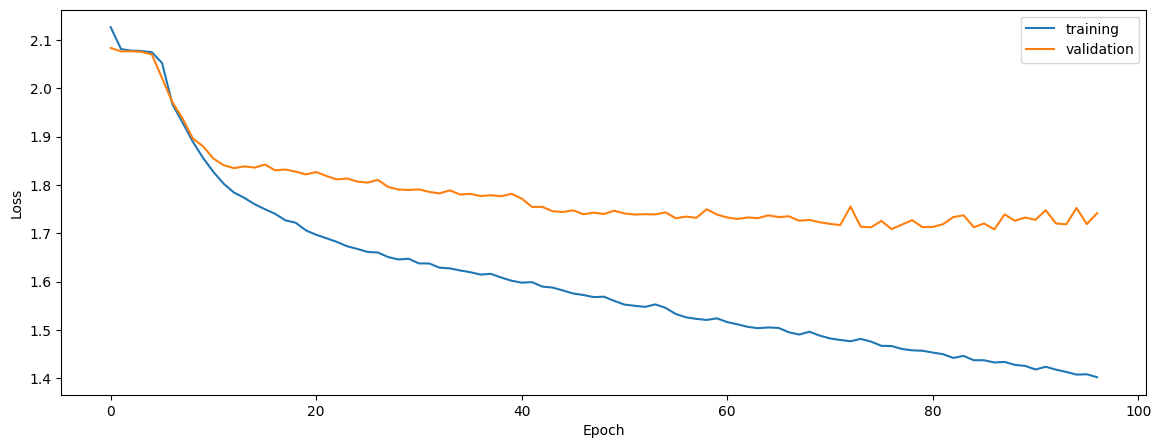

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

print('balanced')
print(getAccuarcy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuarcy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuarcy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

balanced


0.4541753055292193


0.3498242646498118


0.31924496219384246


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('original')
print(getAccuarcy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuarcy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuarcy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

original


0.3827910151437481


0.3399655034235239


0.26213115903090906


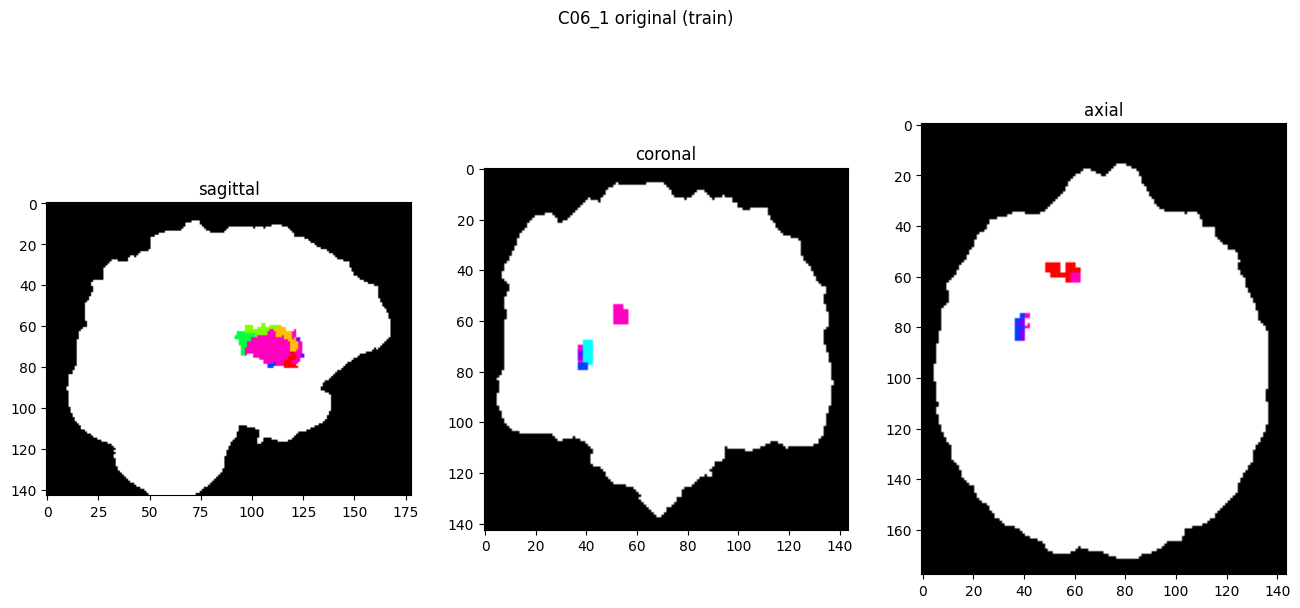

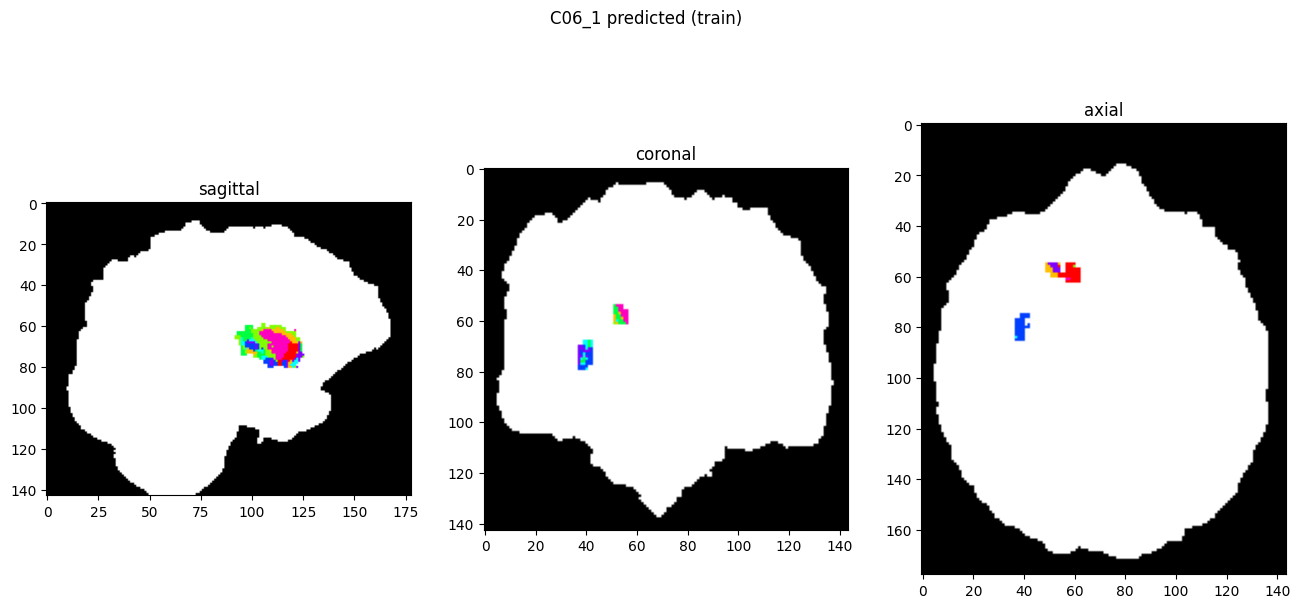

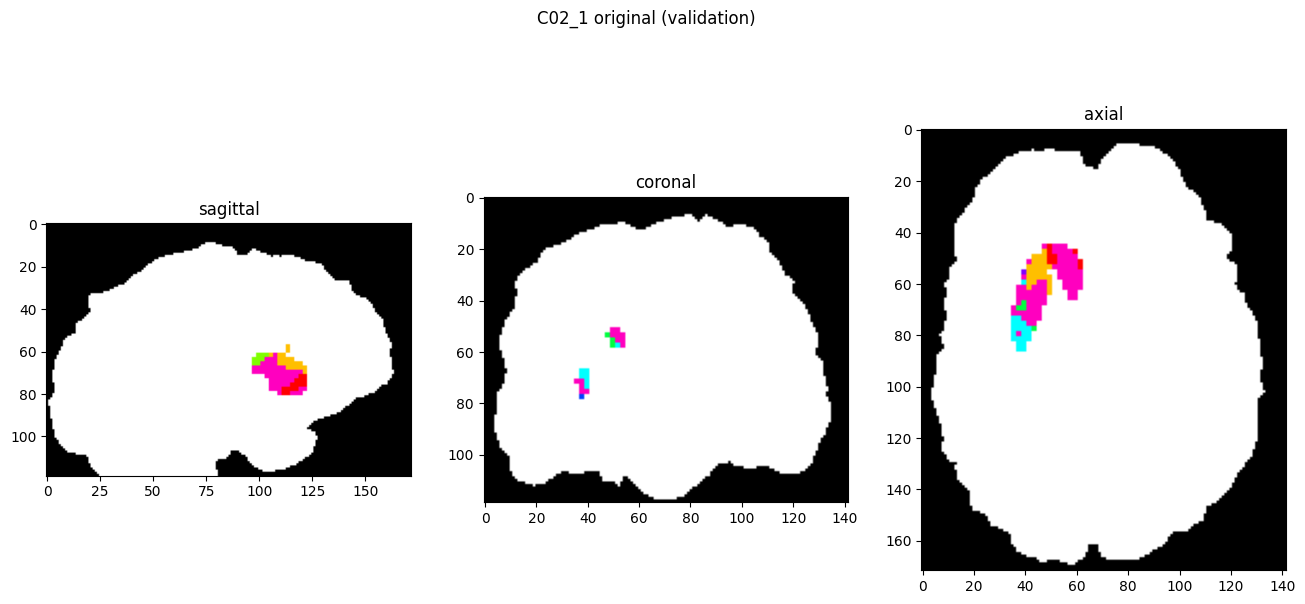

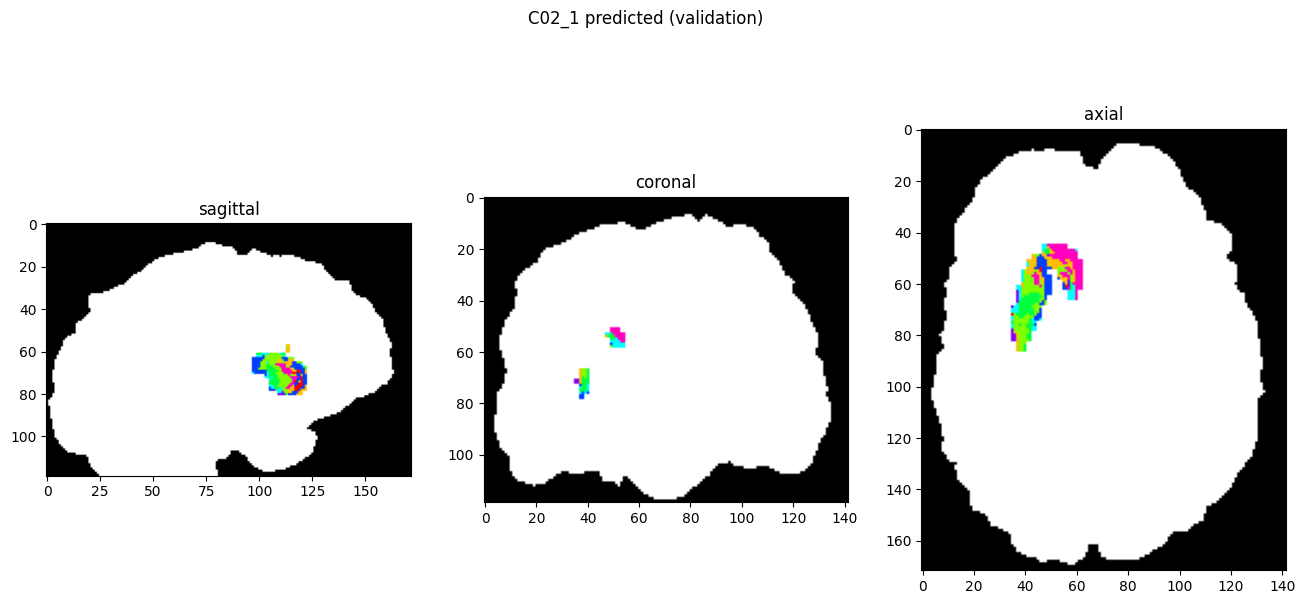

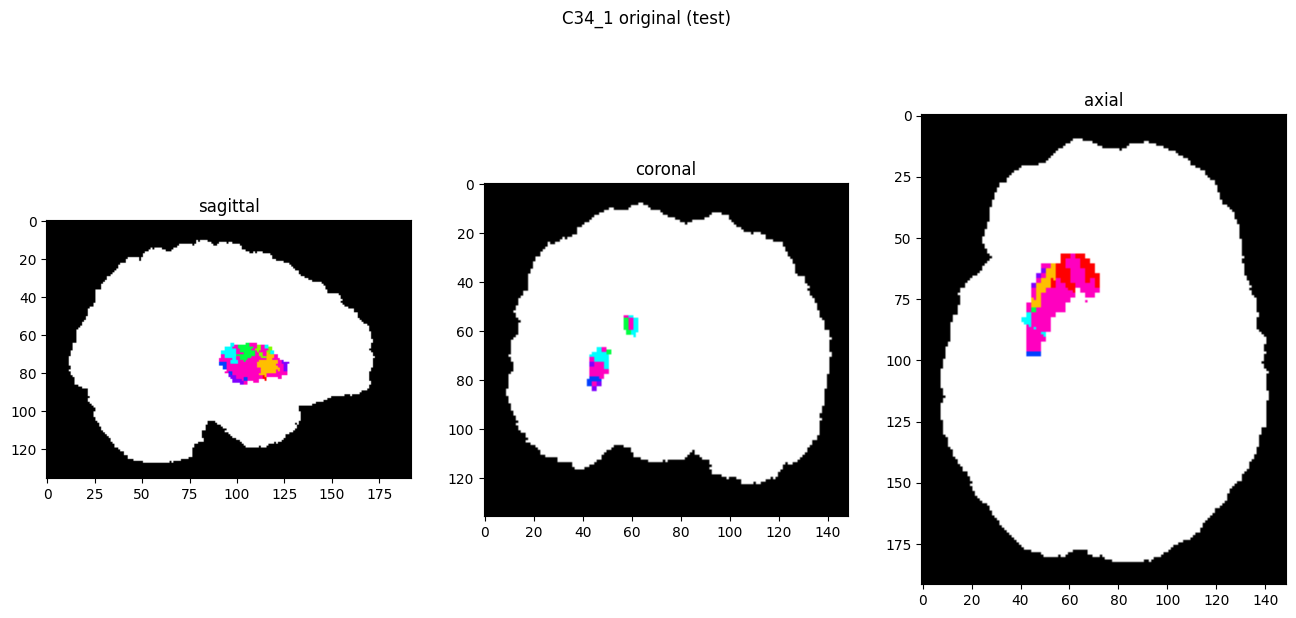

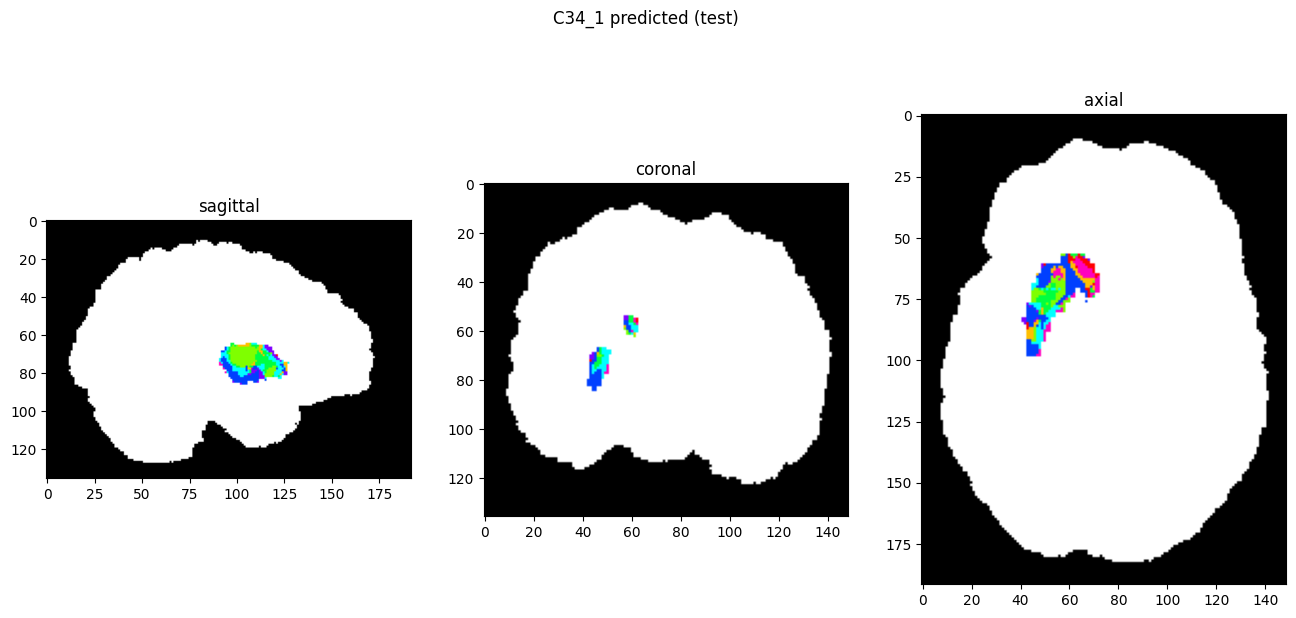

In [9]:
showResults(model, gen, threshold=0)